In [ ]:
import numpy as np
import cv2

In [ ]:
depth_path = r'C:\Users\Furihata\Desktop\Adam\Grasp Planning\Simulation\Real Depth Image\3\1.png'

In [ ]:
image = cv2.imread(depth_path, cv2.IMREAD_GRAYSCALE)
image = 255 - image
filt = cv2.GaussianBlur(image, (11,11), 0)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image, cmap = 'gray')
plt.show()

In [ ]:
edge_im = cv2.Canny(image, 10, 50)

In [ ]:
image.shape

In [ ]:
plt.imshow(edge_im,  cmap='Greys')
plt.show()

In [ ]:
image.shape

In [ ]:
image_cropped = image[124:1024, 380:1280]
image_cropped = cv2.resize(image_cropped, (224, 224))

In [ ]:
plt.imshow(image_cropped, cmap = 'gray')
plt.show()

In [ ]:
import Img_antipodal_sampler as spl

In [ ]:
image_filt = cv2.GaussianBlur(image_cropped, (5,5), 0)

In [ ]:
edge_im = cv2.Canny(image_filt, 5, 60)

In [ ]:
normal_px, edge_px, = spl.normals(image_cropped, edge_im)

In [ ]:
grasps, grasp_normals, centers = spl.antipodal_sampler(edge_px, normal_px)

In [ ]:
save_arr = r'C:\Users\Furihata\Desktop\Adam\Grasp Planning\Simulation\Image\realgrasps.png'
depth_loc = r'C:\Users\Furihata\Desktop\Adam\Grasp Planning\Simulation\Image\realdepth.png'

In [ ]:
plt.imsave(depth_loc, image_cropped, cmap = 'gray')

In [ ]:
spl.draw_grasps(grasps, depth_loc, save_arr)

In [1]:
import cv2
import matplotlib.pyplot as plt
from skimage.morphology import closing, square

In [2]:
def collision_est(depth, seg, ID, grasps, image_size):
    collision_scores = []
    height = image_size[0]
    width = image_size[1]
    for i in range(len(grasps)):
        
        seg = seg.astype('float32')
        depth = depth.astype('float32')
        
        grasp_vector =  grasps[i,1] - grasps[i,0]
        grasp_length = np.linalg.norm(grasp_vector)
        grasp_center = ((grasps[i,0] + grasps[i,1]) / 2).astype(int)
        angle = np.arctan2(grasp_vector[1], grasp_vector[0]) * 180 / np.pi
        
        M = cv2.getRotationMatrix2D((grasp_center[0], grasp_center[1]), angle, 1.0)
        
        depth_im_val = cv2.warpAffine(depth, M, (depth.shape))
        seg_im_val = cv2.warpAffine(seg, M, (seg.shape))
        
        left = int(grasp_center[0] - (width/2))
        right = int(grasp_center[0] + (width/2))    
        top = grasp_center[1] - (height/2)
        bottom = grasp_center[1] + (height/2)

        #seg_full = seg_im_val[top:bottom, left:right]
        #depth_full = depth_im_val[top:bottom, left:right]

        part_ID = ID[i]
        seg_bounding = seg_im_val[grasp_center[1]-7:grasp_center[1]+7, left:right]
        depth_bounding = depth_im_val[grasp_center[1]-7:grasp_center[1]+7, left:right]
        
        part_indices = np.where(seg_bounding == part_ID) #in the form of [[row1, row2, .....], [column1, column2,.....]]
        nonpart_indices = np.where(seg_bounding != part_ID) #in the form of [[row1, row2, .....], [column1, column2,.....]]
        seg_bounding[part_indices[0], part_indices[1]] = 1
        seg_bounding[nonpart_indices[0], nonpart_indices[1]] = 0
        print(seg_bounding.shape)
        seg_mask = closing(seg_bounding, square(20))

        contact_point1 = int((width/2) - (grasp_length/2))
        contact_point2 = int((width/2) + (grasp_length/2))
        graspable_region1 = np.zeros((seg_mask.shape))
        graspable_region2 = np.zeros((seg_mask.shape))
        graspable_region1[:, contact_point1: contact_point1+5] = 1
        graspable_region2[:, contact_point2-5:contact_point2] = 1
        
        graspable_indices1 = np.where((seg_mask == 1)
                                    & (graspable_region1 ==1))
        graspable_indices2 = np.where((seg_mask == 1)
                                    & (graspable_region2 ==1))
        
        avgdepth_region1 = np.mean(depth_bounding[graspable_indices1[0], graspable_indices1[1]])
        avgdepth_region2 = np.mean(depth_bounding[graspable_indices2[0], graspable_indices2[1]])
        
        depth_region1 = np.copy(depth_bounding)
        depth_region1[:,int((width/2)):] = 1
        depth_region2 = np.copy(depth_bounding)
        depth_region2[:,0:int((width/2))] = 1
        
        if(np.isnan(avgdepth_region1)):
            cl_score1 = 10000
        else:
            cs_indices = np.where((seg_mask == 0) &
                              (depth_region1 <= avgdepth_region1))
            cl_score1 = len(cs_indices[0])
        
        if(np.isnan(avgdepth_region2)):
            cl_score2 = 10000
        else:
            cs_indices = np.where((seg_mask == 0) &
                              (depth_region2 <= avgdepth_region2))
            cl_score2 = len(cs_indices[0])
        
        plt.imshow(depth_bounding, cmap = 'gray_r')
        plt.show()
        plt.imshow(depth_region1, cmap = 'gray_r')
        plt.show()
        plt.imshow(depth_region2, cmap = 'gray_r')
        plt.show()
        plt.imshow(seg_mask, cmap = 'gray')
        plt.show()
        print(cl_score1,cl_score2)
            
        collision_scores.append(cl_score1+cl_score2)
        
            
    return np.asarray(collision_scores) #, depth_boundings, depth_fulls, seg_boundings, seg_fulls

In [3]:
import numpy as np
depthImg = np.load('depth.npy')
segImg = np.load('seg.npy')
grasps = np.load('grasps.npy')
ID = np.load('ID.npy')

(14, 24)


C:\Program Files\Anaconda3\lib\site-packages\skimage\util\arraypad.py:1537: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


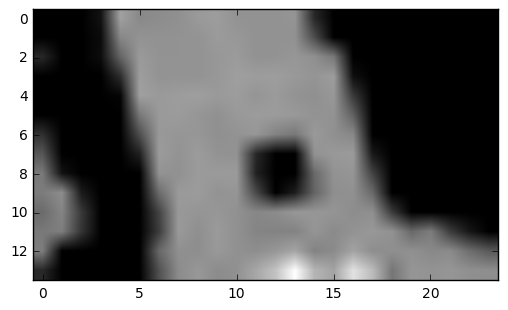

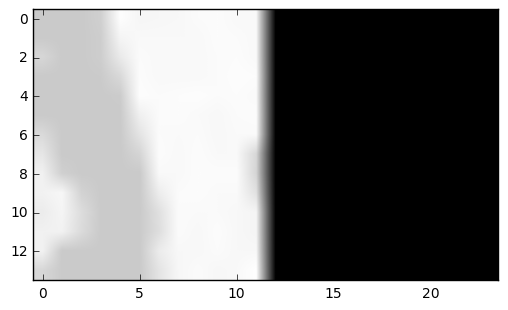

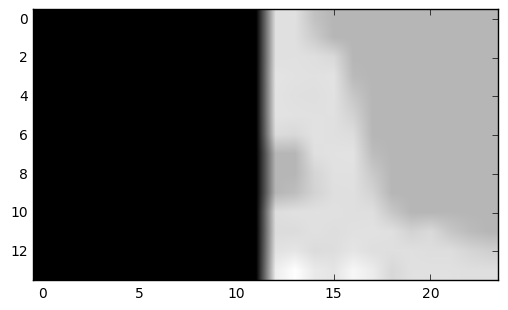

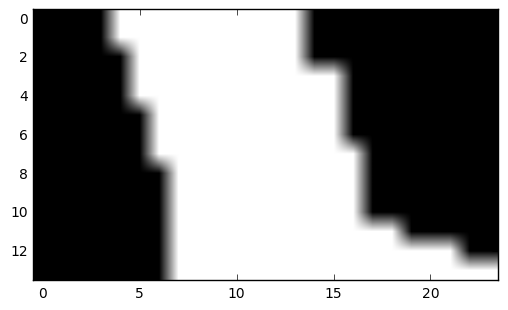

0 3
(14, 24)


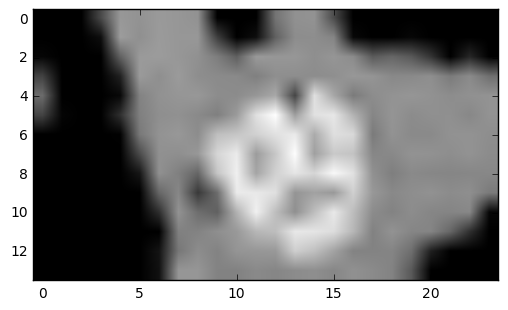

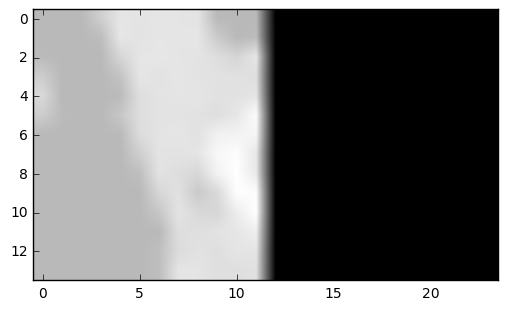

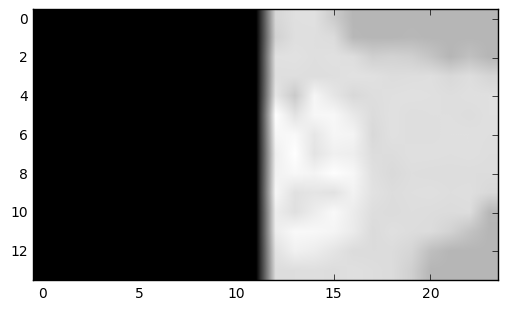

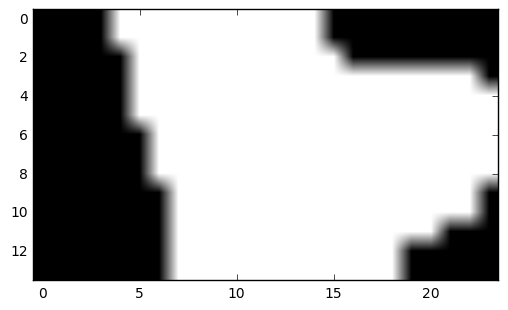

0 0
(14, 24)


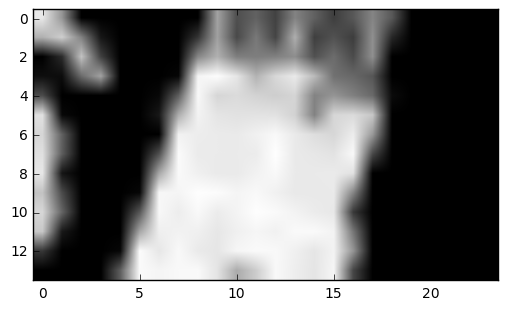

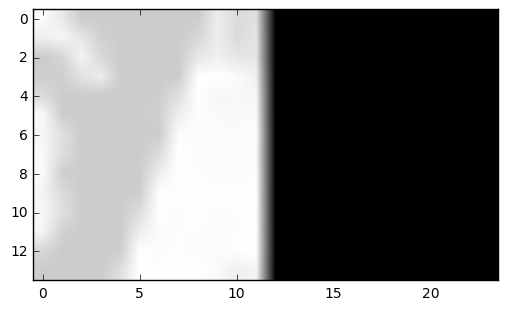

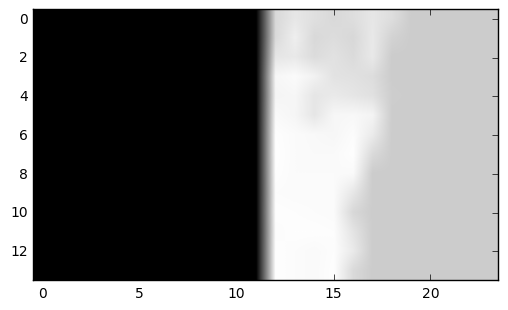

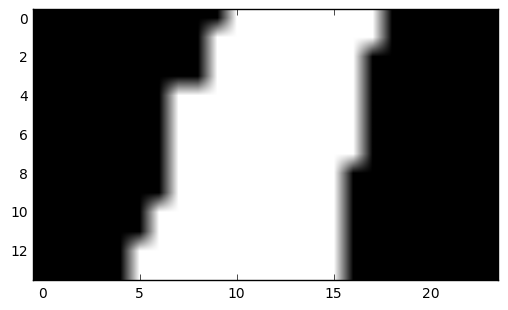

6 2
(14, 24)


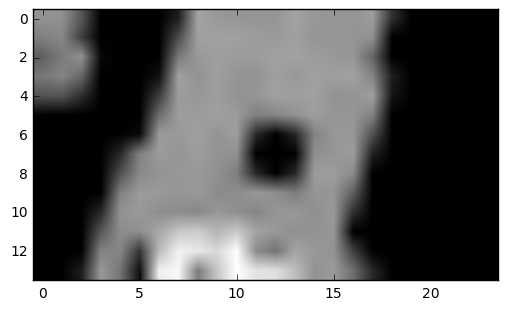

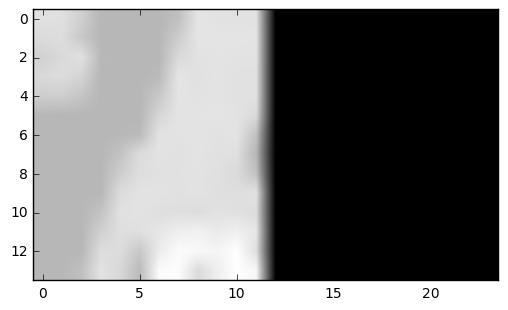

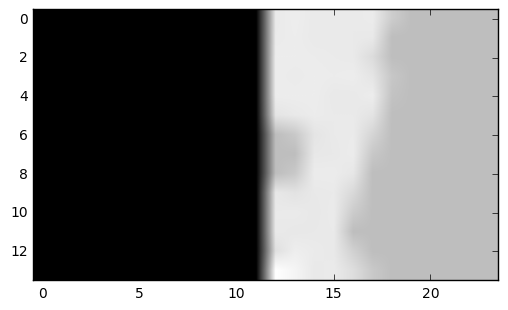

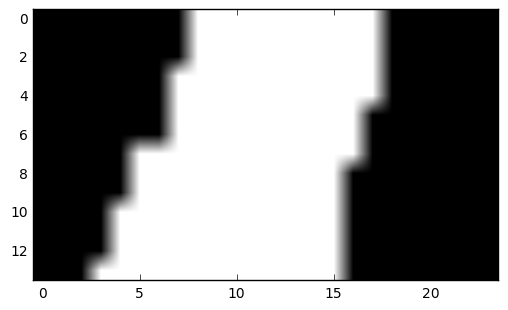

0 0
(14, 24)


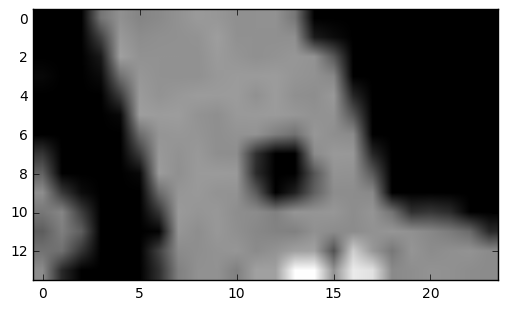

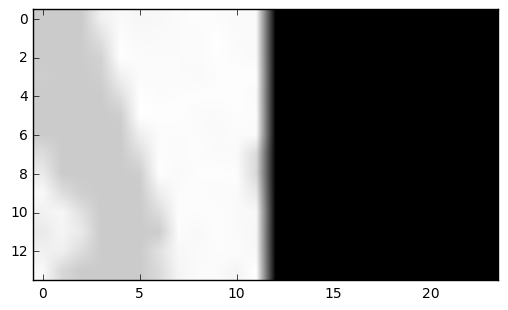

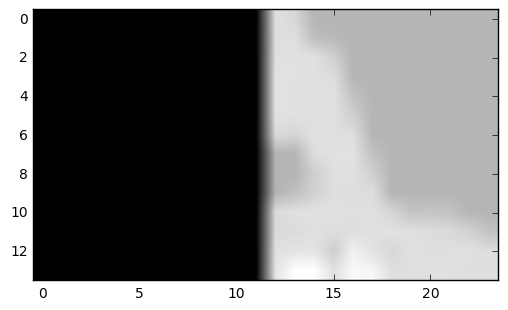

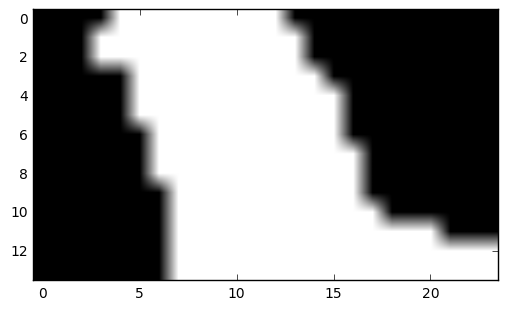

0 4
(14, 24)


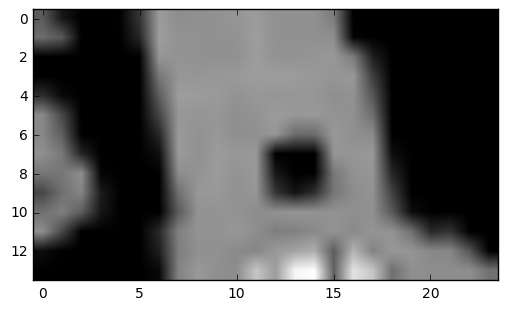

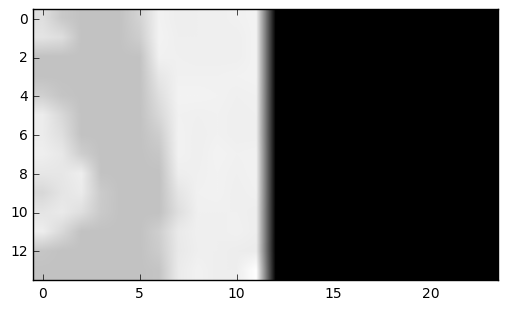

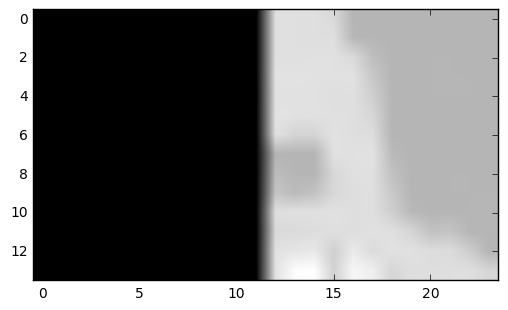

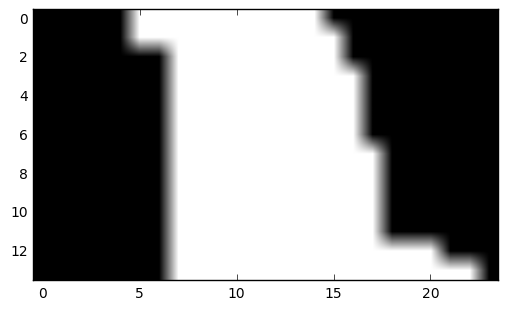

1 3
(14, 24)


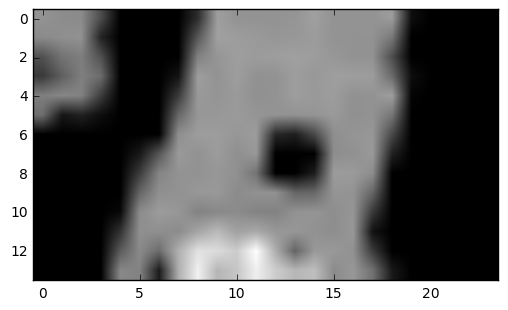

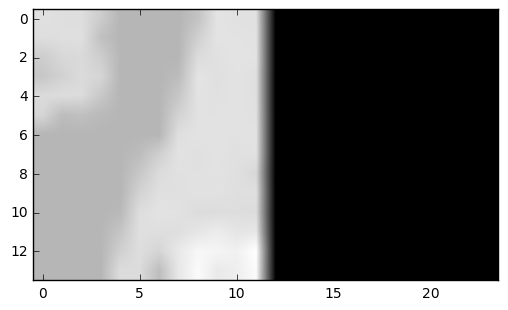

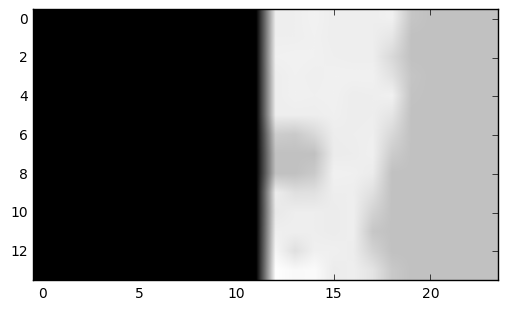

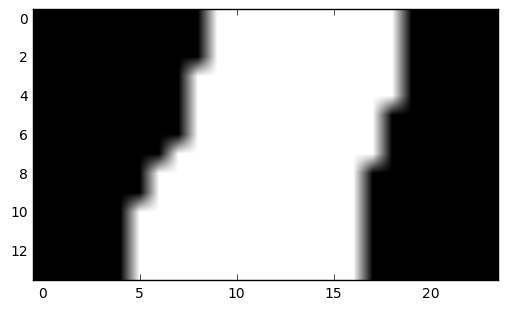

0 1
(14, 24)


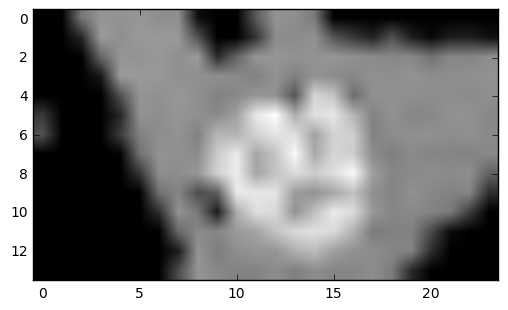

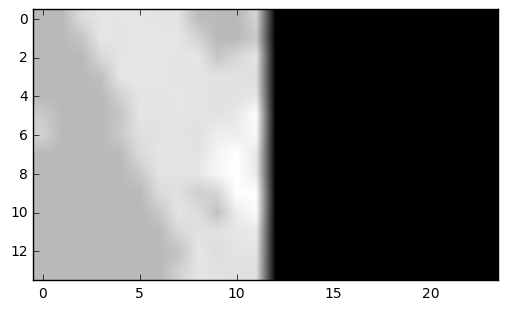

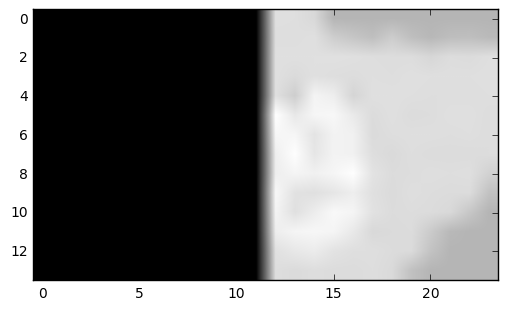

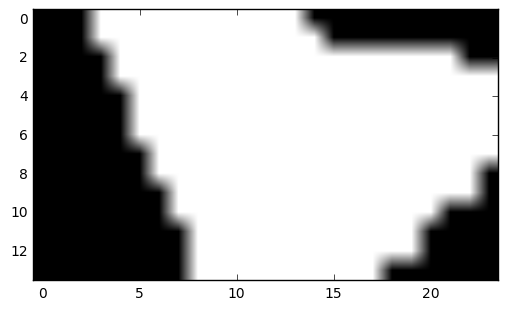

0 0
(14, 24)


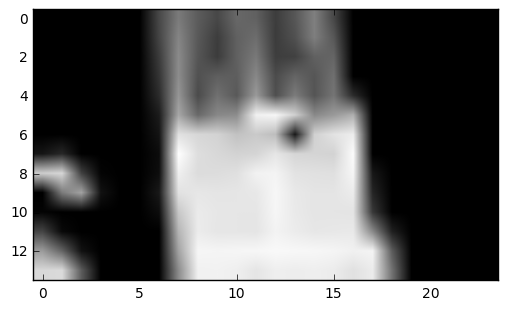

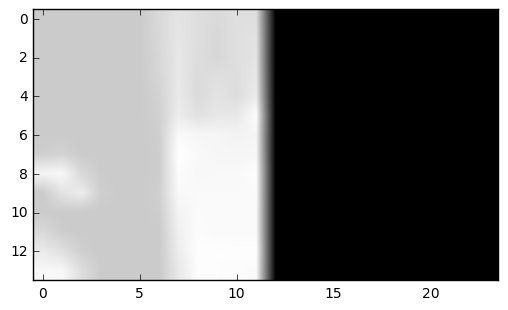

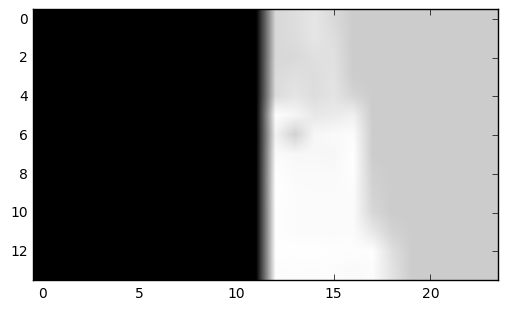

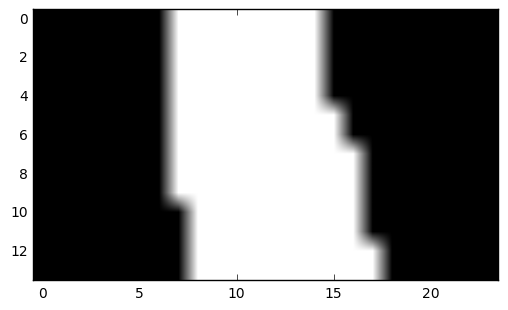

6 1
(14, 24)


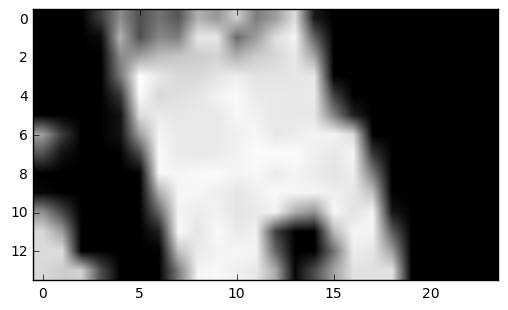

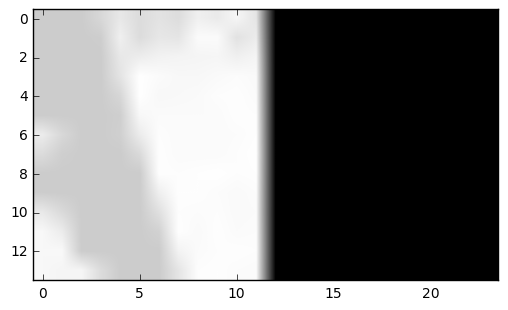

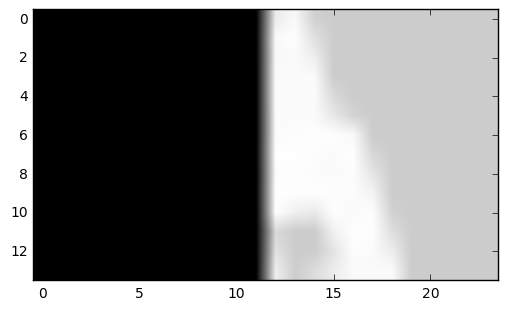

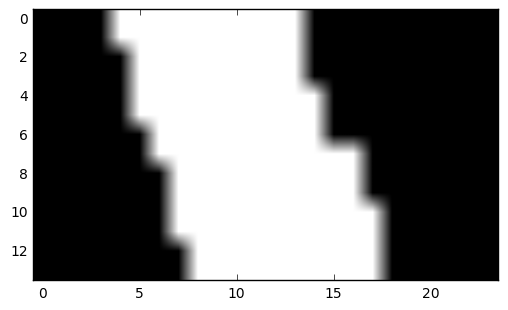

2 4
(14, 24)


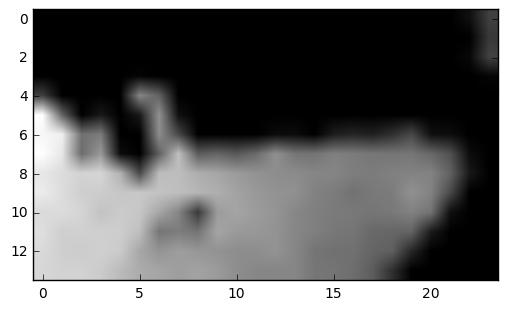

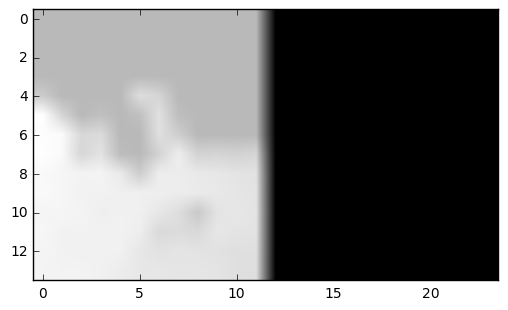

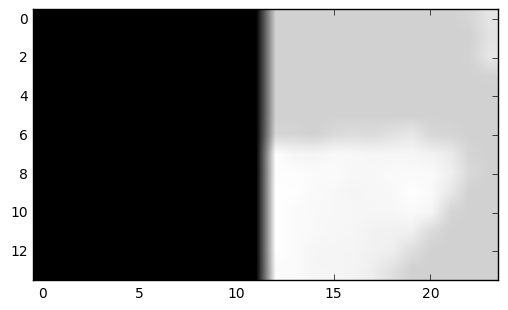

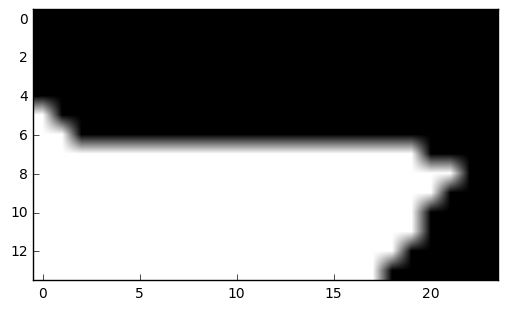

0 0
(14, 24)


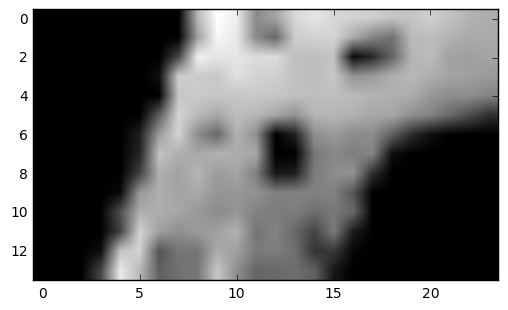

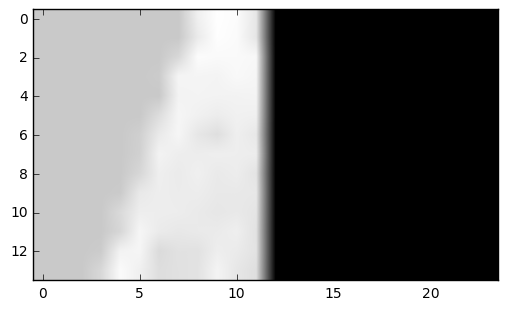

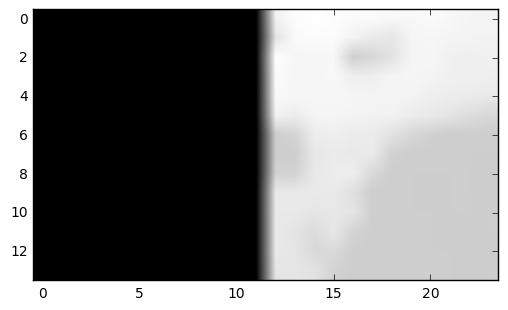

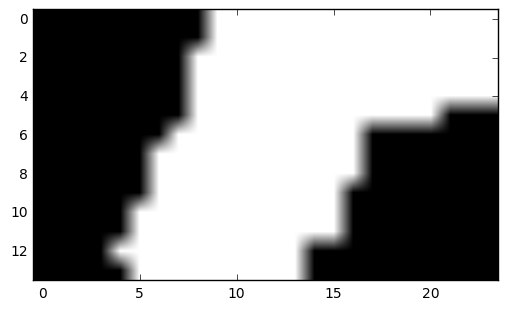

5 0
(14, 24)


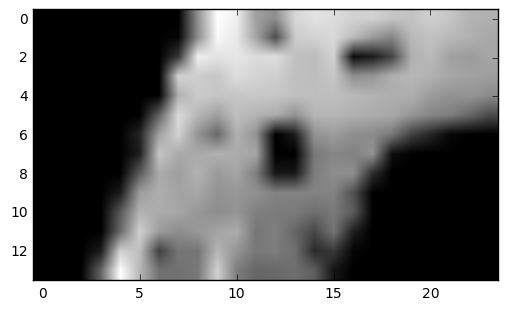

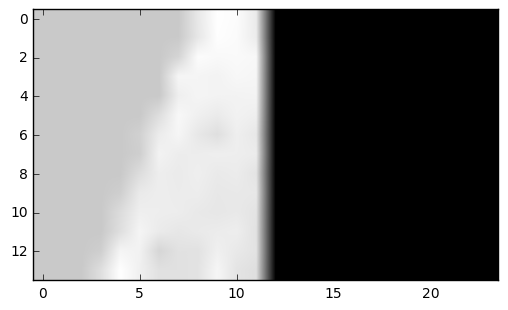

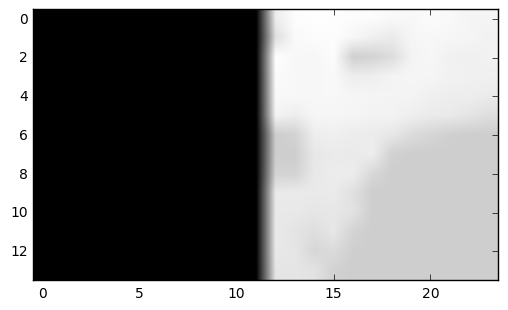

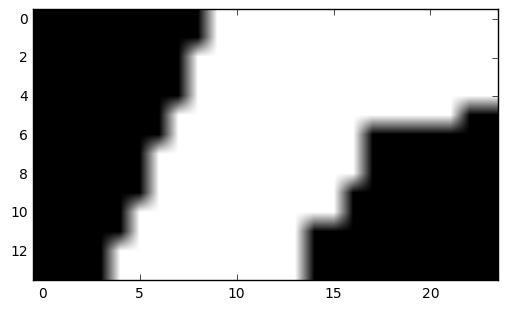

2 1
(14, 24)


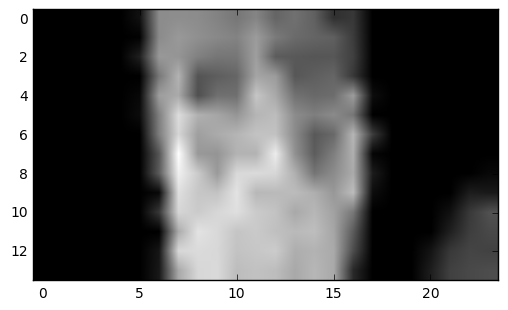

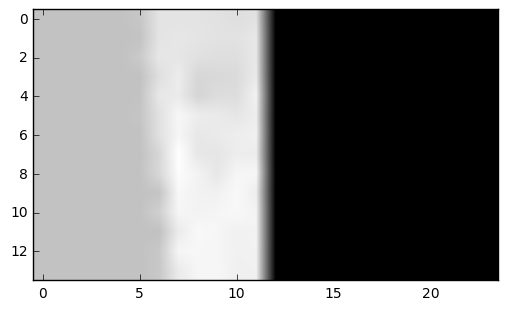

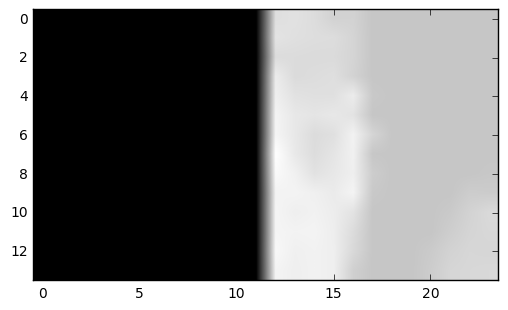

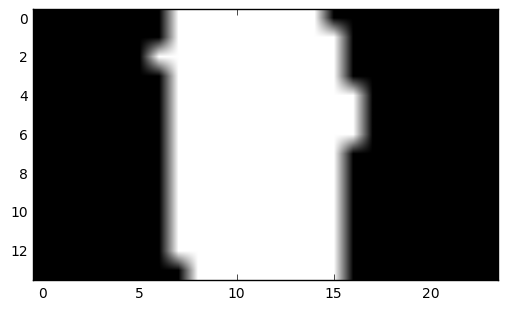

0 3
(14, 24)


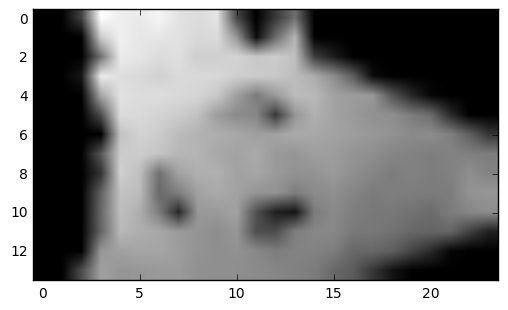

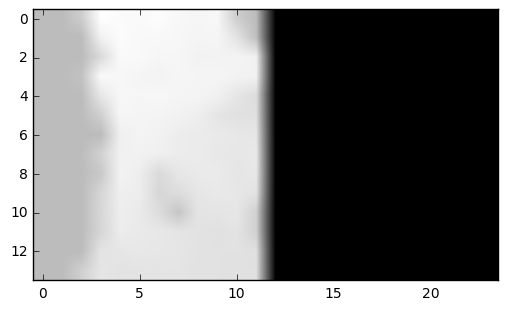

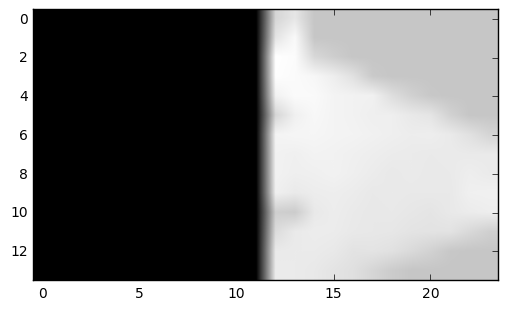

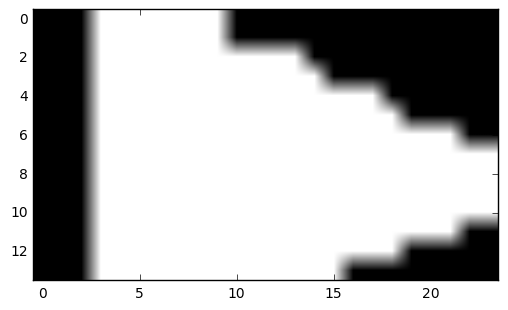

0 1
(14, 24)


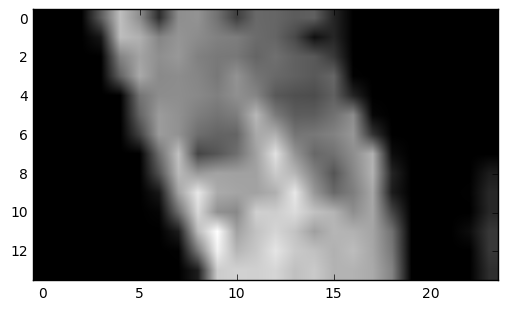

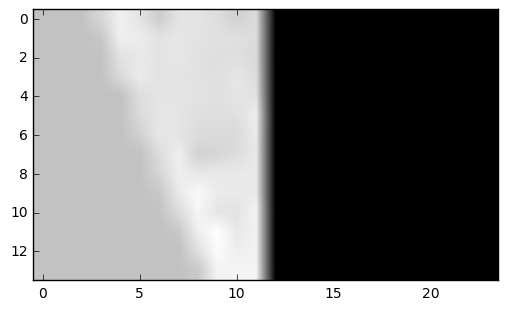

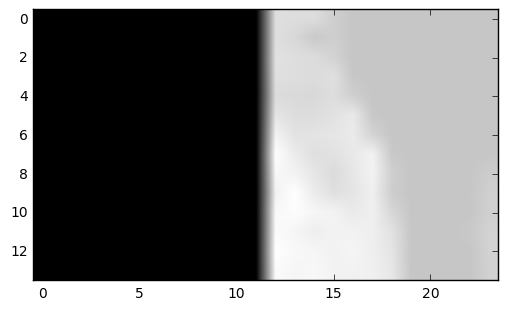

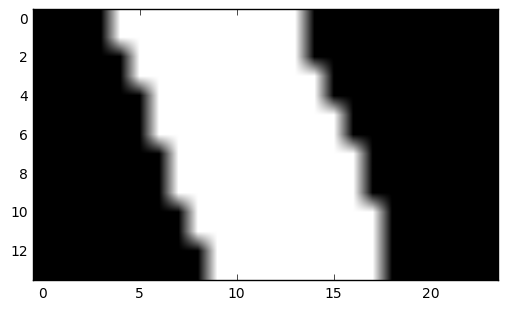

0 4
(14, 24)


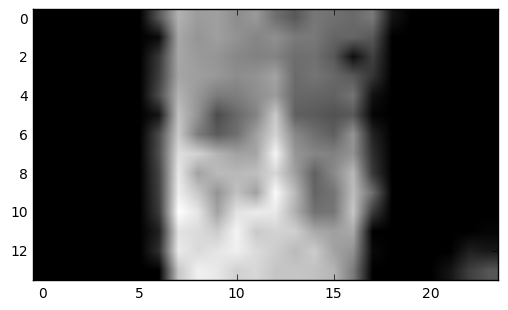

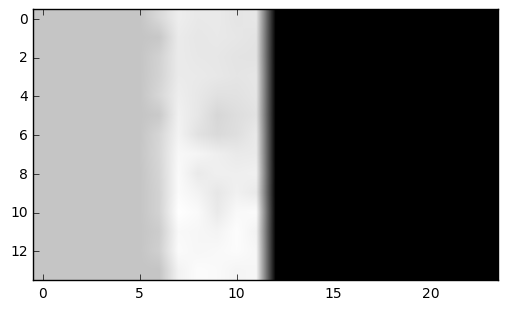

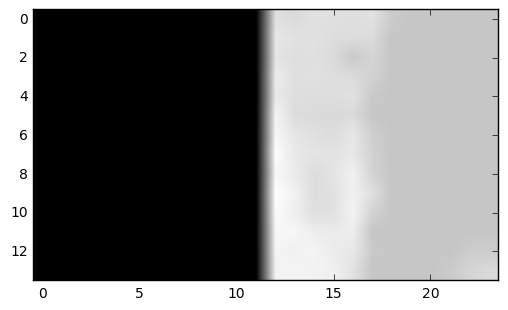

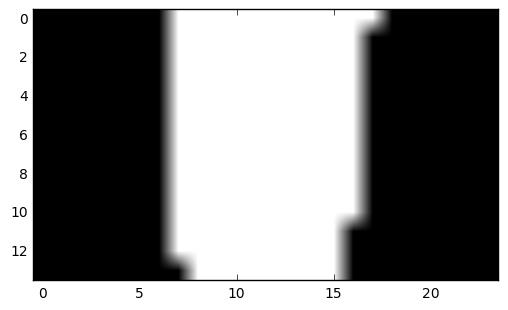

1 1
(14, 24)


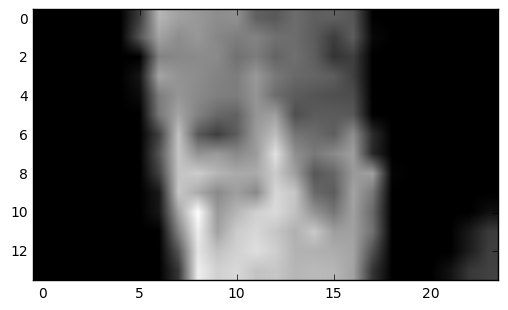

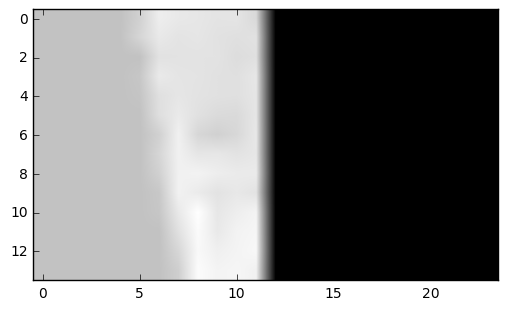

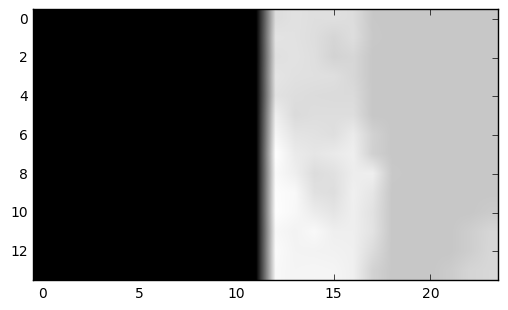

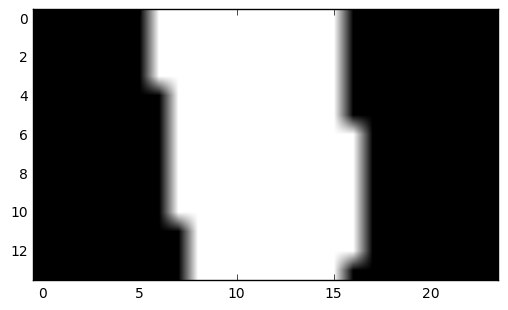

0 2
(14, 24)


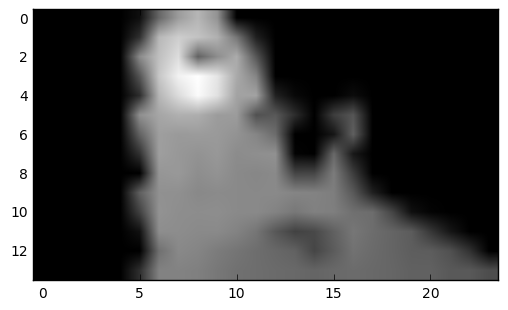

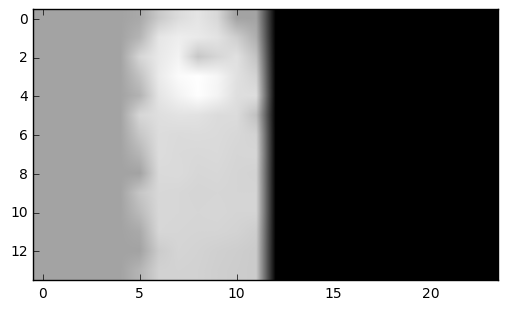

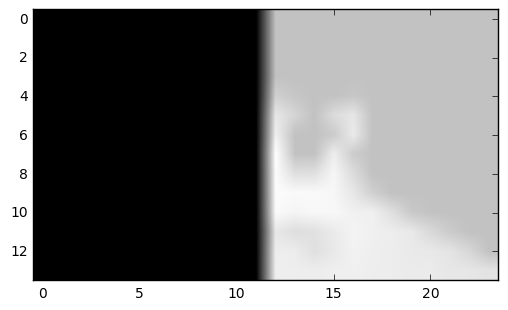

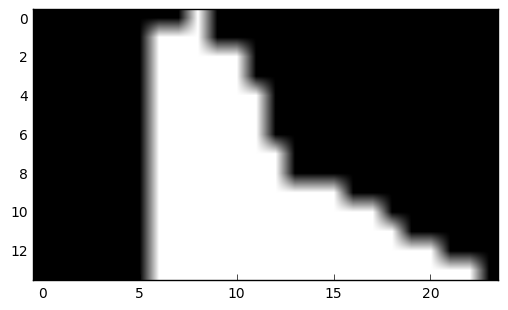

1 1
(14, 24)


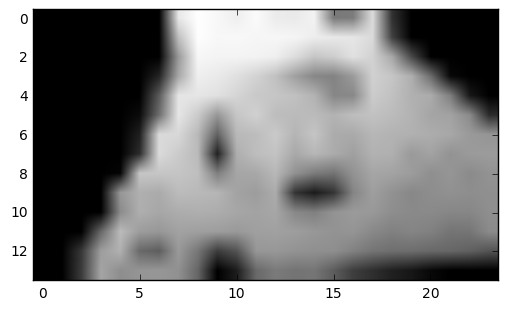

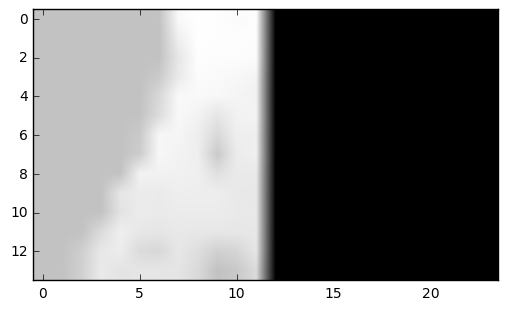

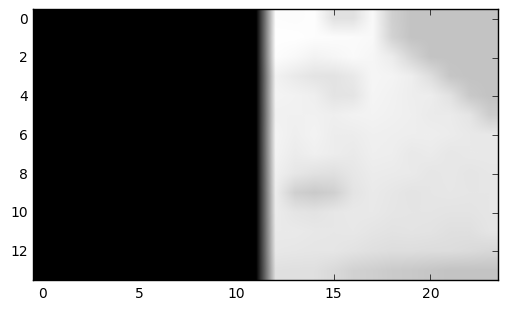

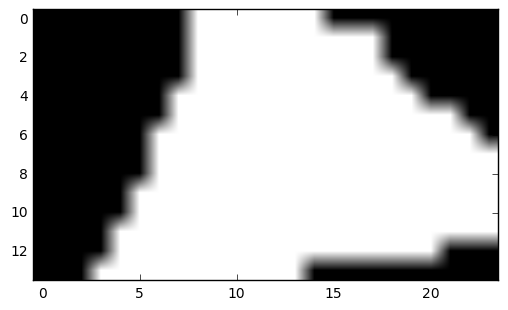

3 4
(14, 24)


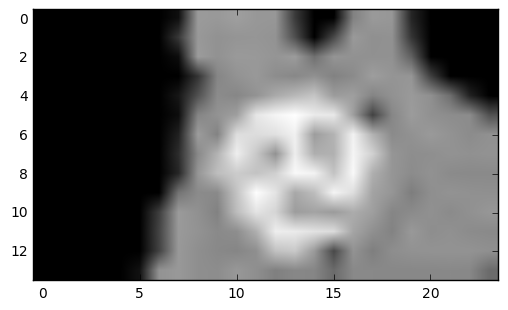

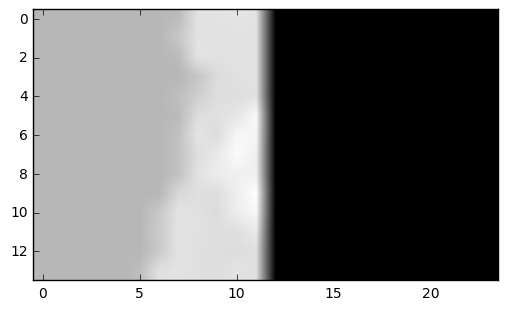

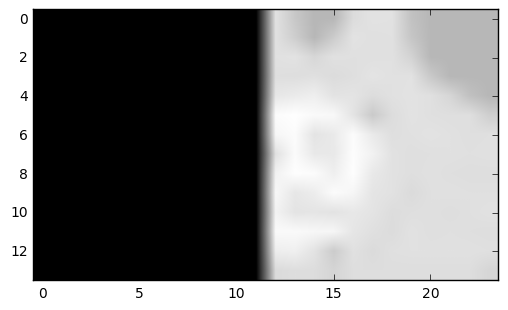

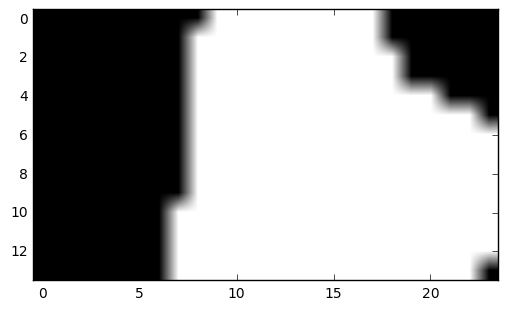

1 0
(14, 24)


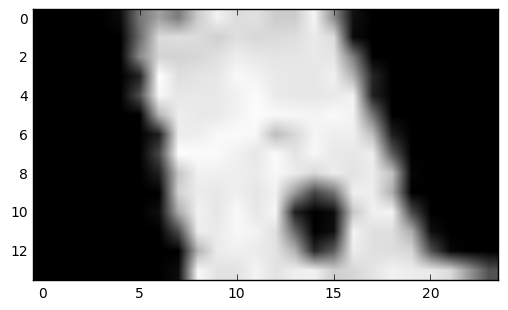

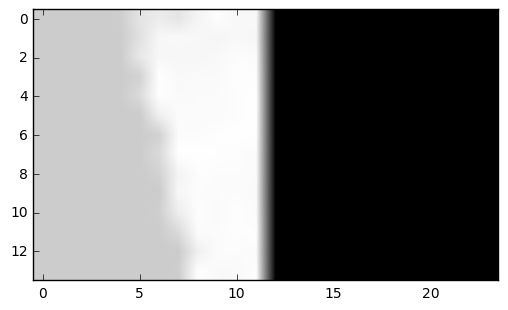

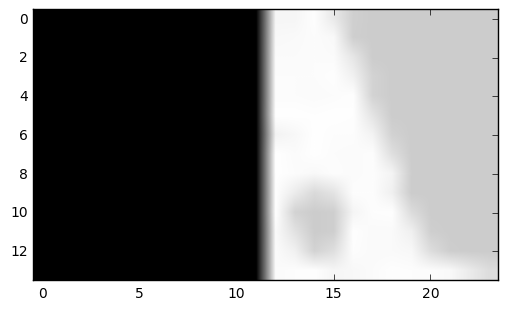

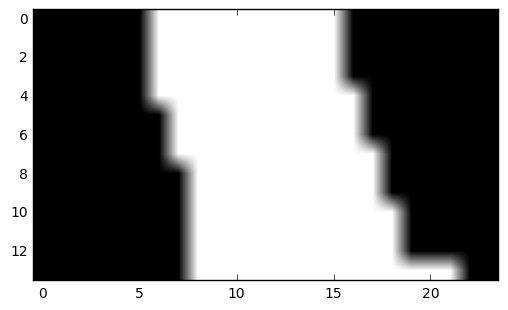

0 1
(14, 24)


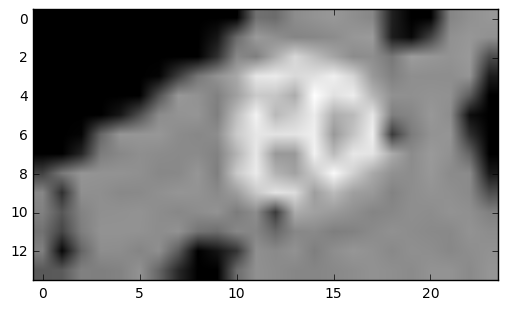

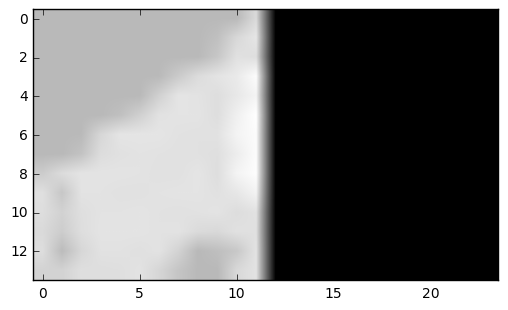

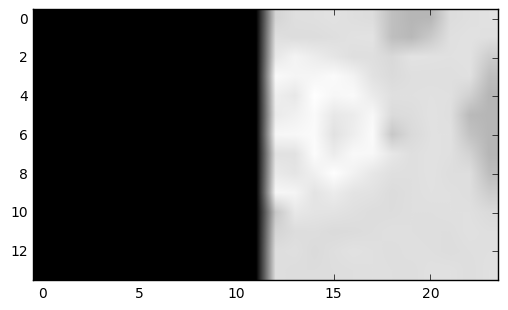

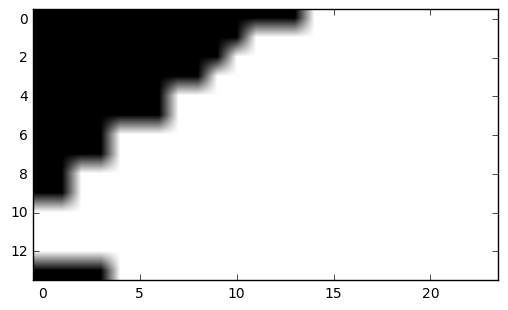

3 0
(14, 24)


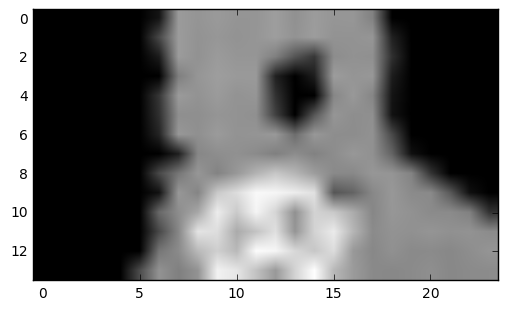

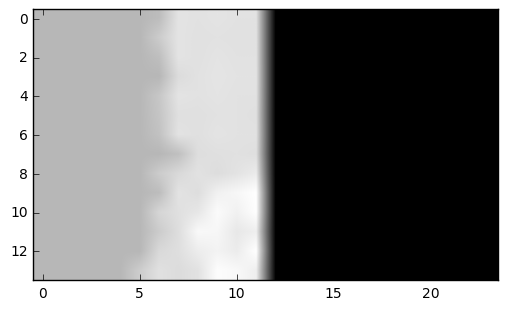

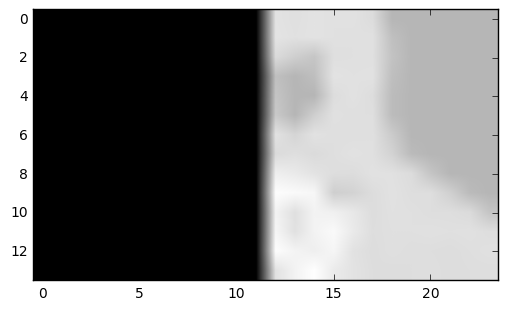

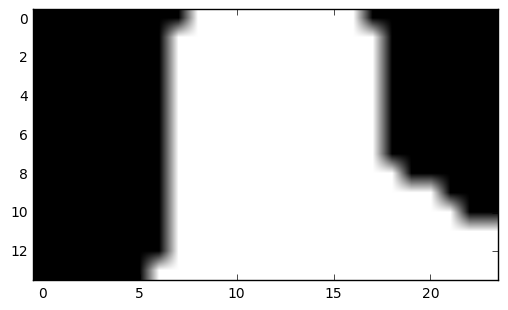

0 0
(14, 24)


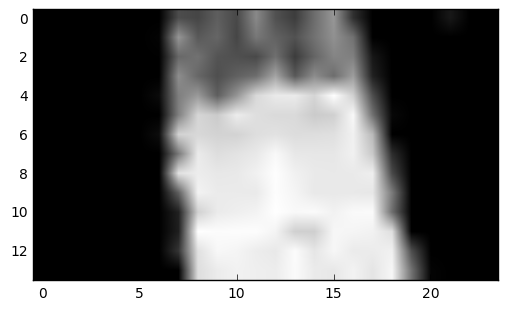

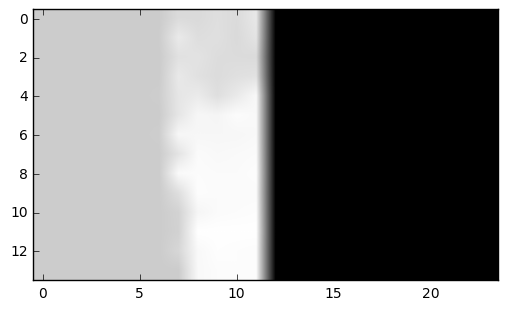

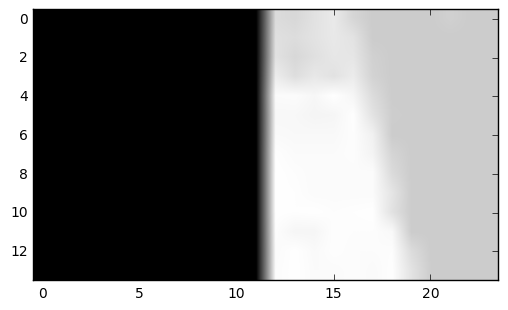

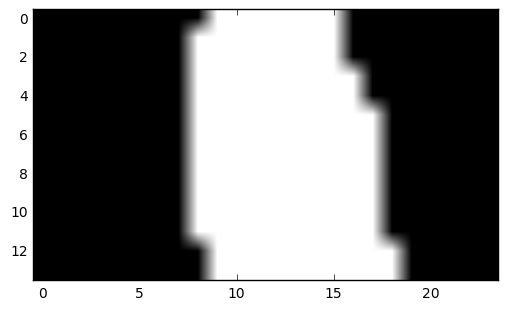

4 1
(14, 24)


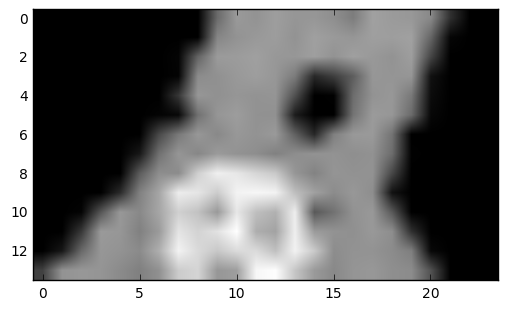

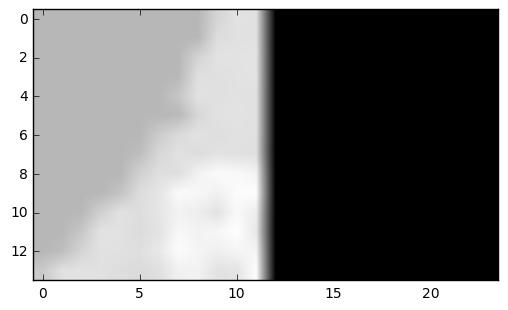

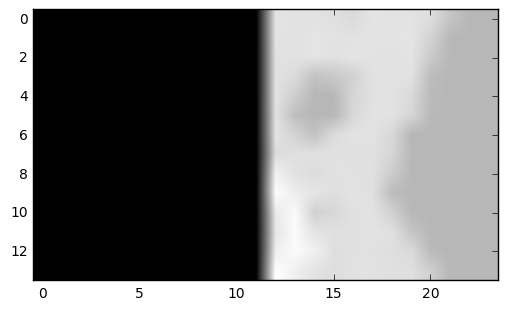

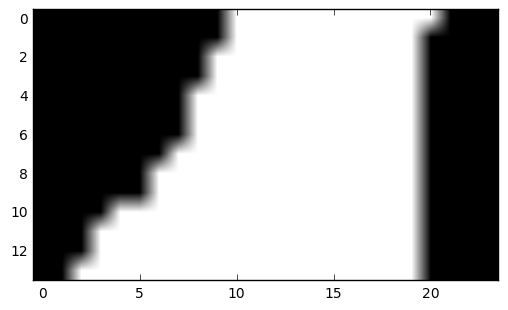

0 0
(14, 24)


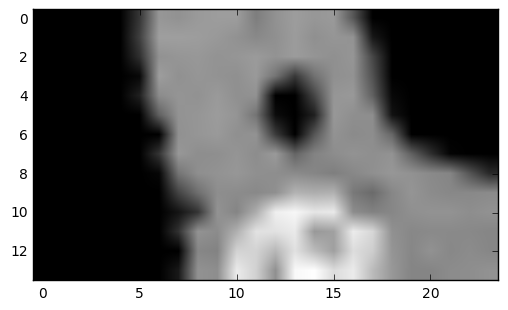

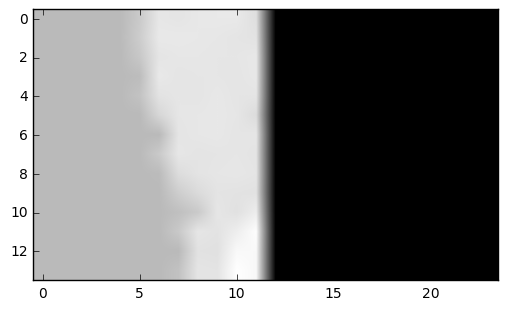

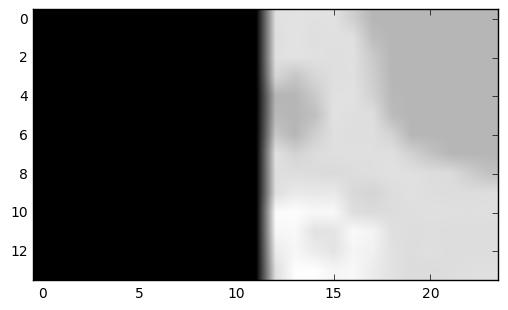

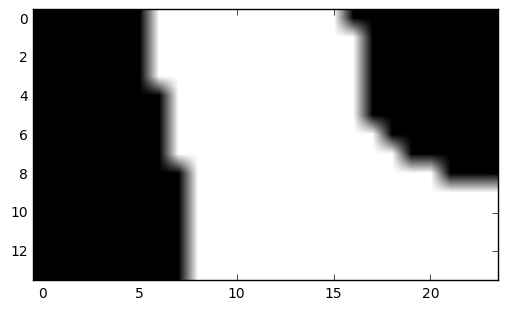

0 0
(14, 24)


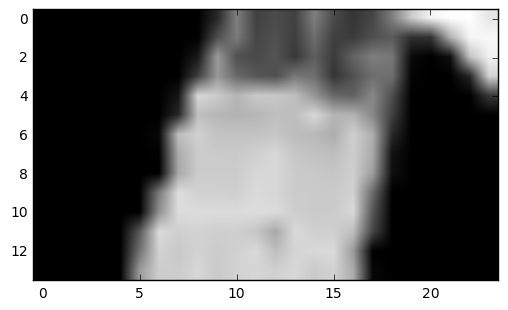

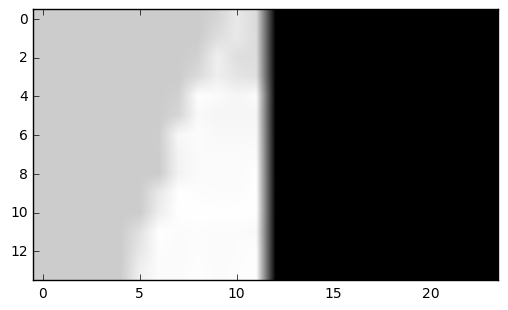

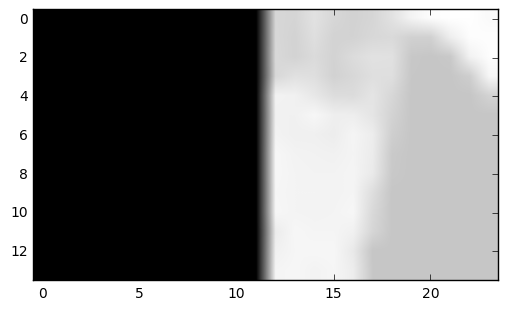

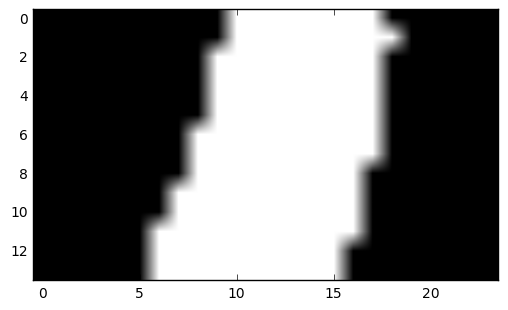

3 12
(14, 24)


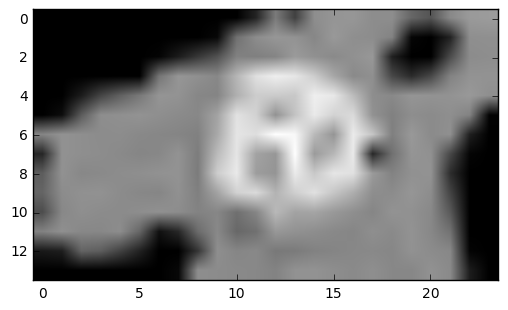

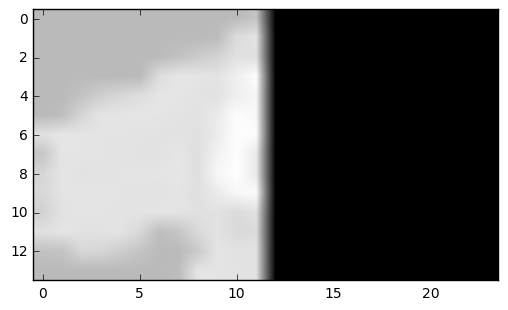

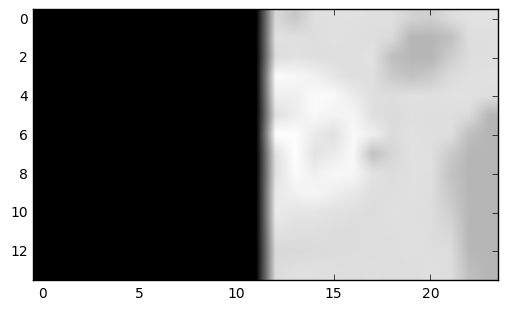

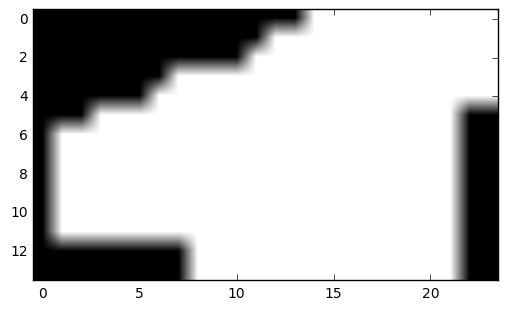

1 0
(14, 24)


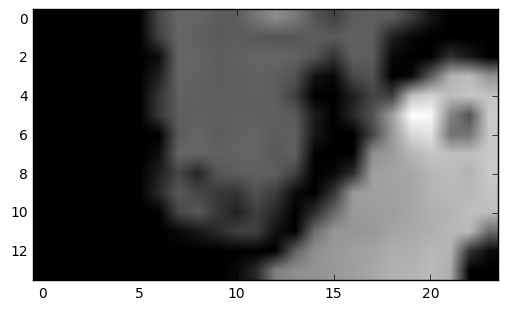

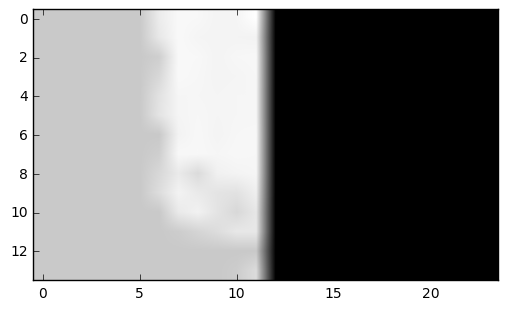

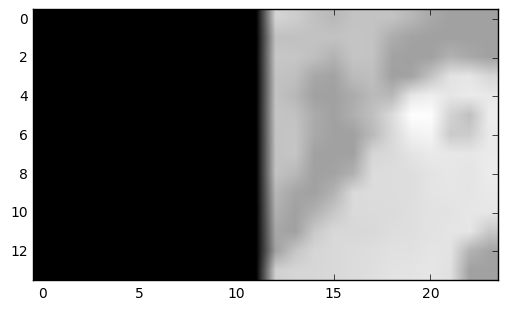

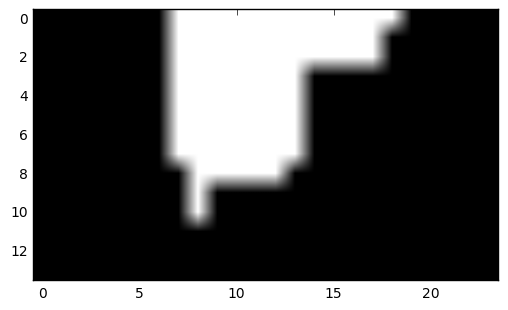

0 79
(14, 24)


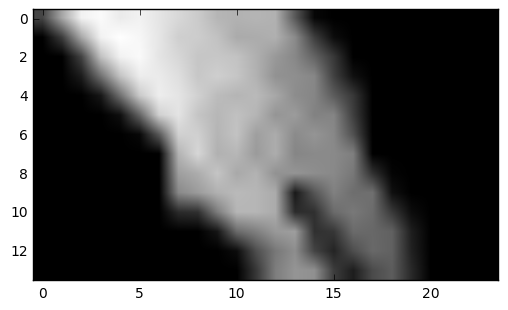

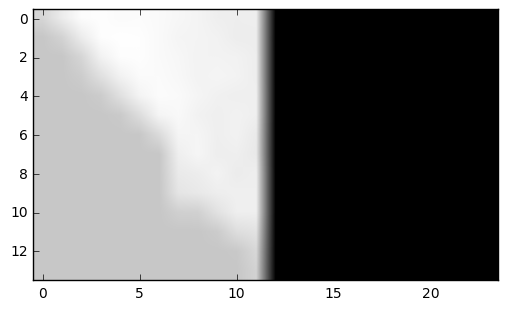

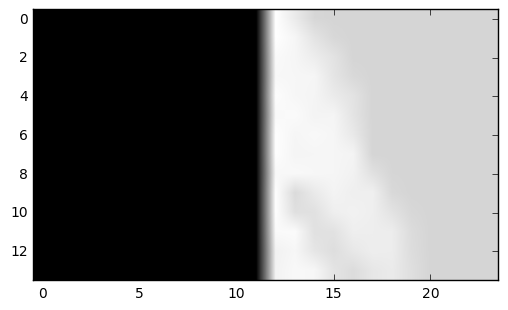

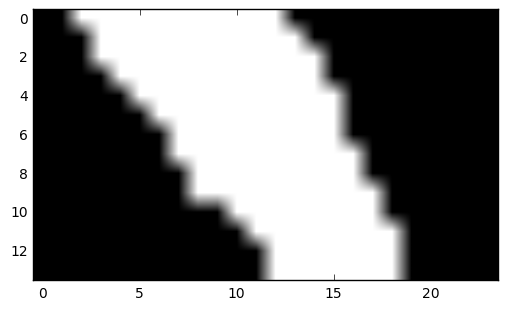

0 0
(14, 24)


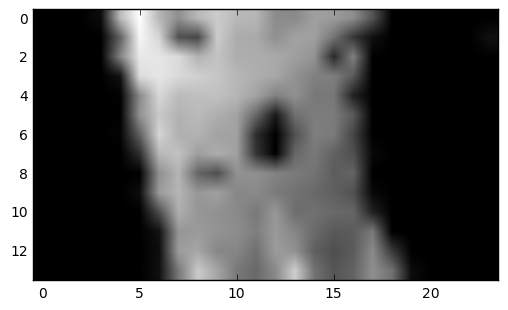

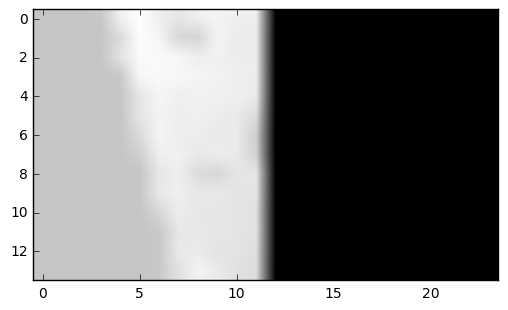

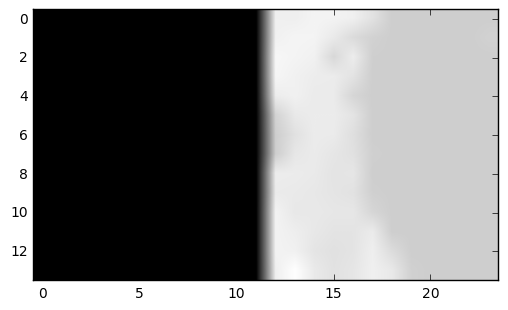

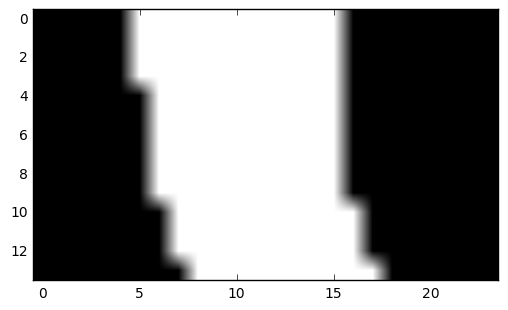

1 4
(14, 24)


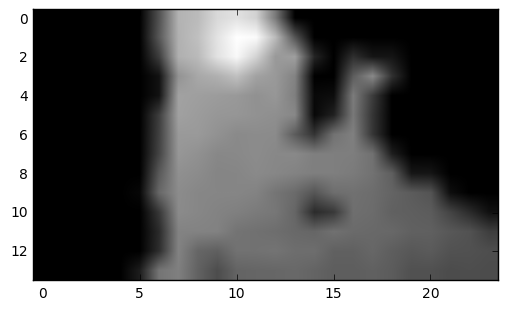

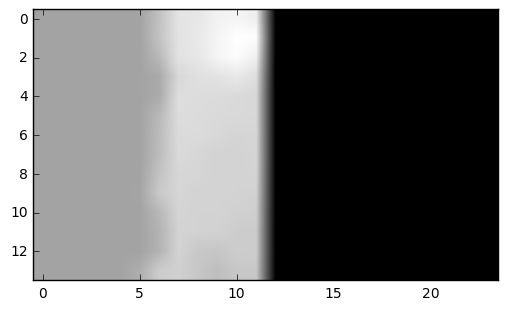

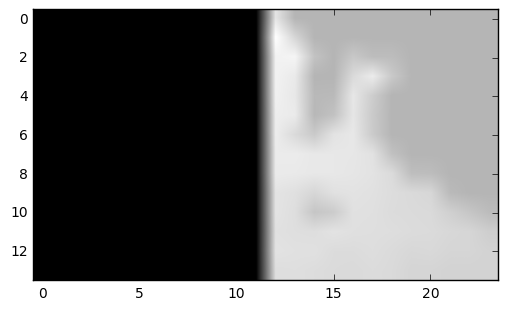

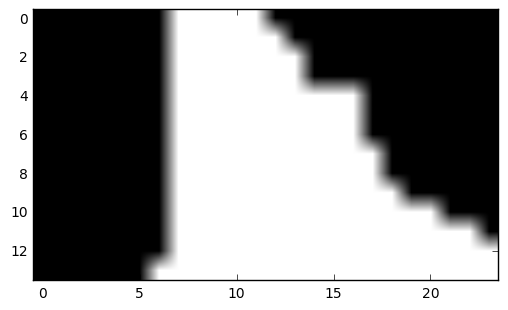

0 2
(14, 24)


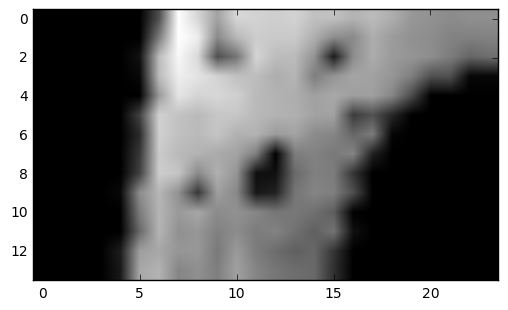

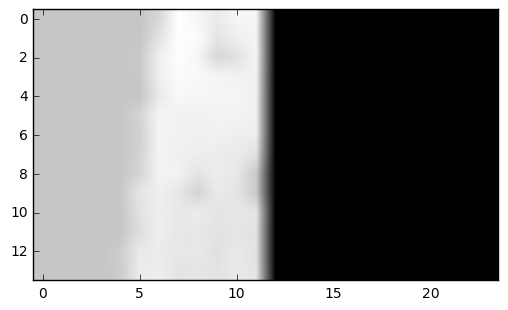

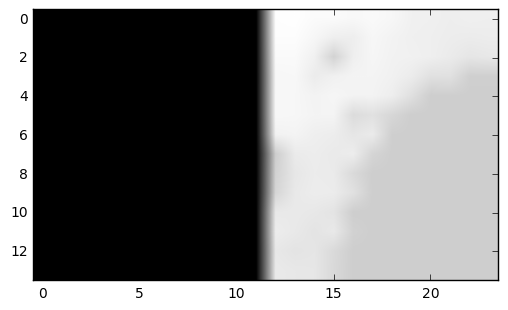

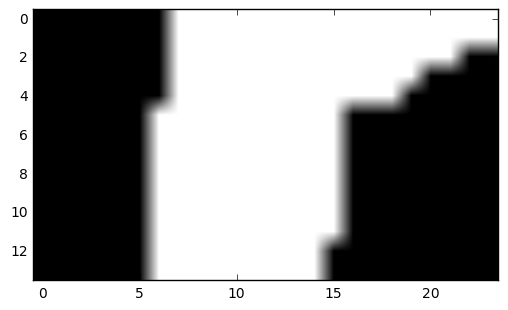

2 0
(14, 24)


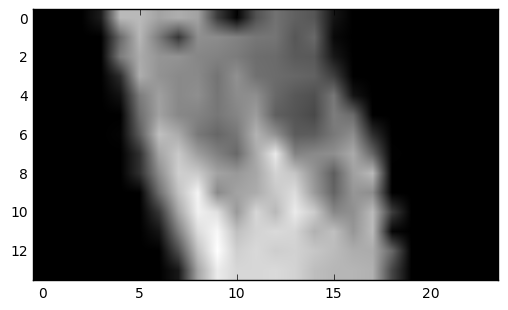

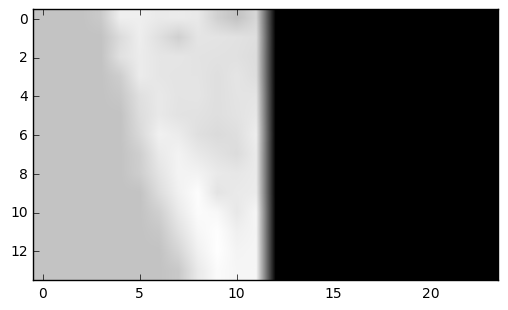

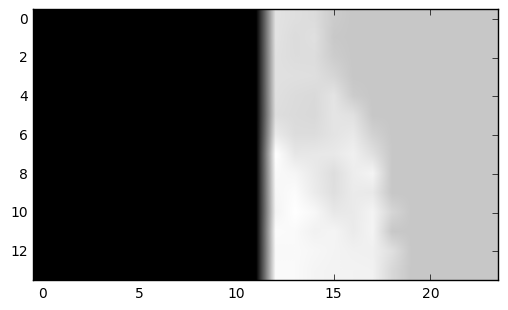

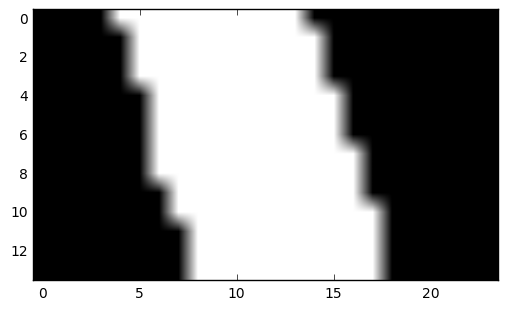

0 1
(14, 24)


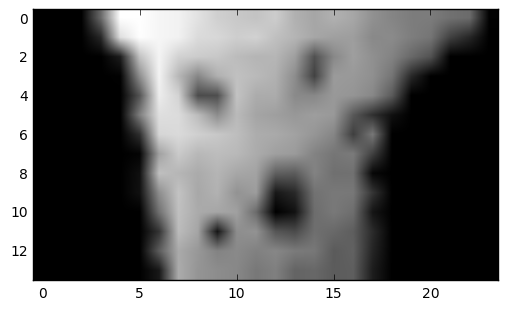

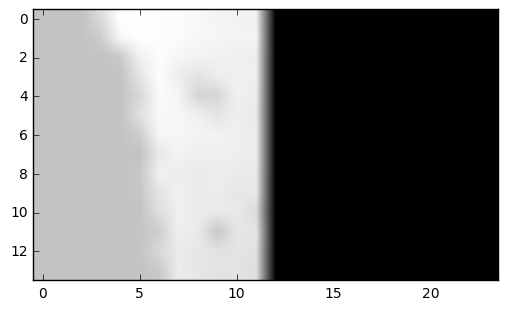

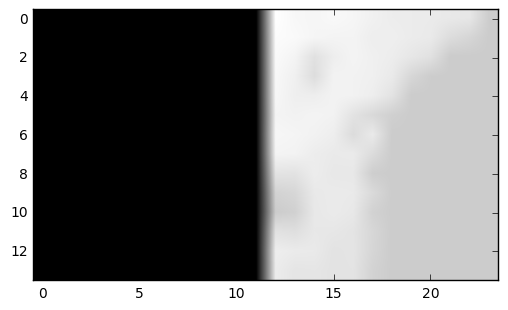

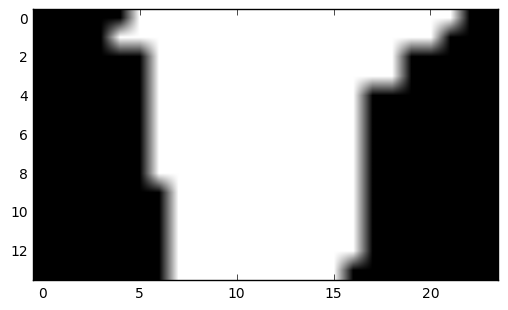

2 1
(14, 24)


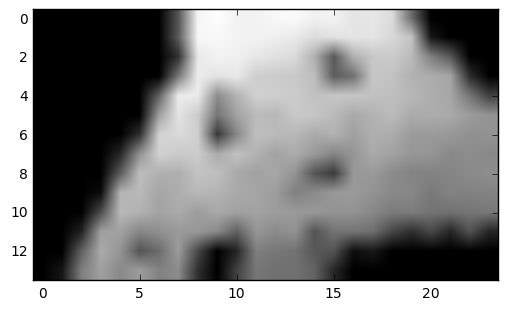

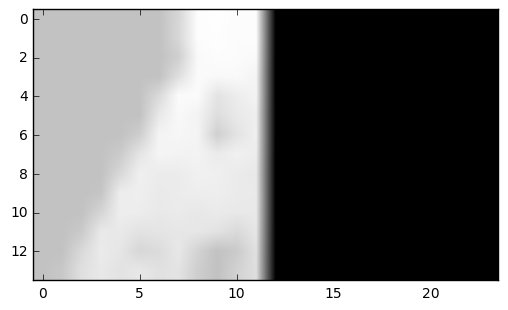

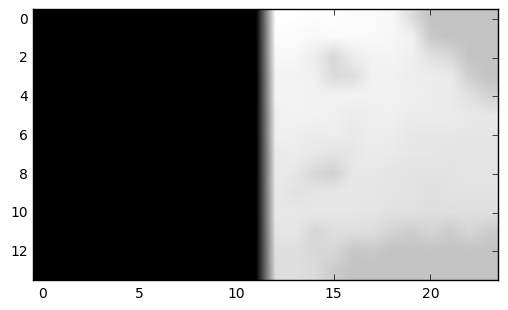

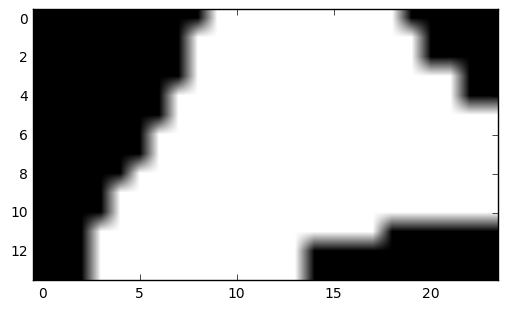

1 0
(14, 24)


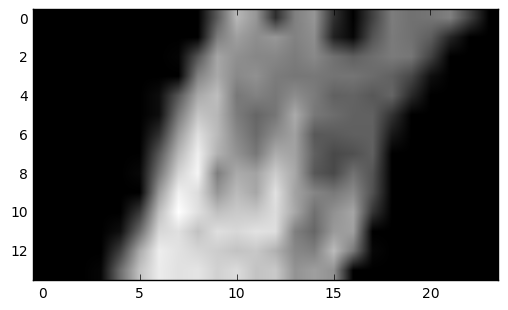

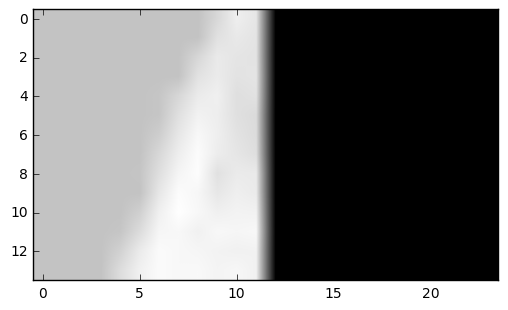

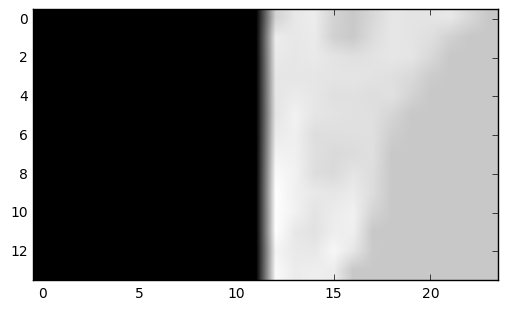

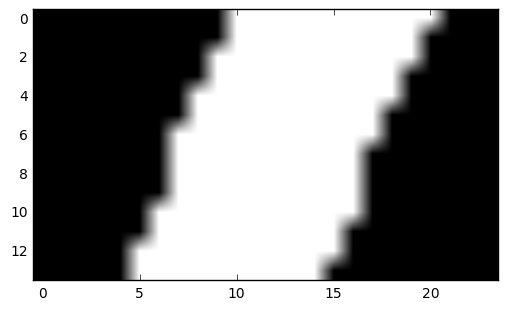

0 2
(14, 24)


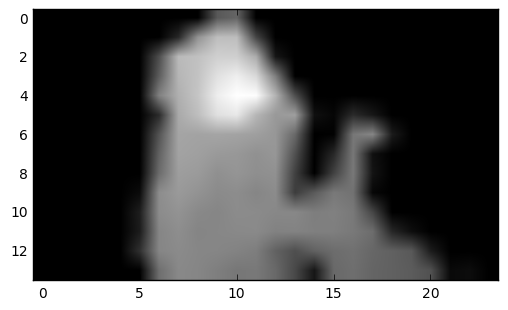

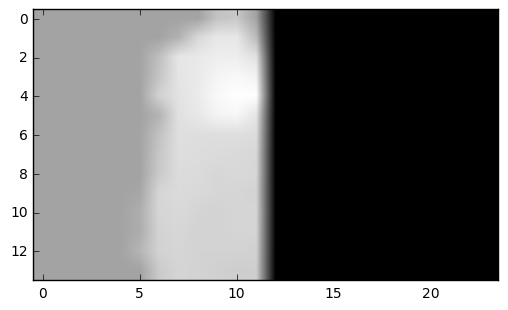

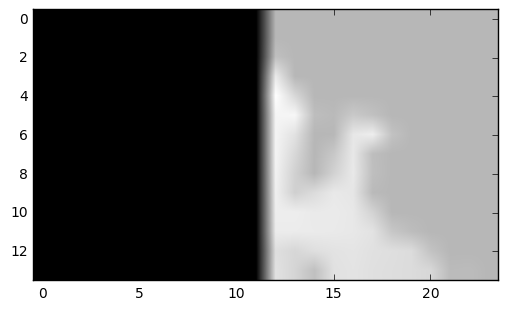

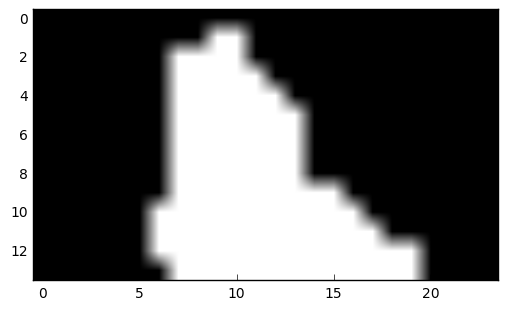

1 5
(14, 24)


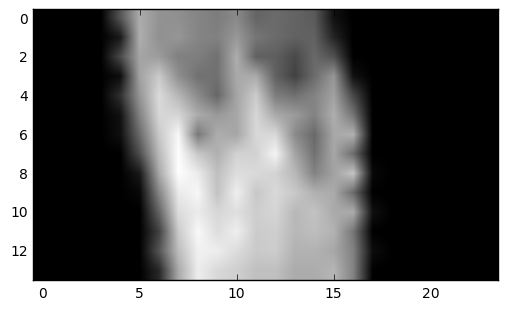

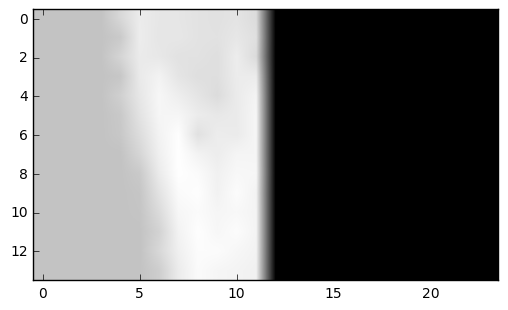

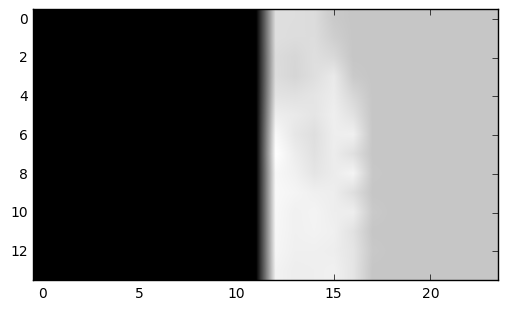

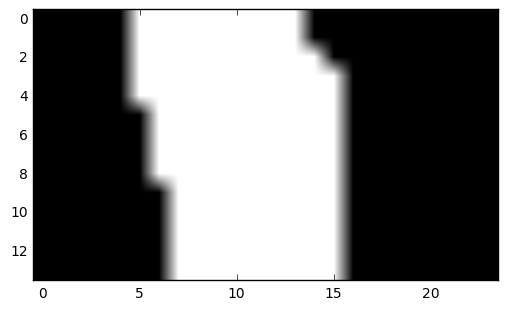

0 3
(14, 24)


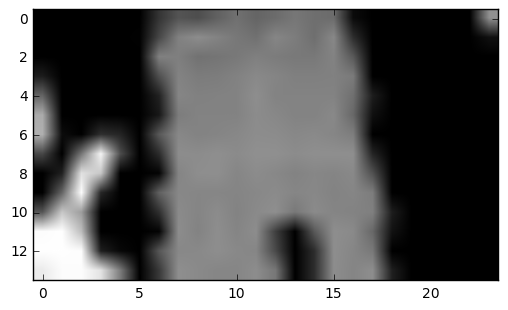

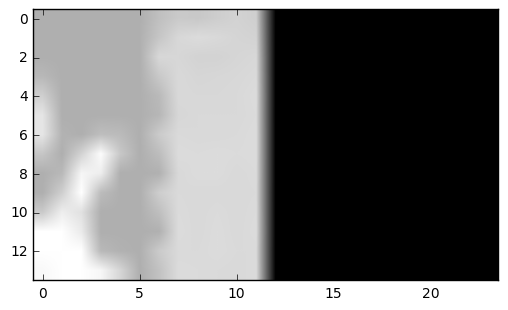

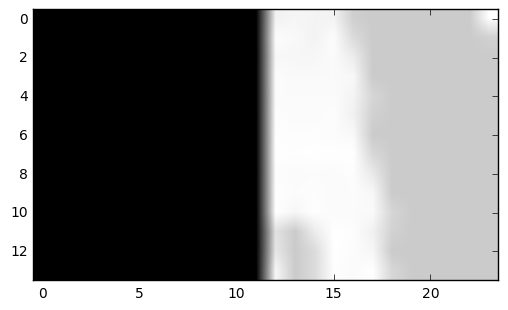

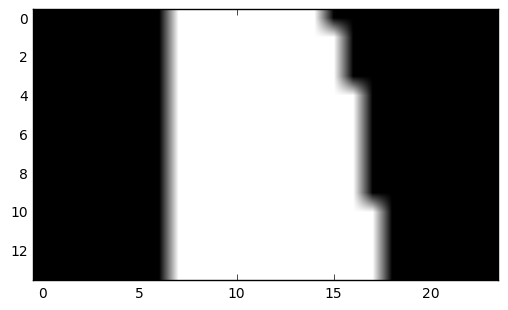

18 3
(14, 24)


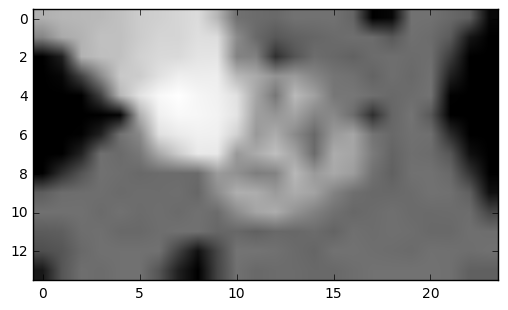

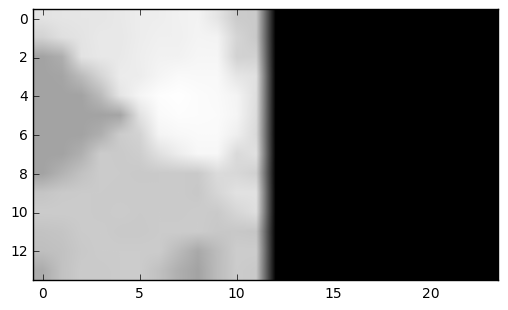

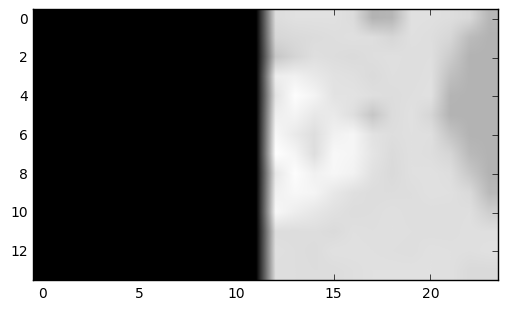

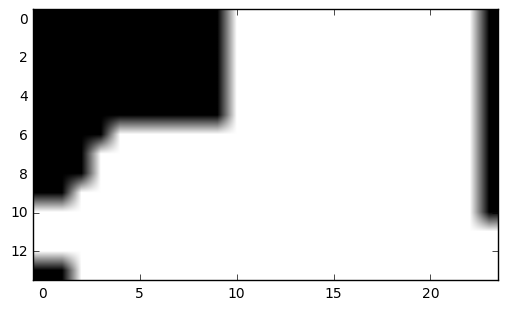

45 0
(14, 24)


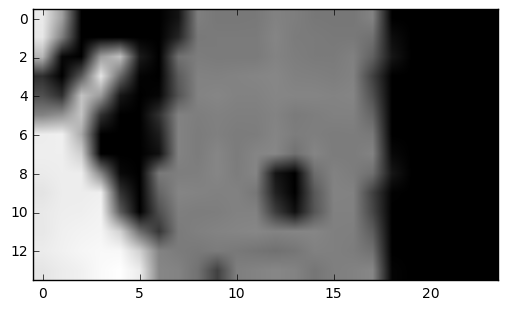

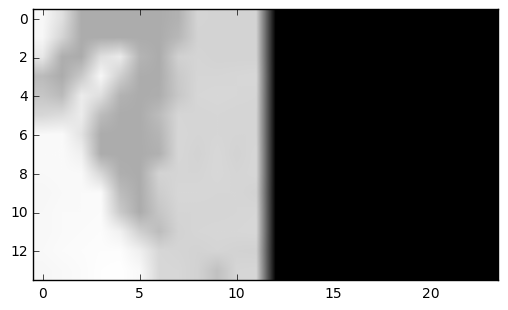

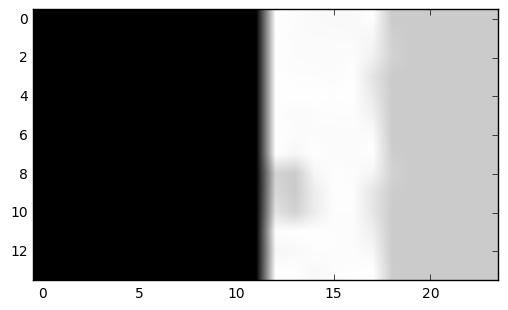

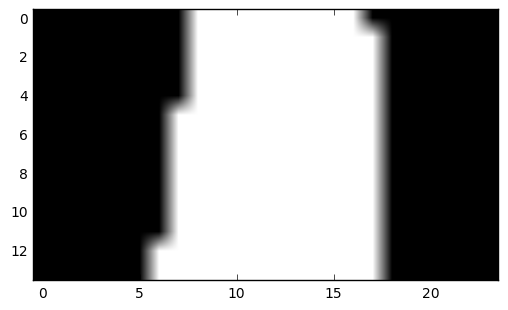

48 1
(14, 24)


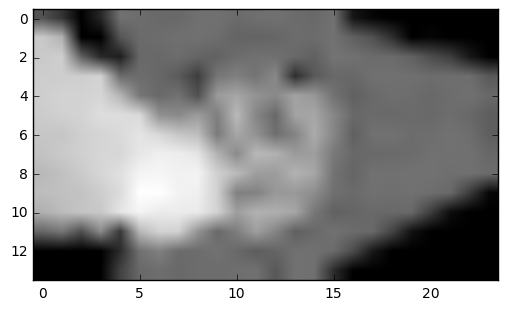

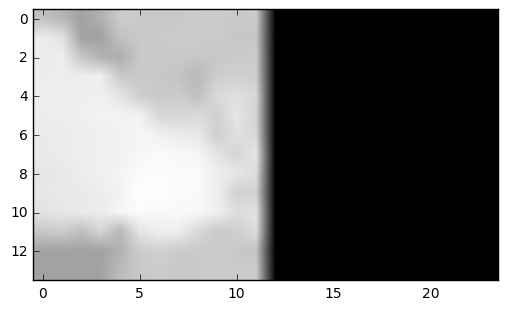

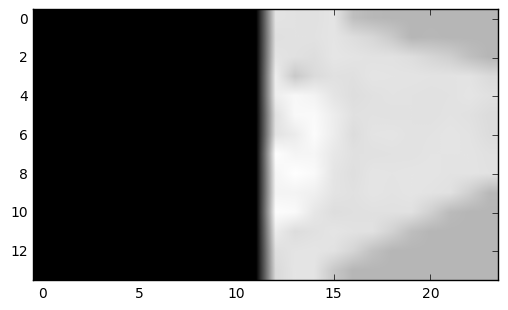

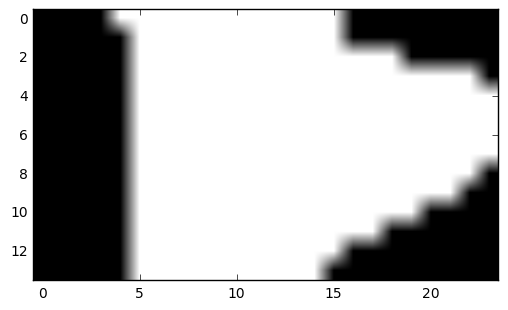

43 0
(14, 24)


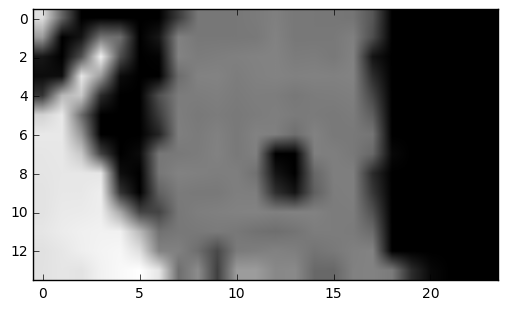

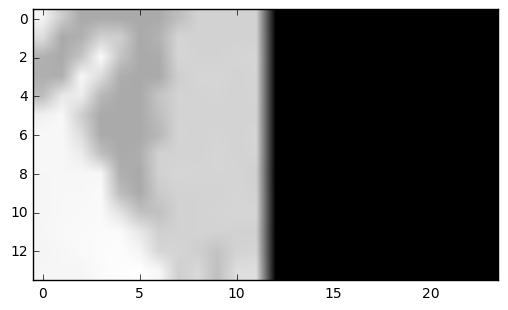

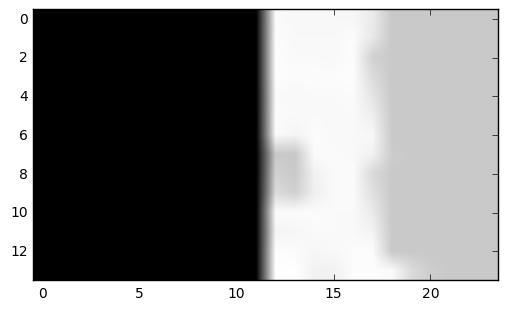

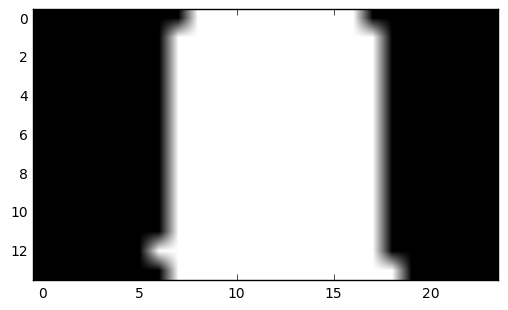

47 0
(14, 24)


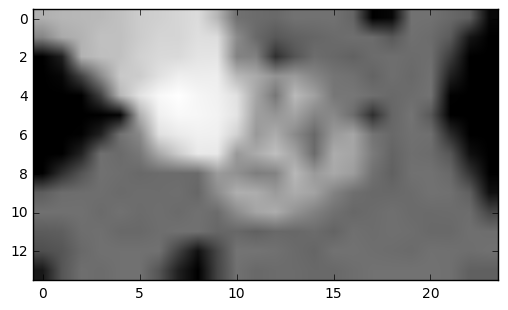

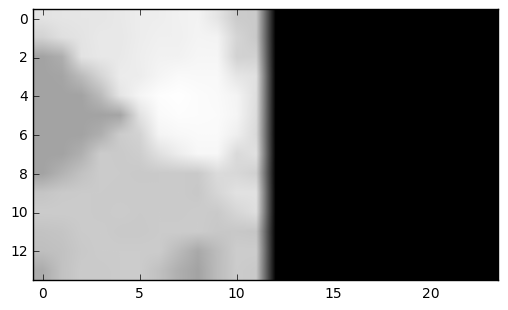

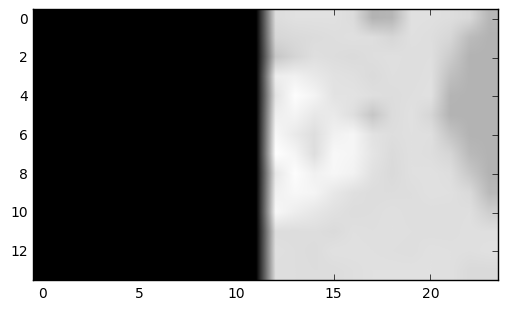

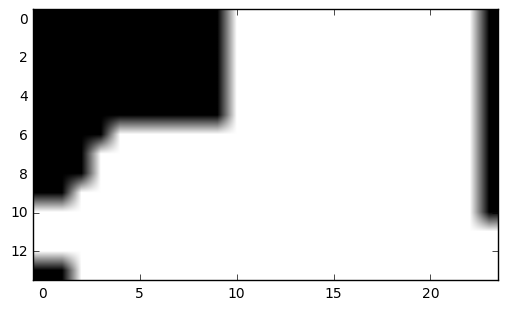

45 0
(14, 24)


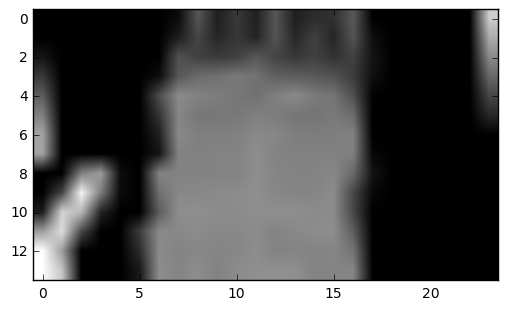

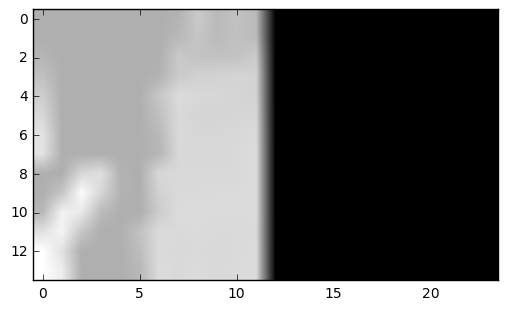

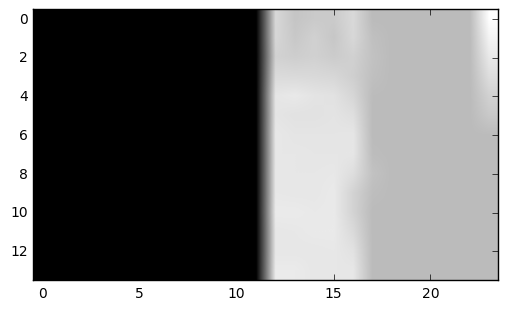

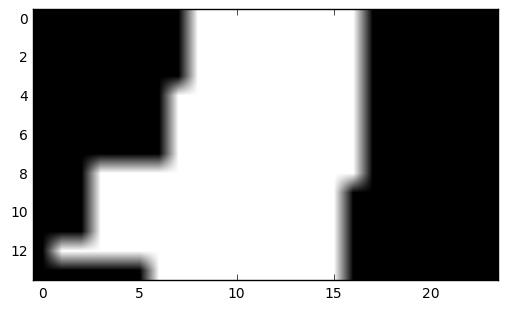

12 5
(14, 24)


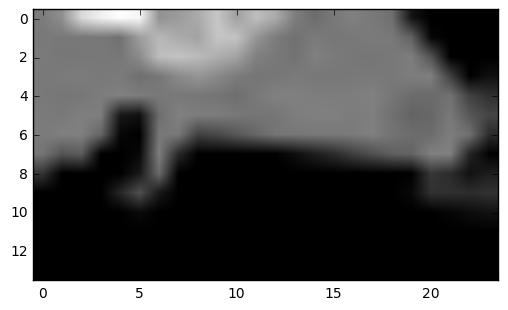

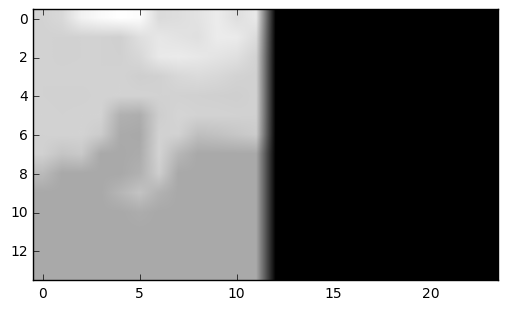

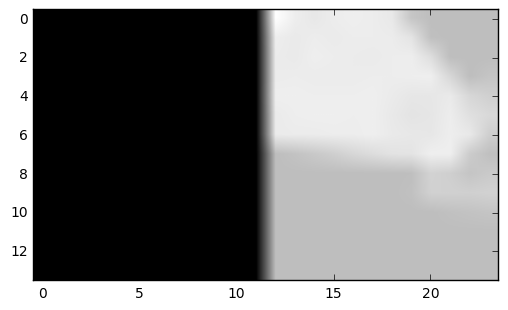

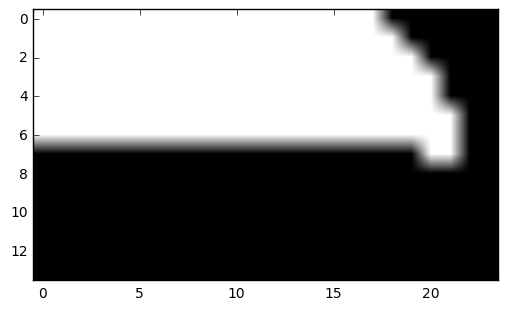

0 0
(14, 24)


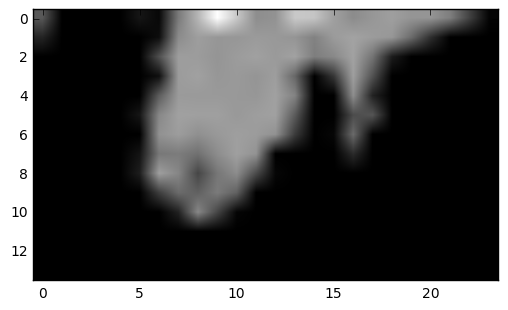

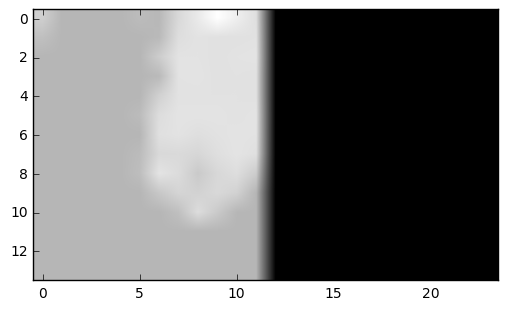

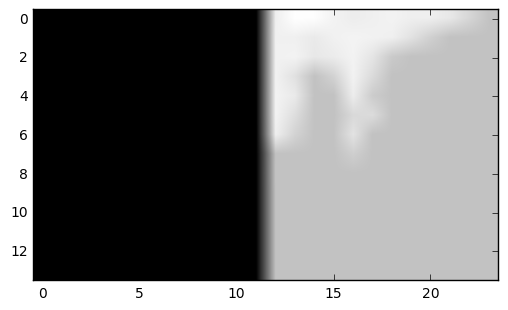

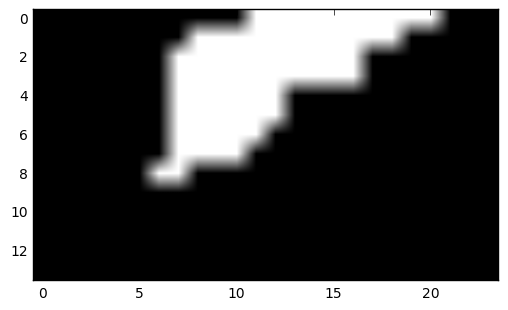

3 1
(14, 24)


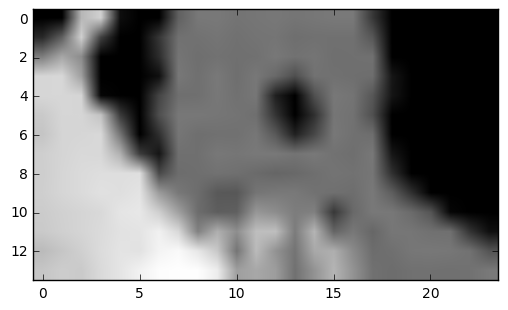

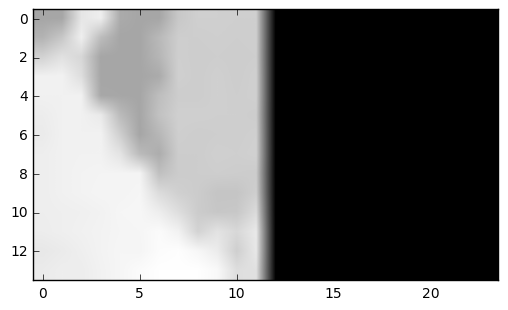

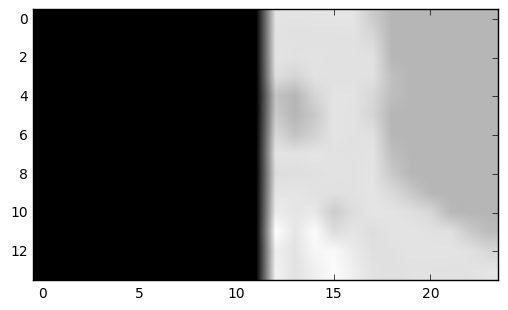

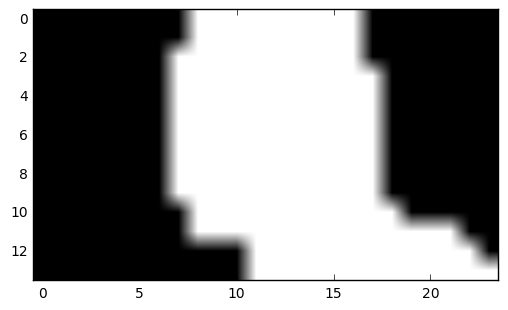

77 1
(14, 24)


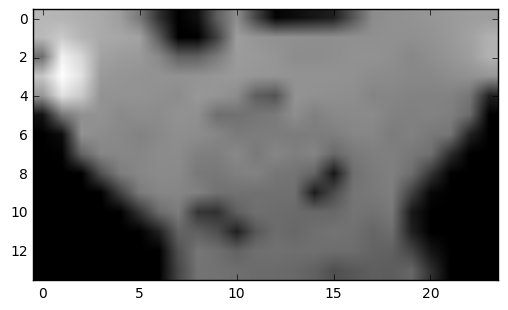

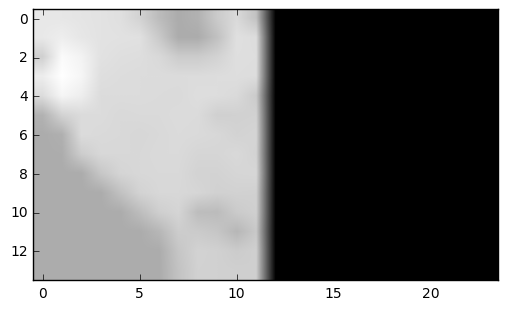

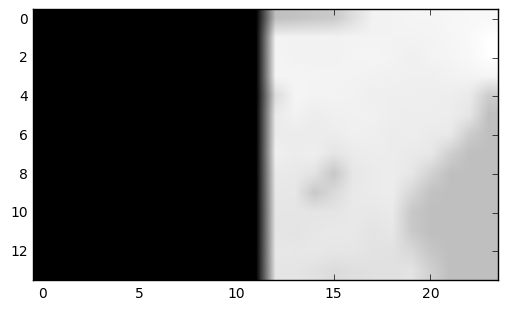

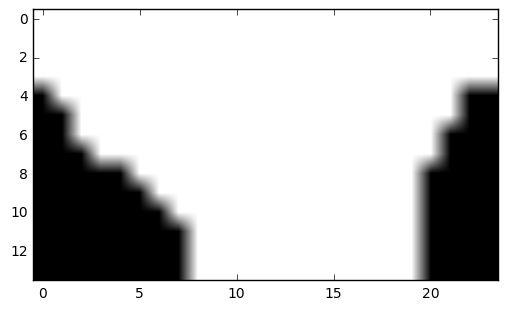

4 2
(14, 24)


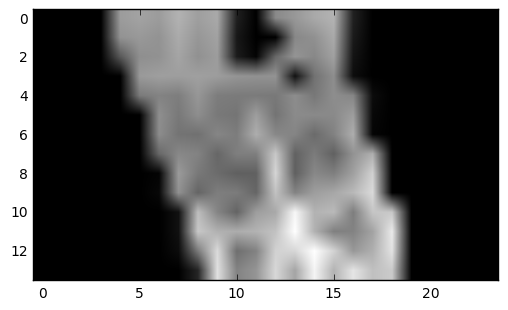

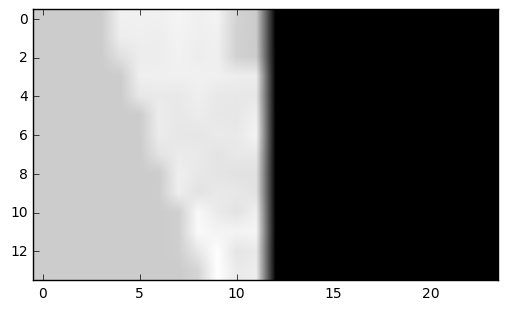

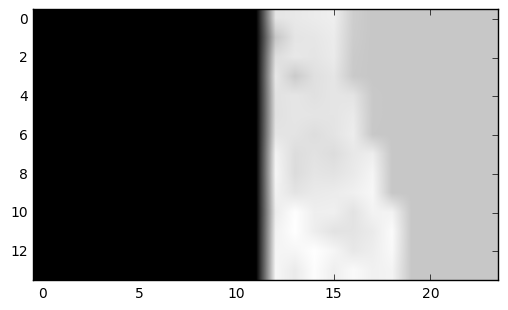

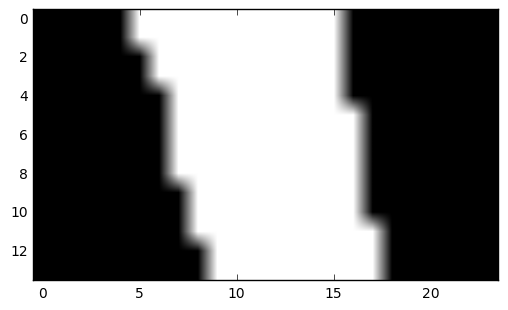

7 8
(14, 24)


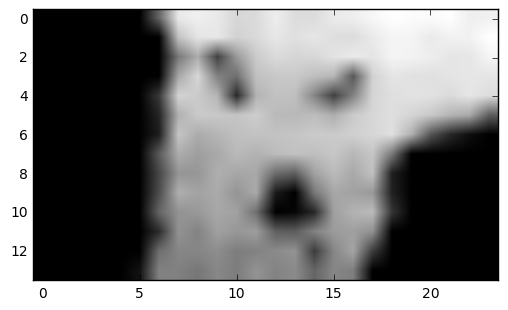

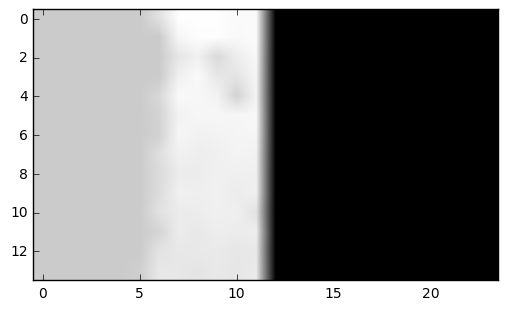

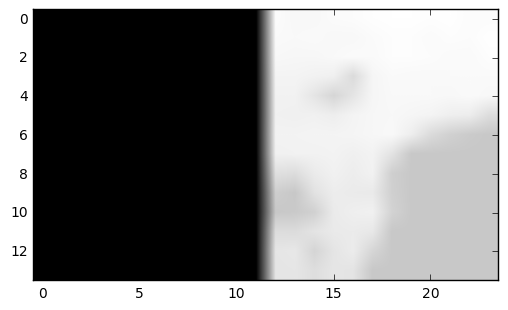

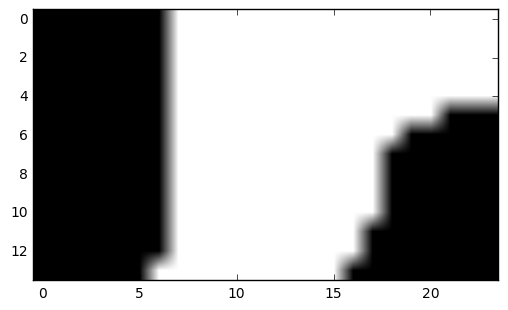

0 3
(14, 24)


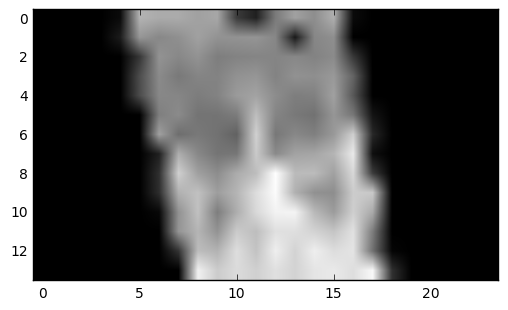

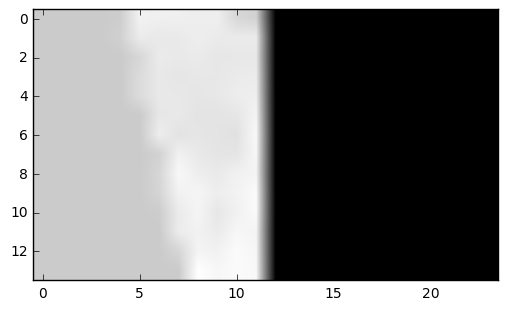

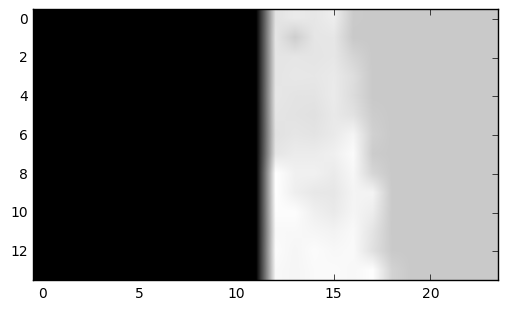

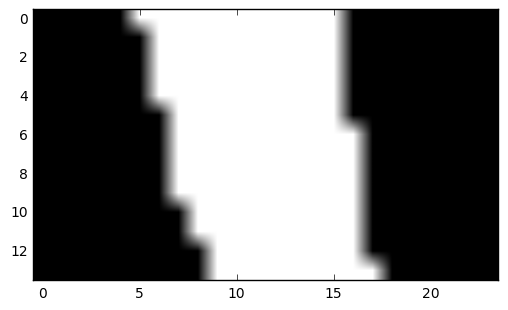

4 1
(14, 24)


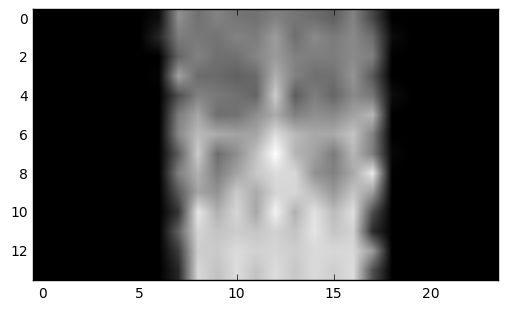

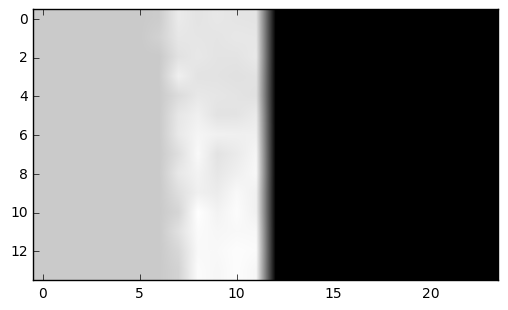

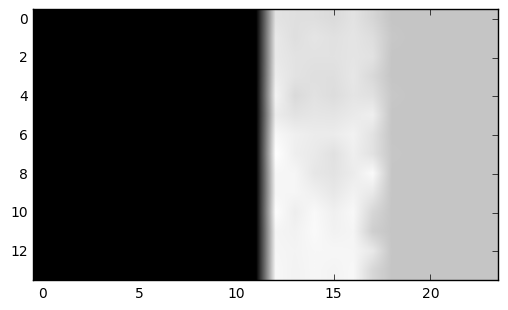

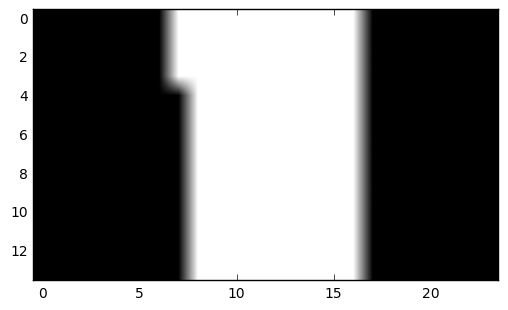

0 2
(14, 24)


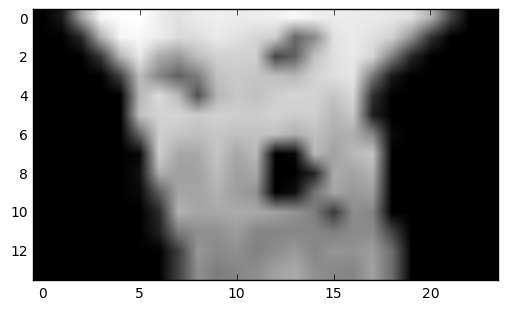

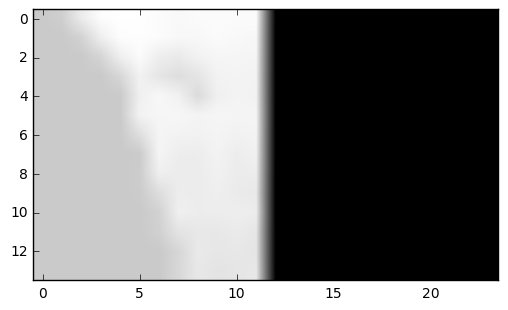

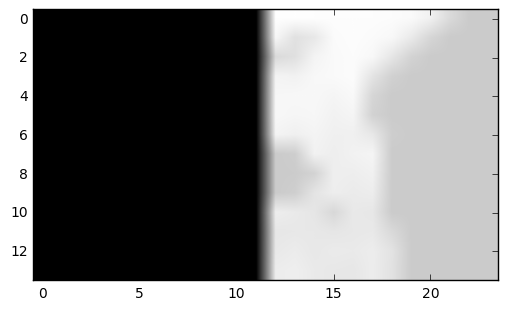

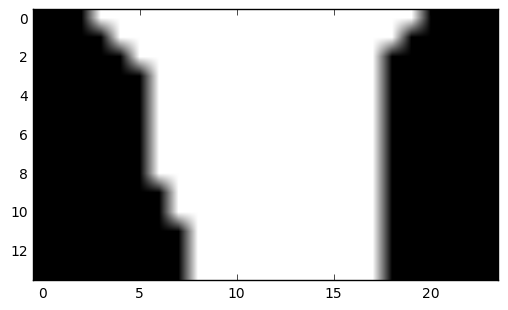

3 1
(14, 24)


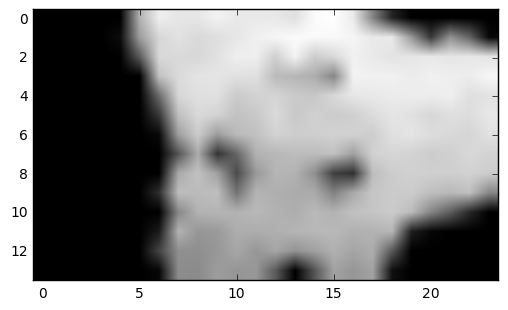

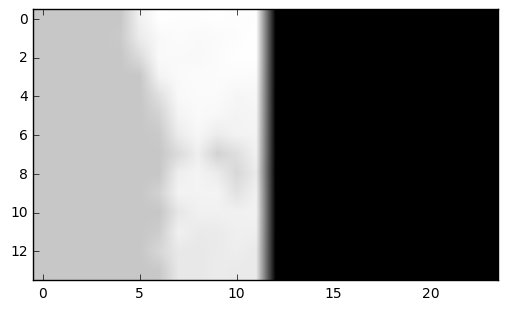

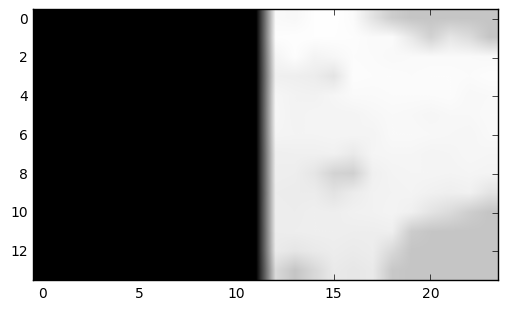

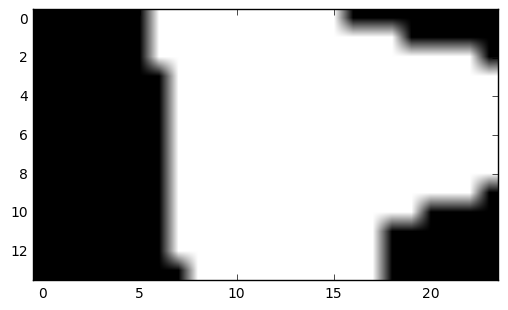

1 2
(14, 24)


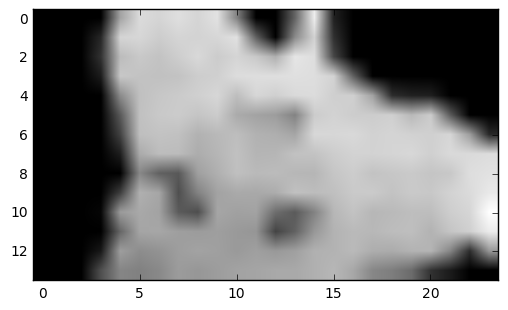

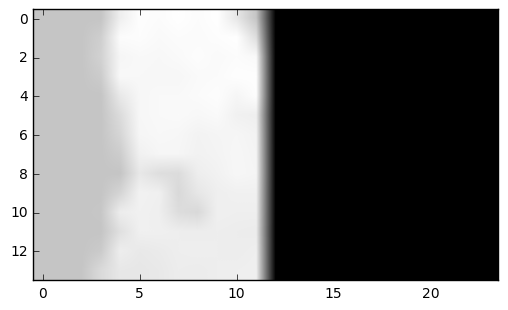

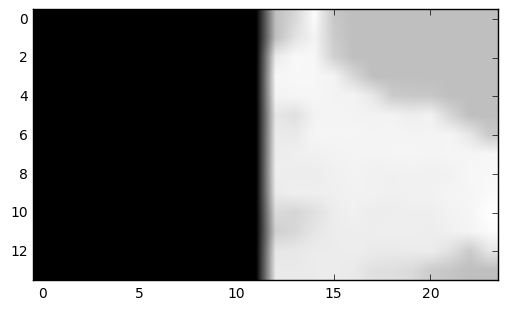

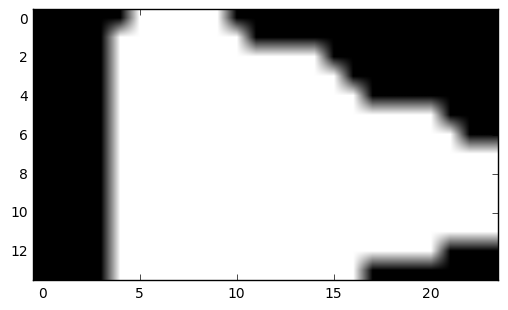

0 2
(14, 24)


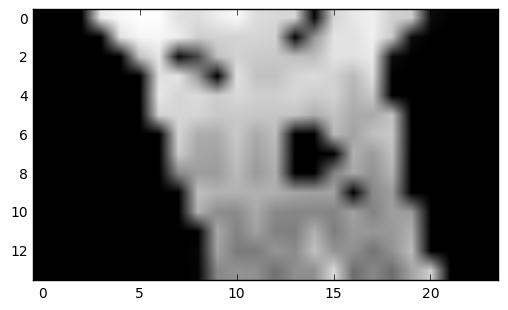

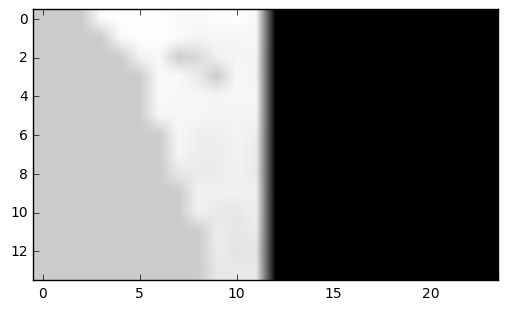

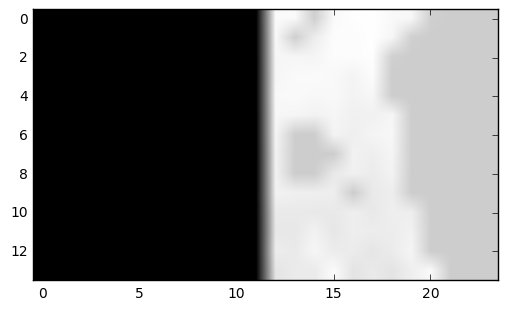

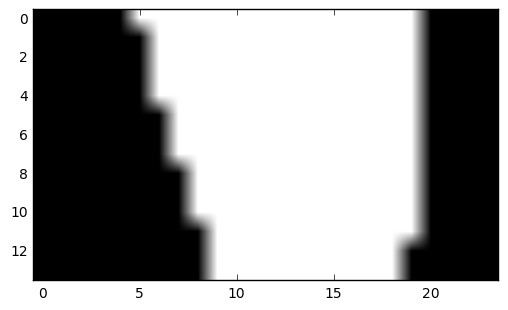

6 3
(14, 24)


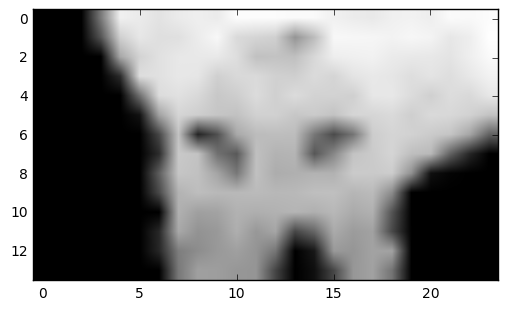

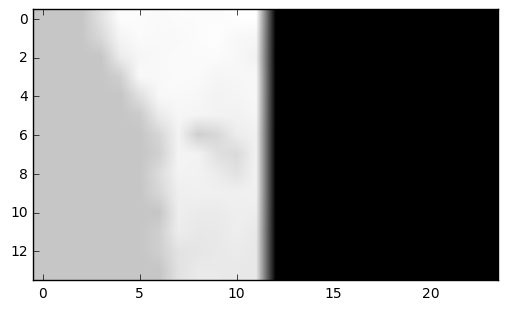

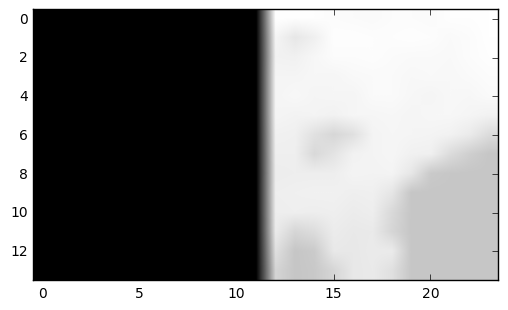

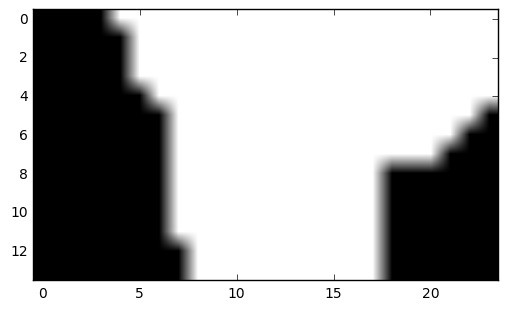

1 2
(14, 24)


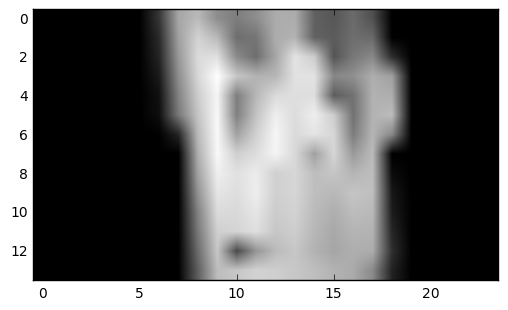

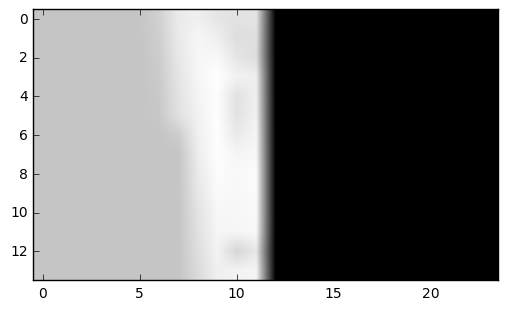

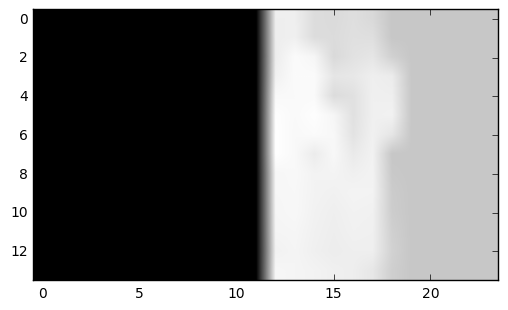

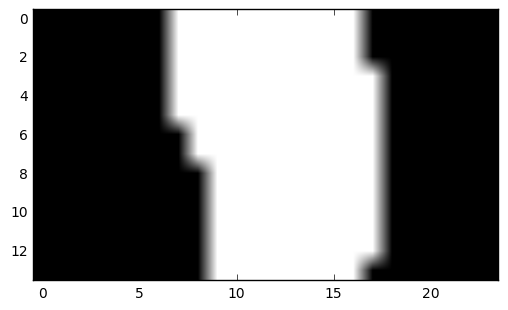

0 1
(14, 24)


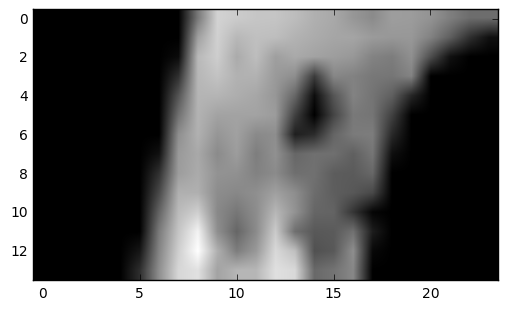

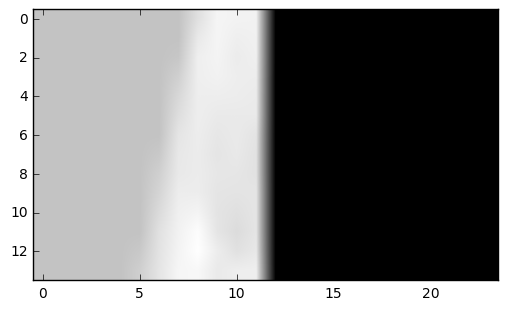

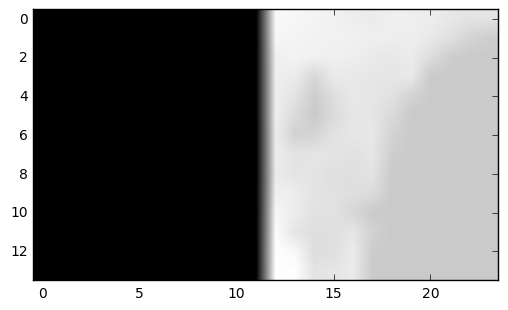

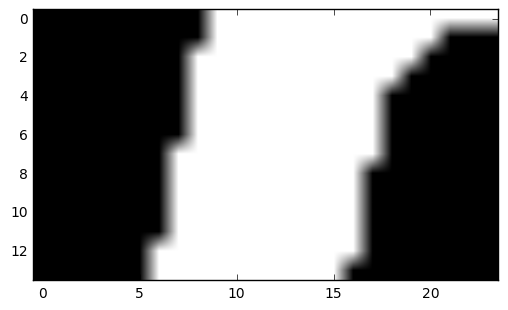

0 2
(14, 24)


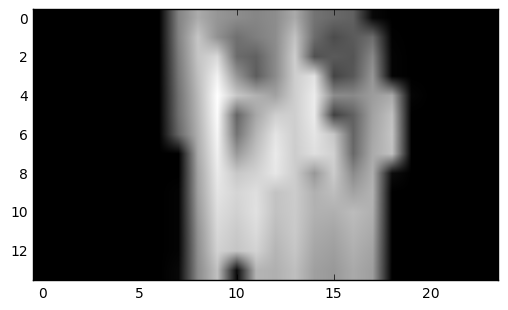

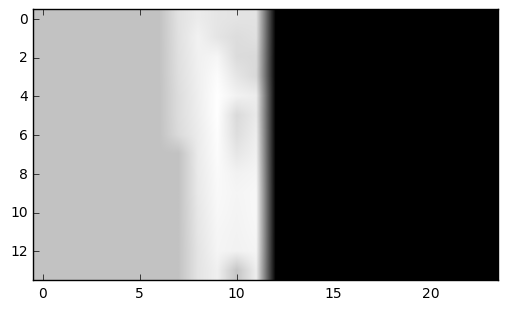

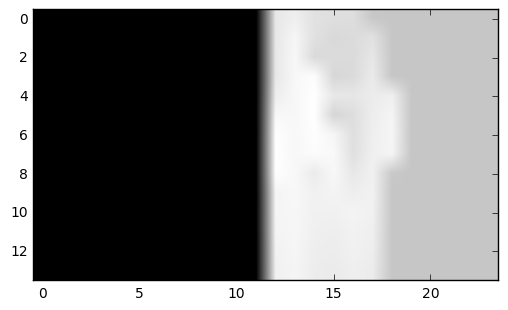

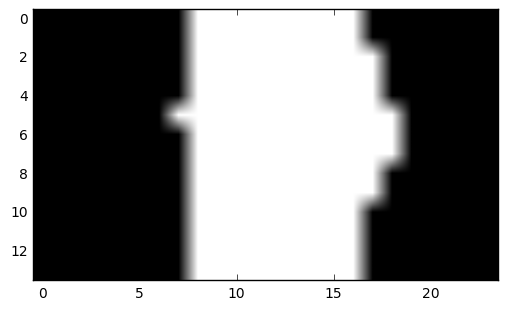

0 3
(14, 24)


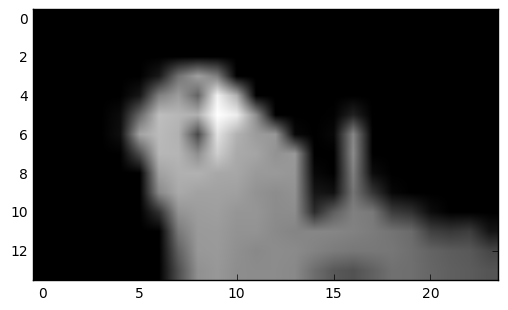

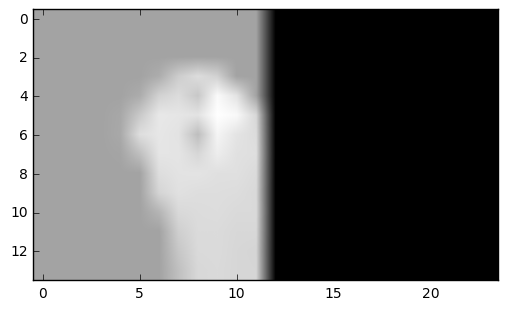

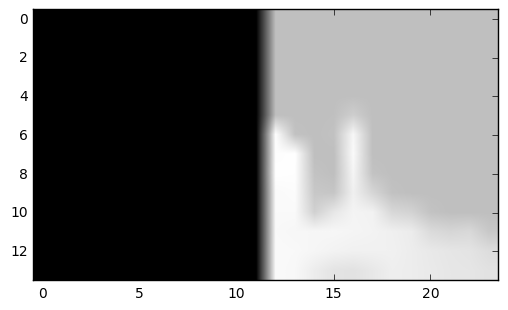

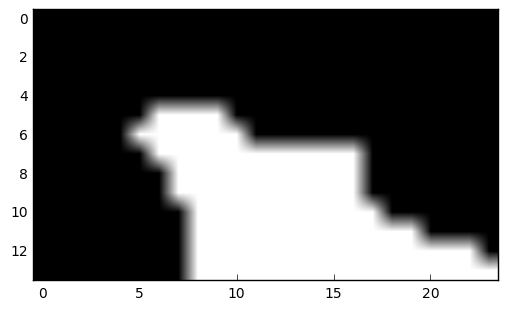

3 2
(14, 24)


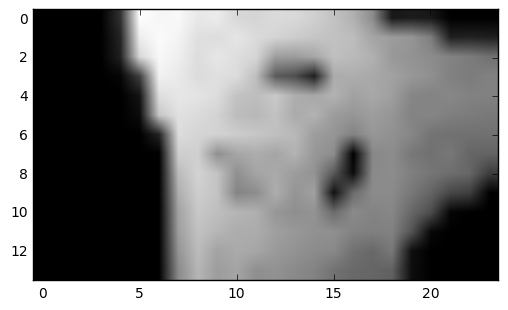

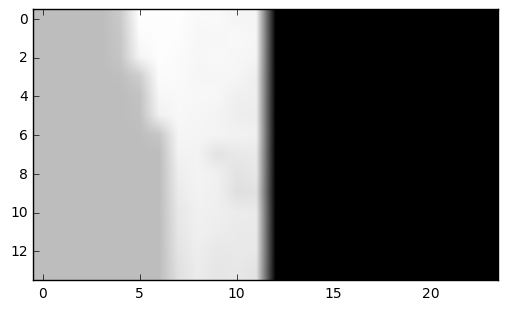

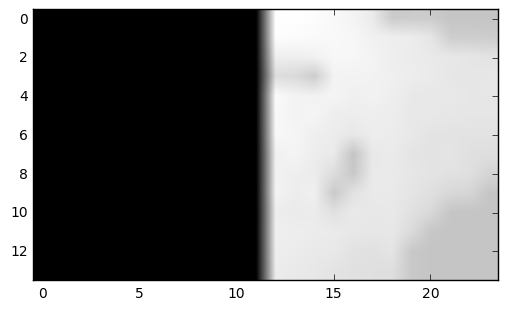

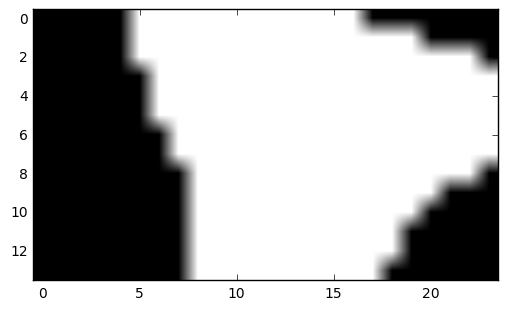

0 0
(14, 24)


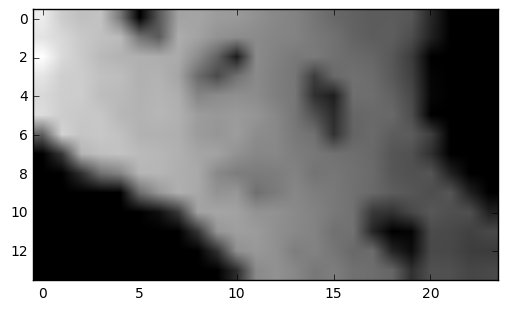

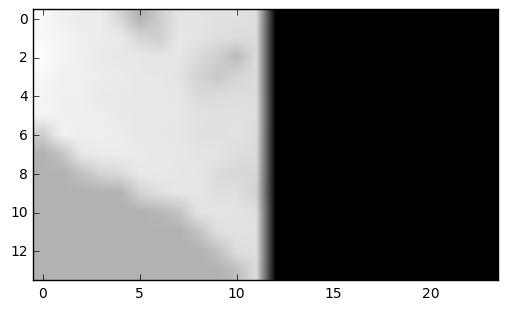

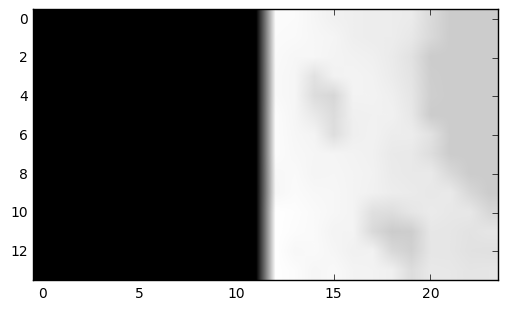

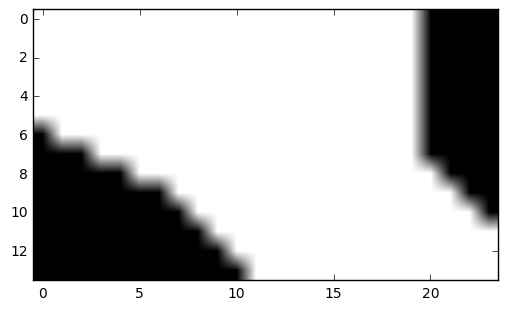

2 0
(14, 24)


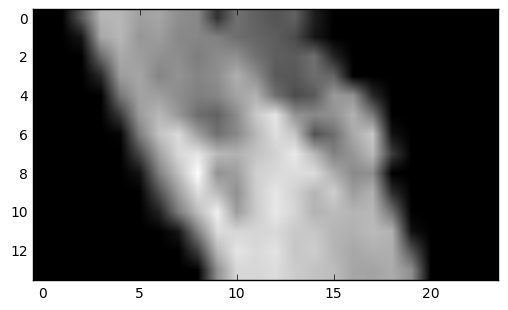

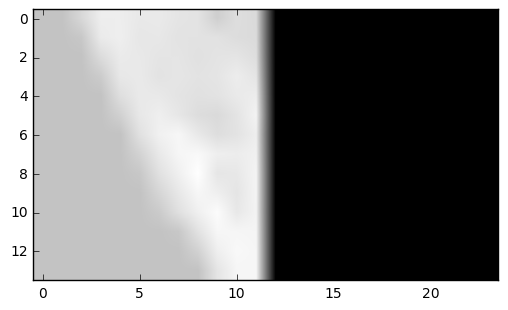

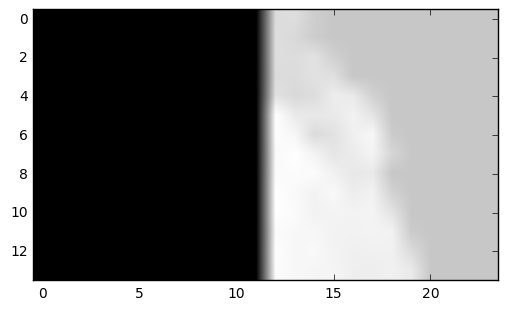

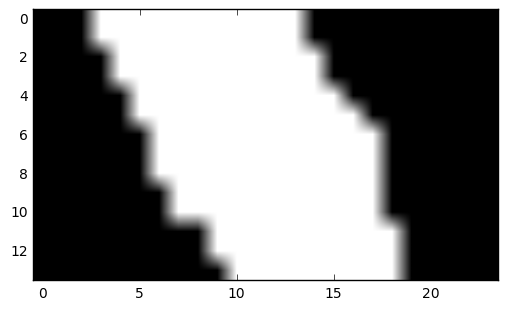

0 0
(14, 24)


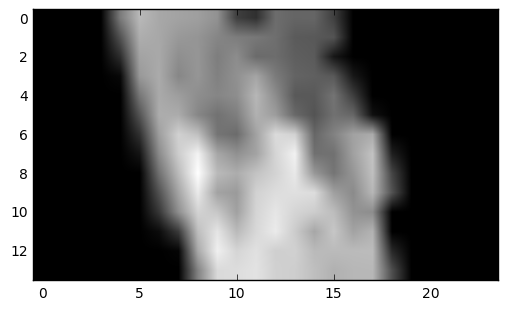

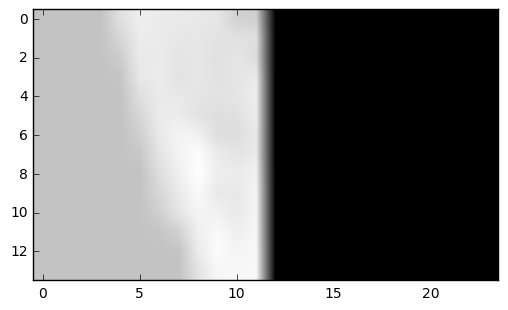

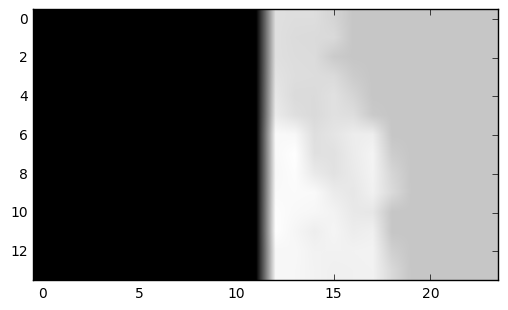

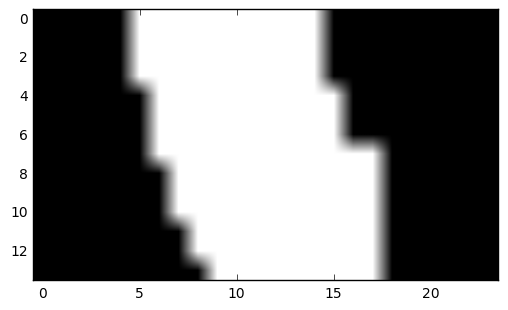

0 2
(14, 24)


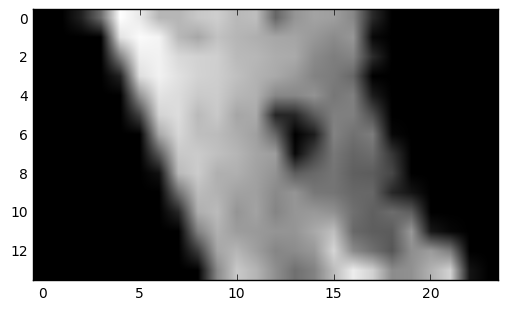

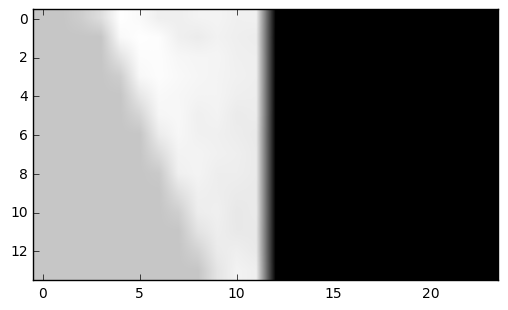

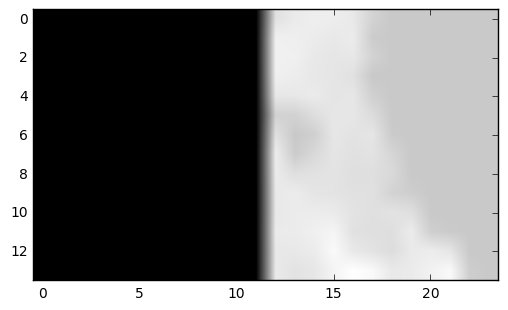

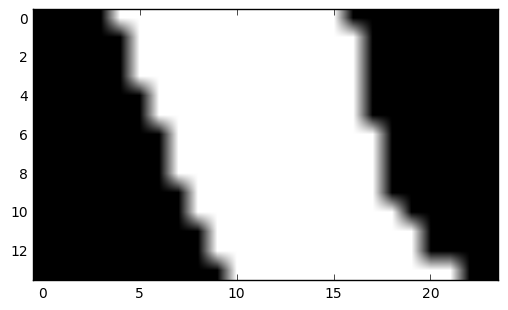

1 2
(14, 24)


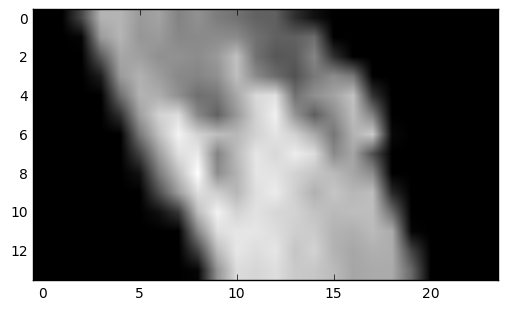

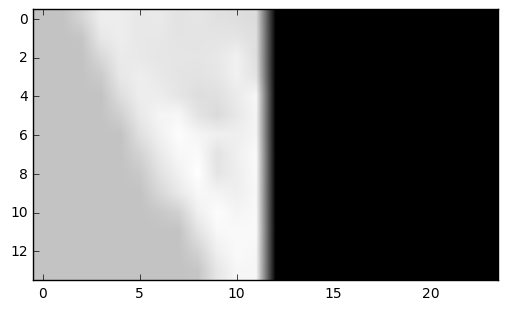

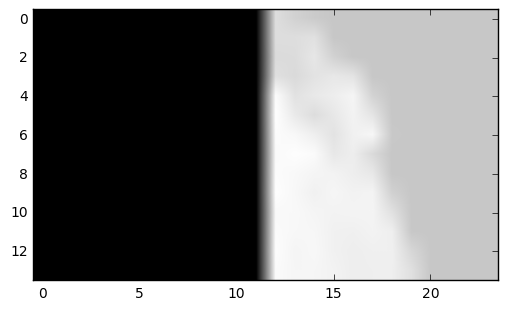

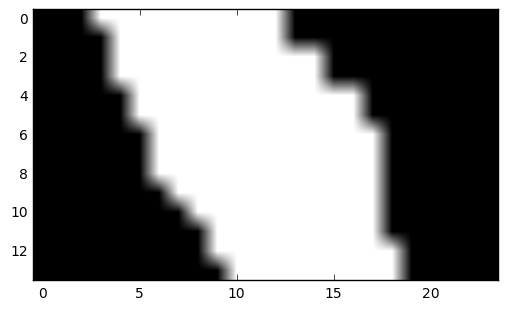

0 0
(14, 24)


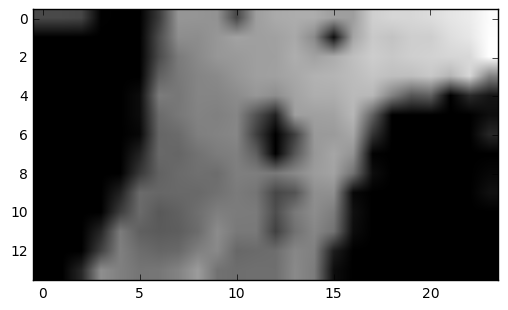

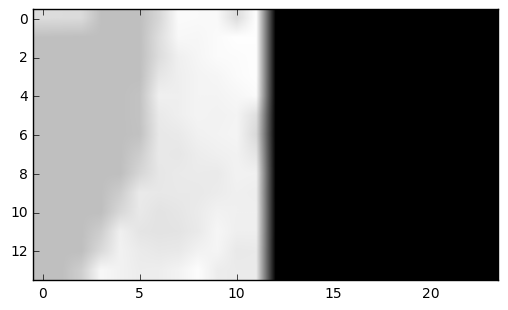

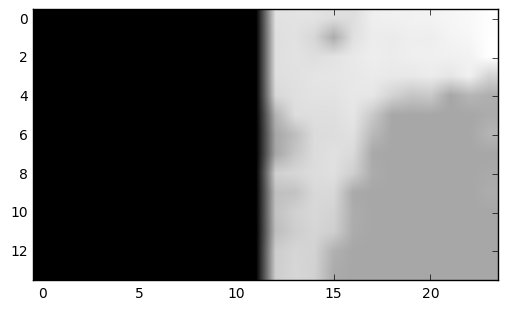

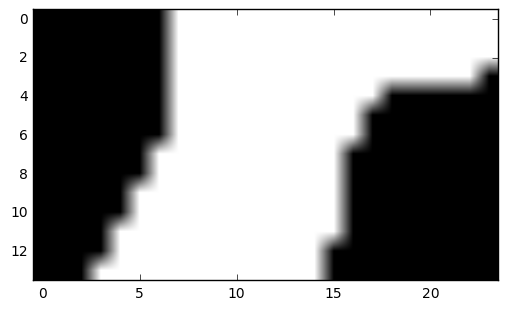

1 1
(14, 24)


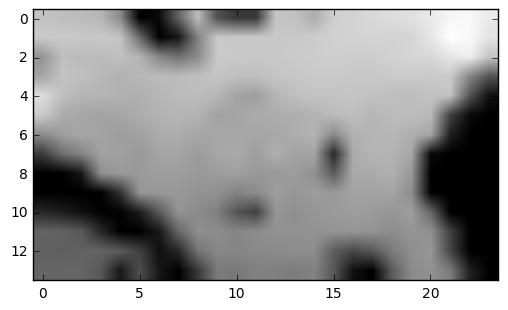

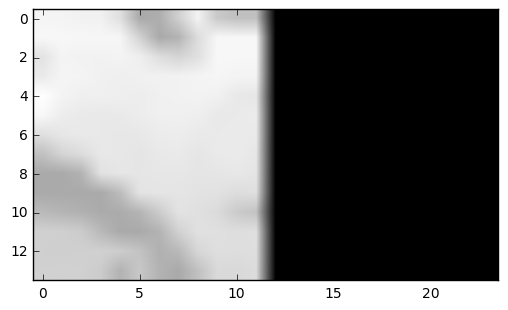

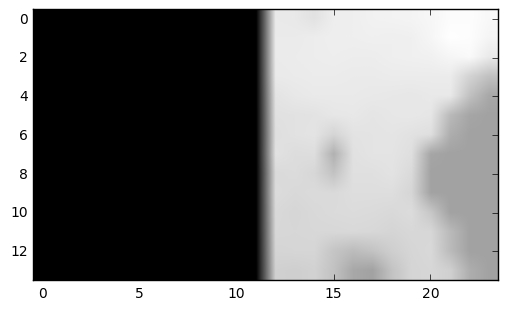

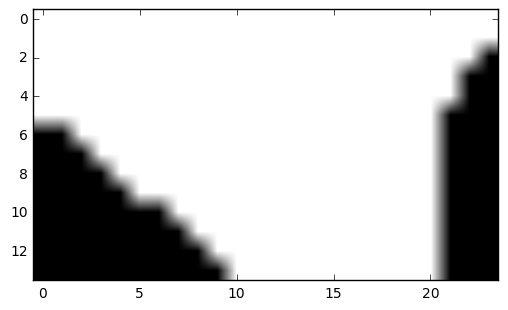

1 1
(14, 24)


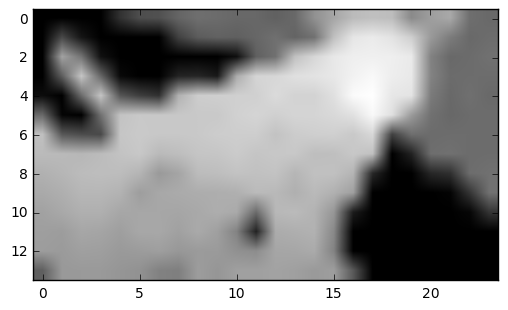

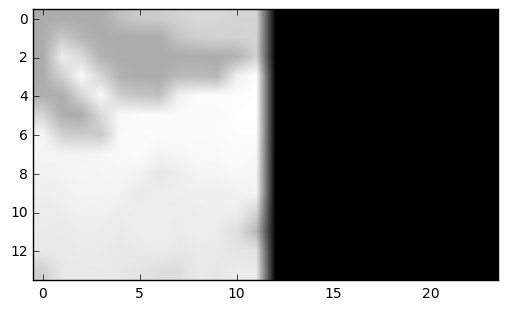

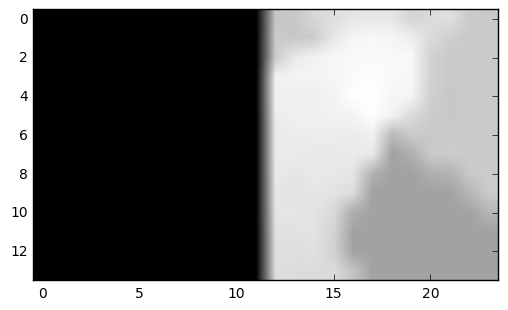

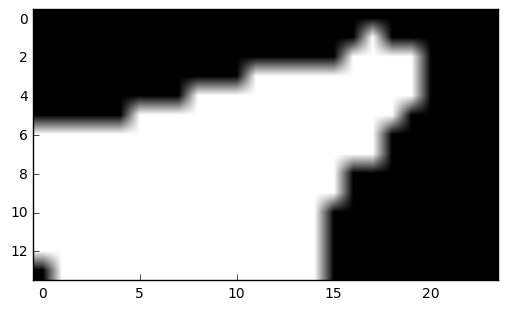

4 5
(14, 24)


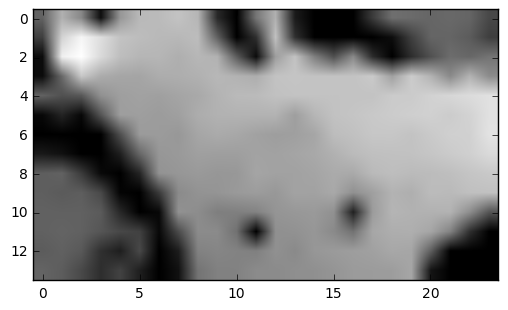

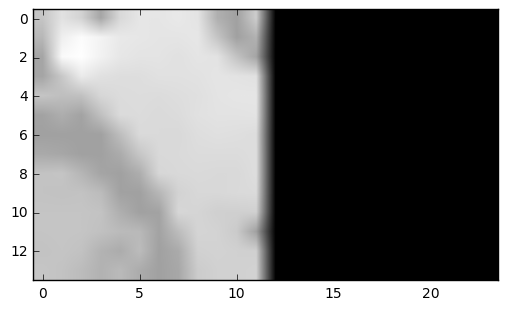

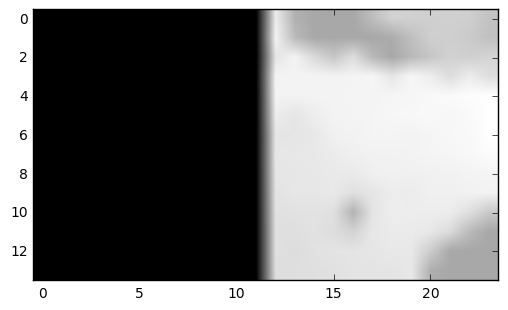

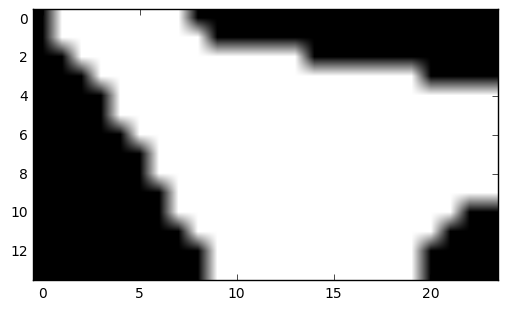

3 4
(14, 24)


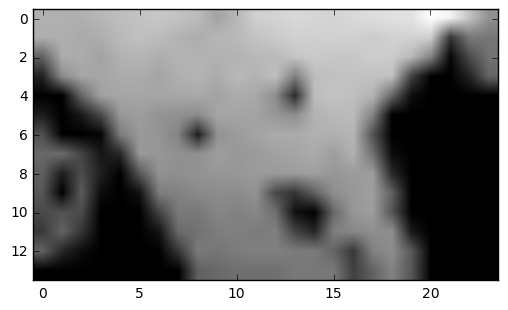

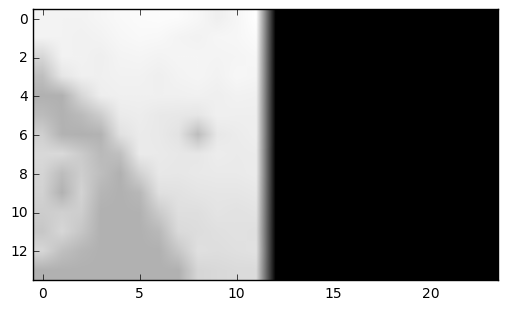

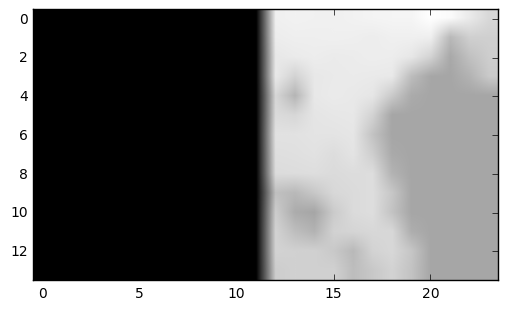

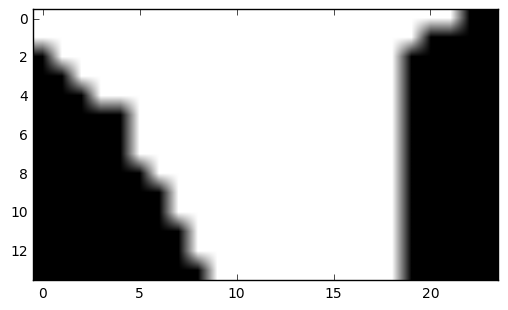

0 3
(14, 24)


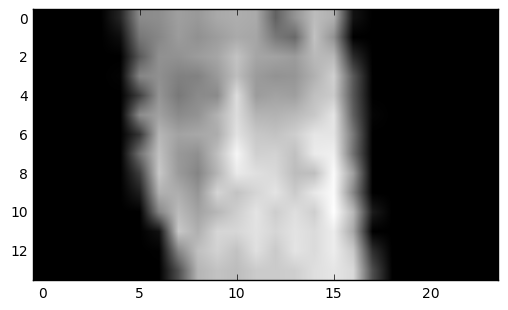

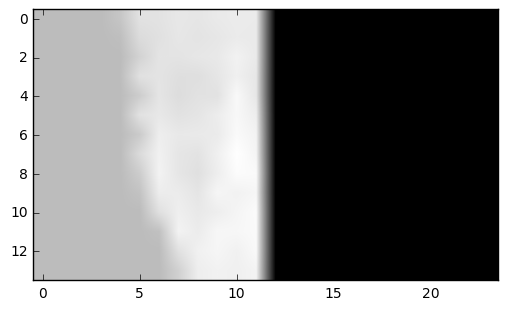

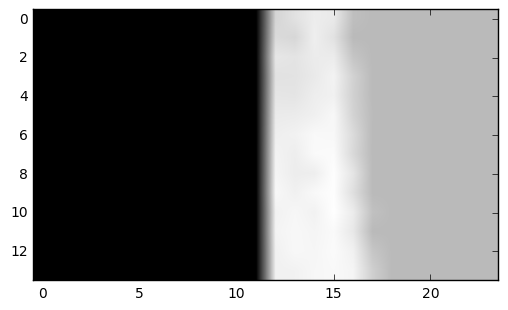

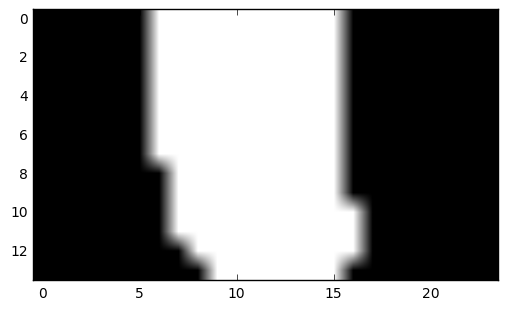

2 1
(14, 24)


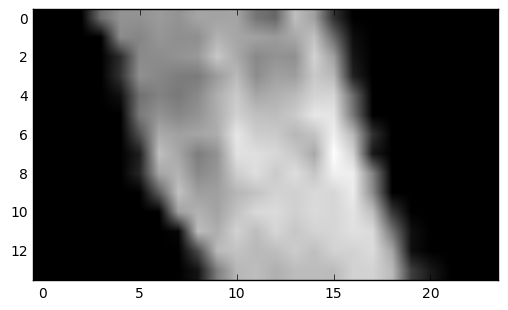

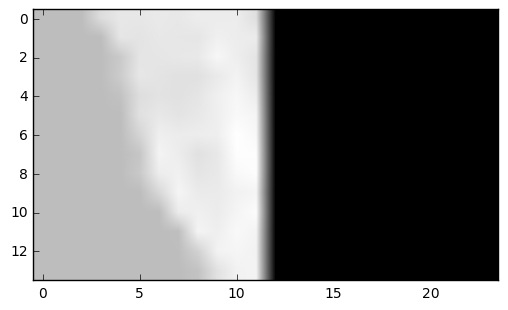

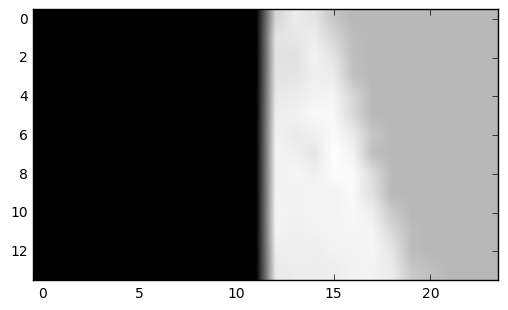

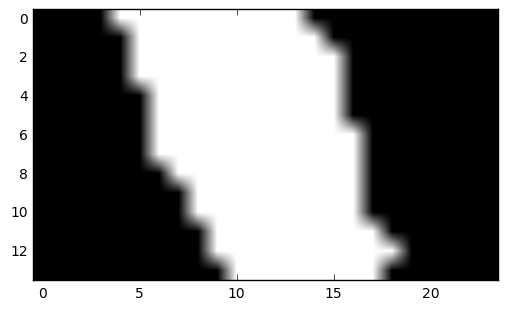

2 0
(14, 24)


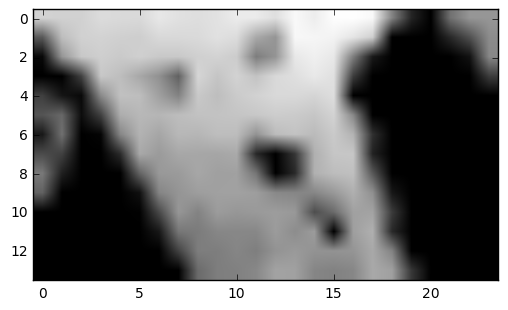

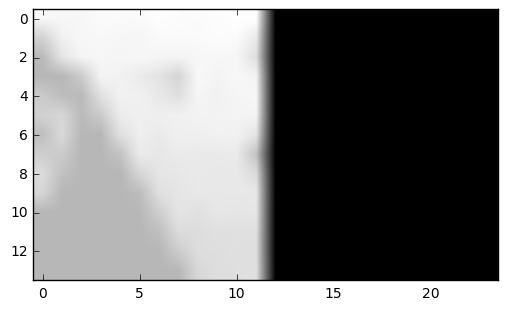

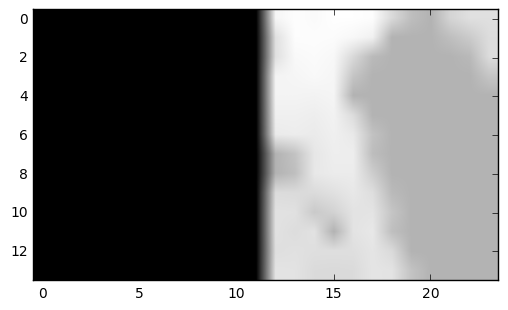

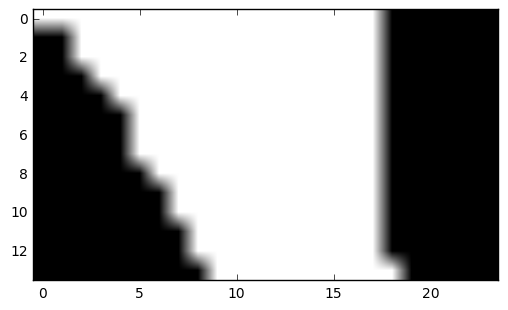

1 0
(14, 24)


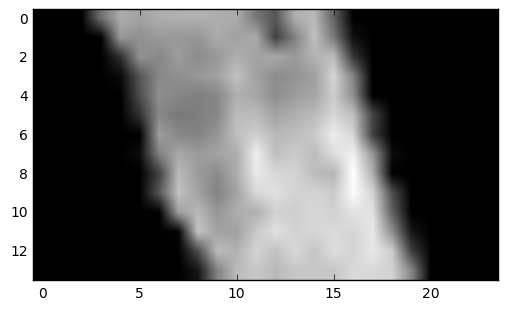

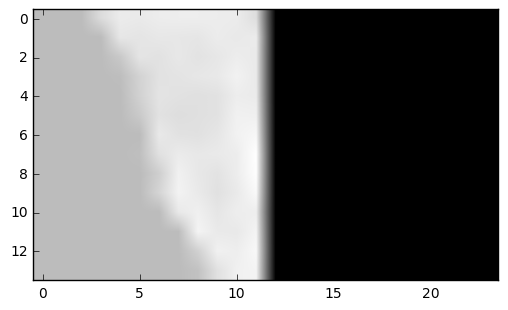

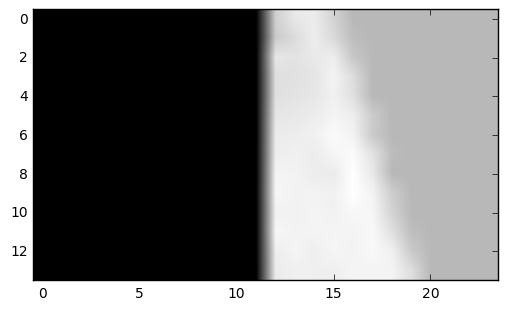

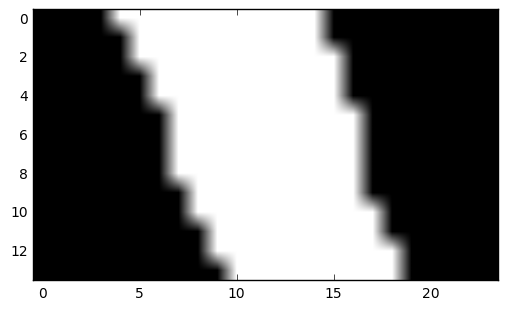

4 1
(14, 24)


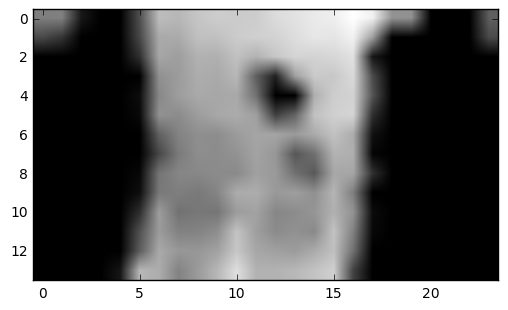

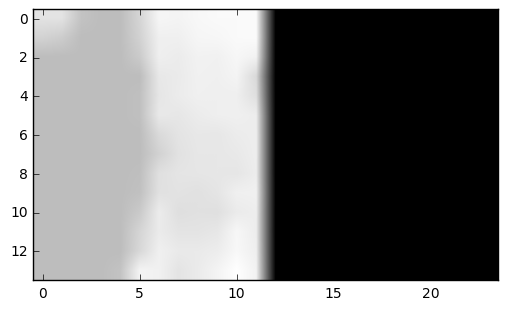

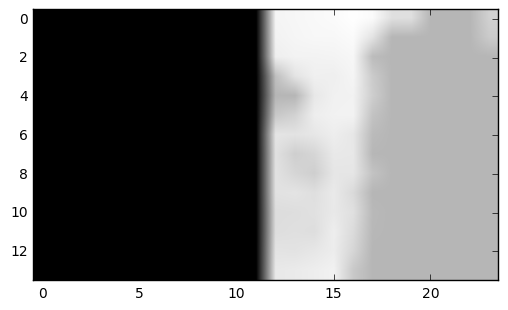

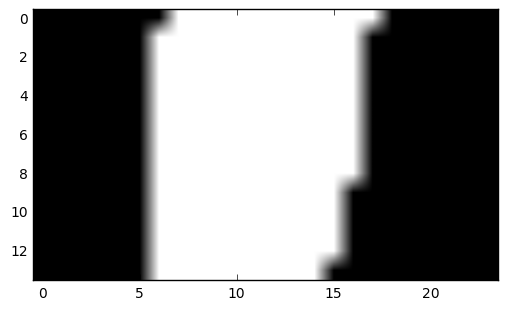

2 1
(14, 24)


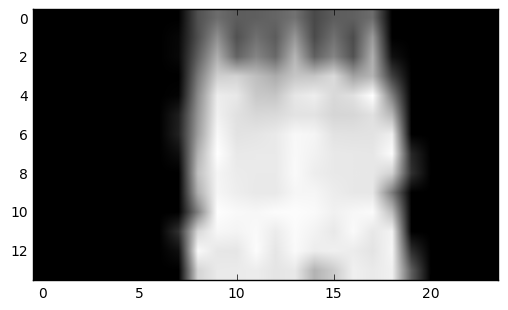

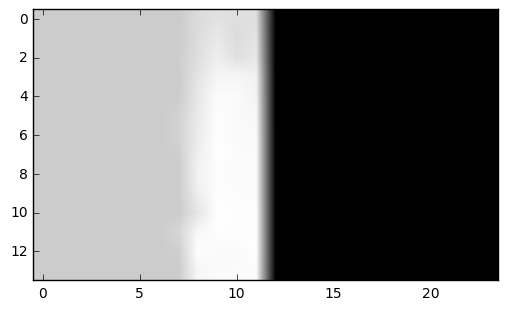

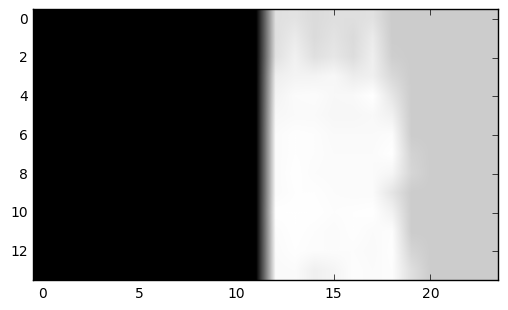

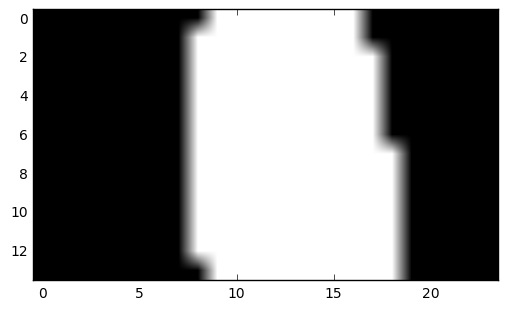

1 1
(14, 24)


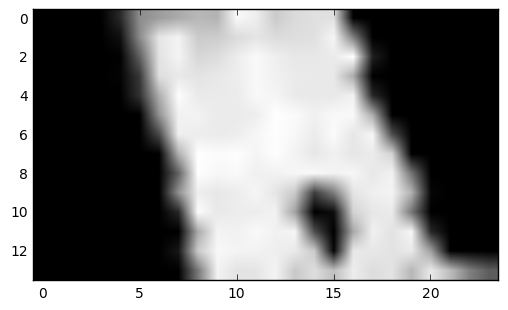

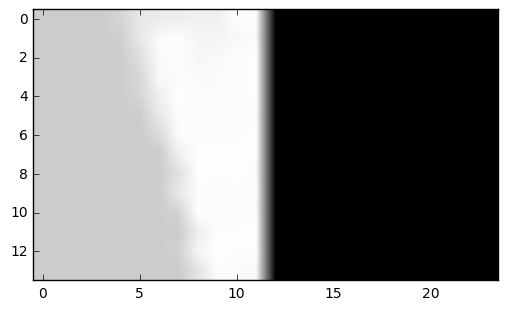

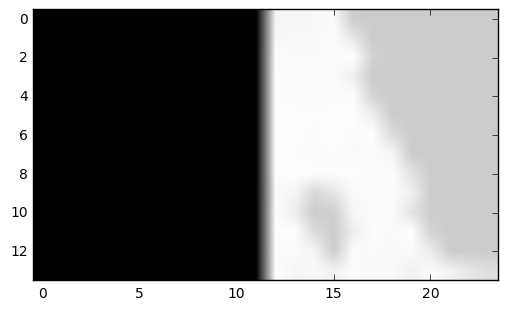

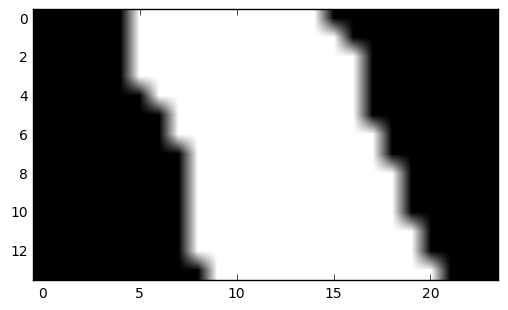

0 1
(14, 24)


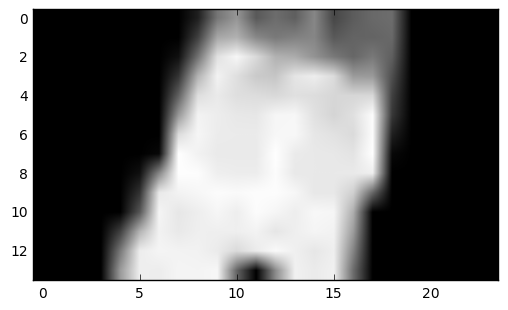

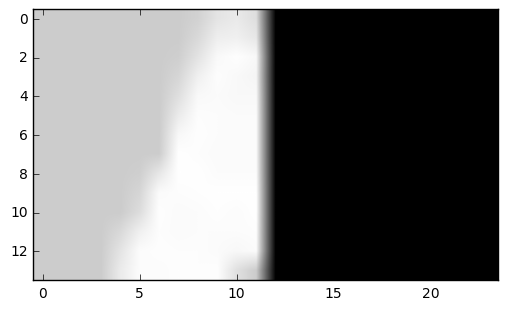

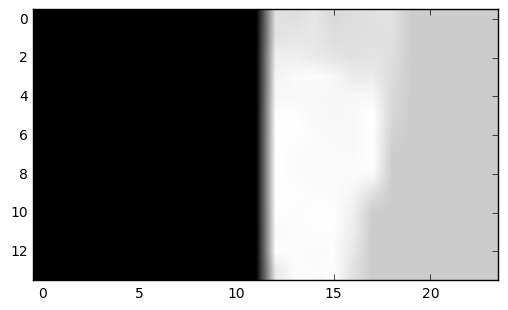

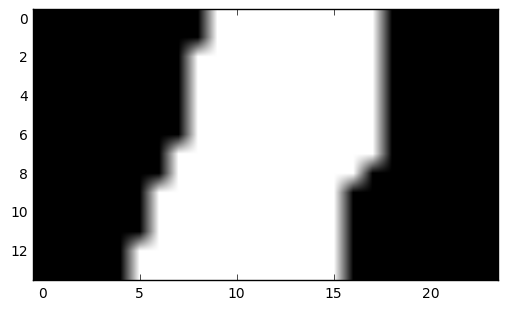

0 2
(14, 24)


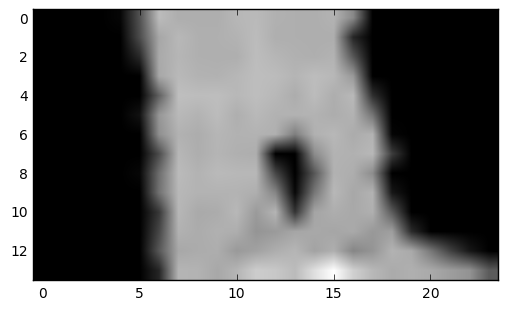

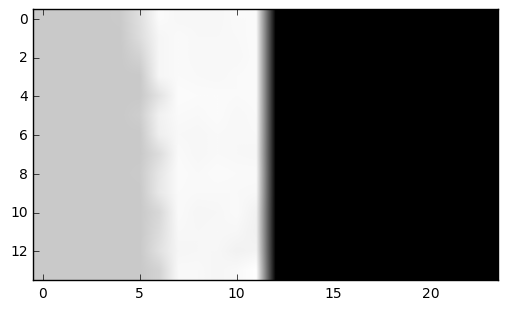

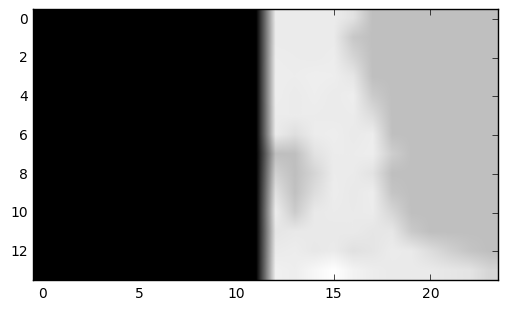

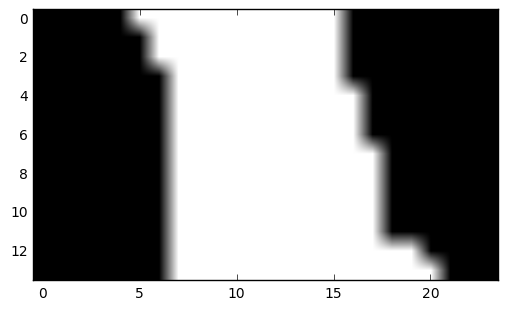

0 1
(14, 24)


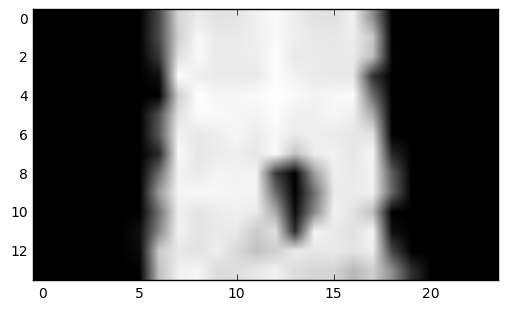

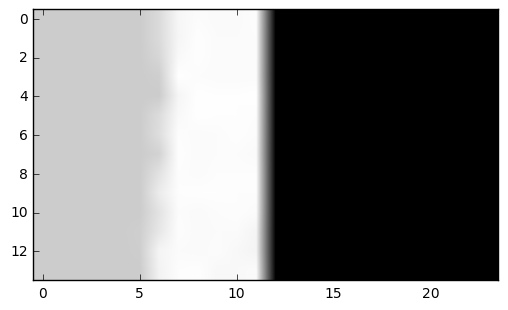

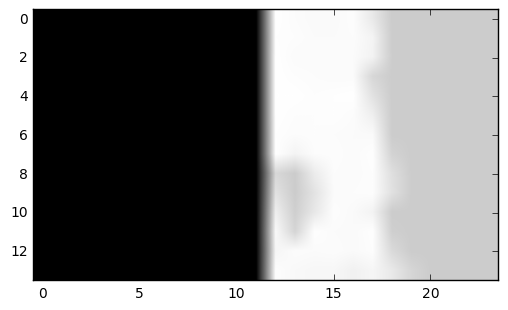

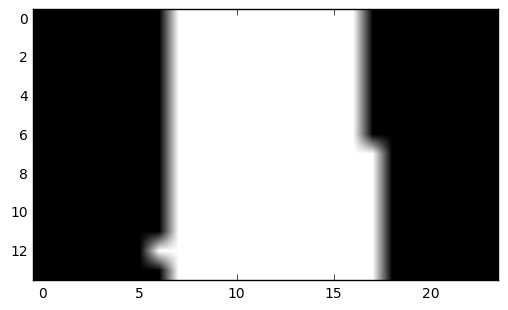

0 1
(14, 24)


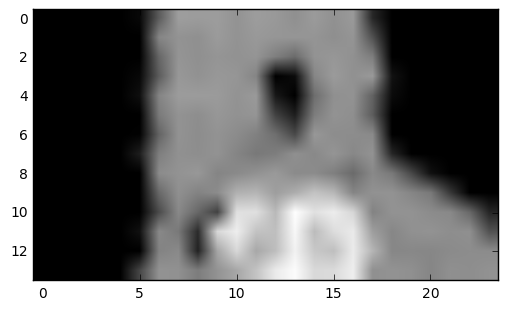

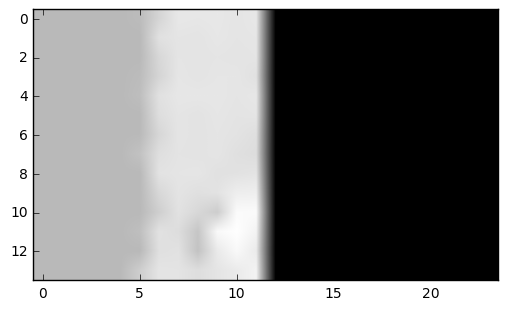

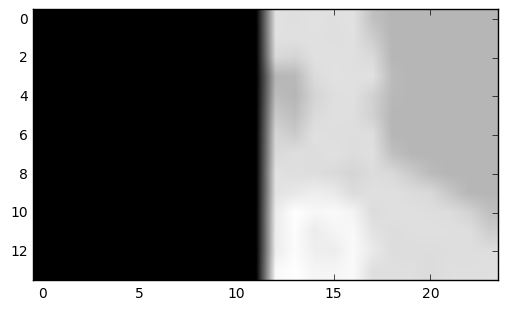

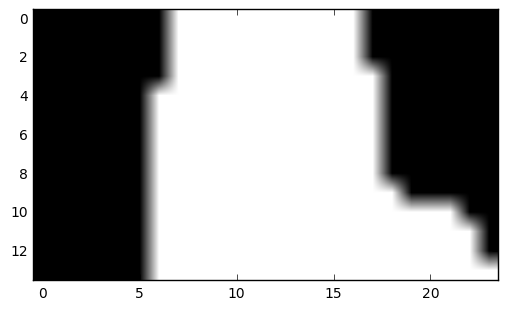

0 0
(14, 24)


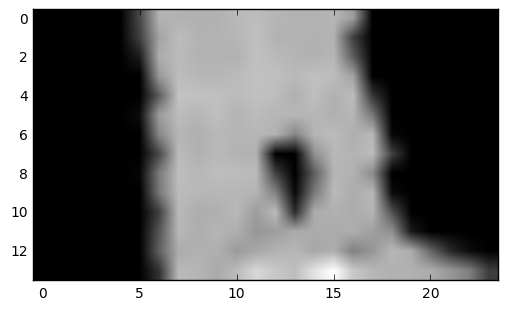

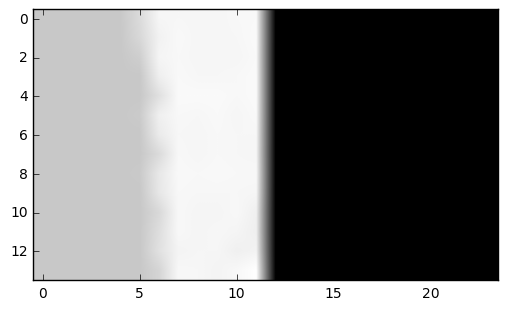

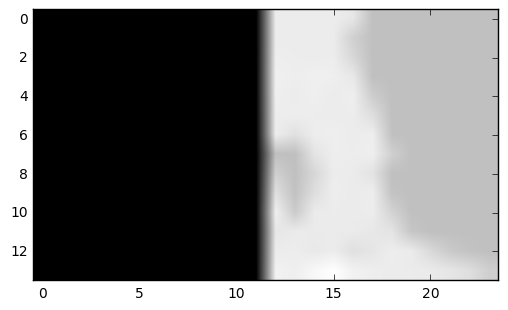

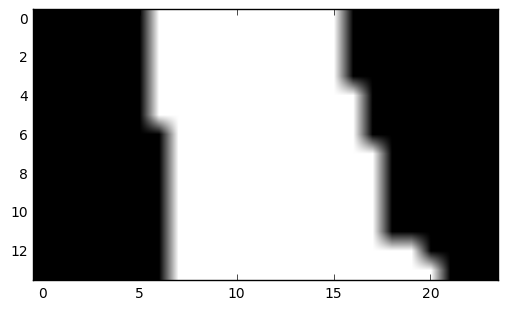

0 1
(14, 24)


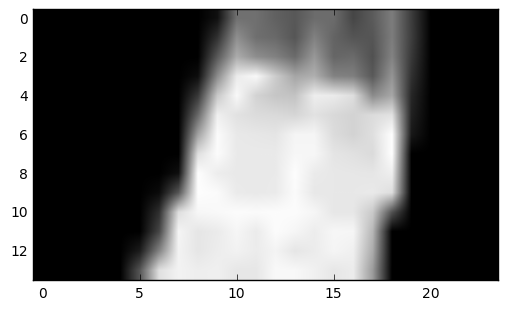

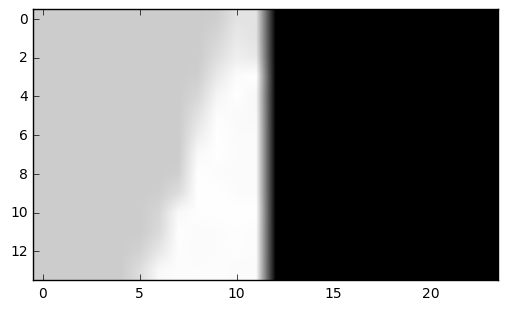

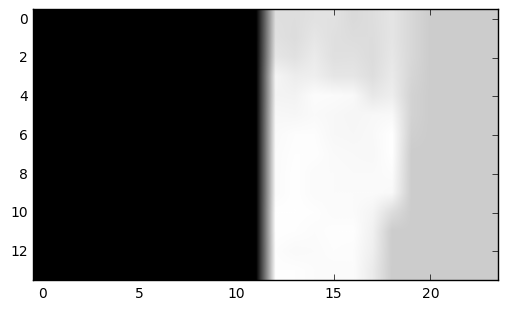

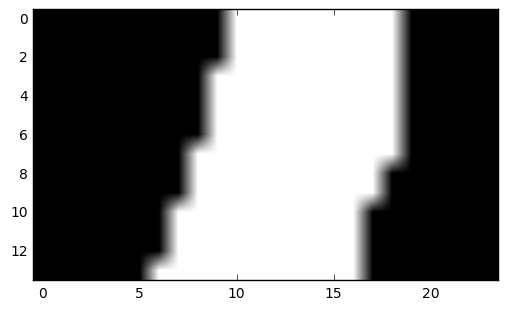

0 2
(14, 24)


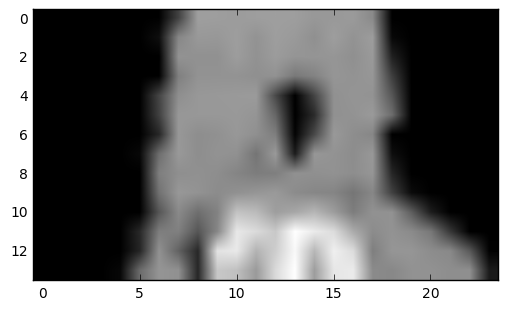

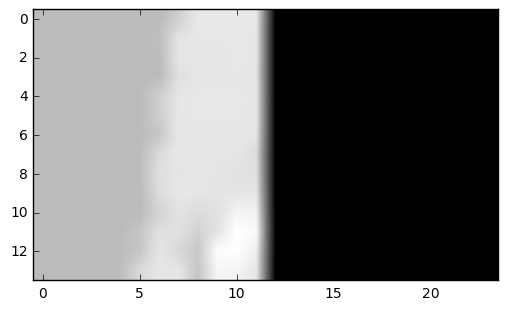

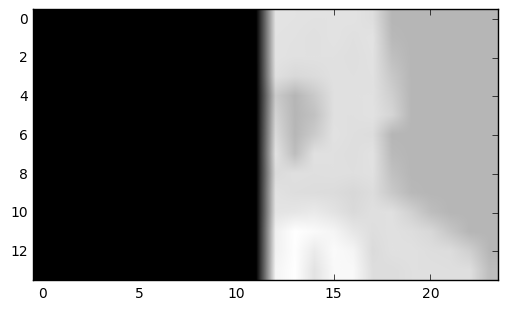

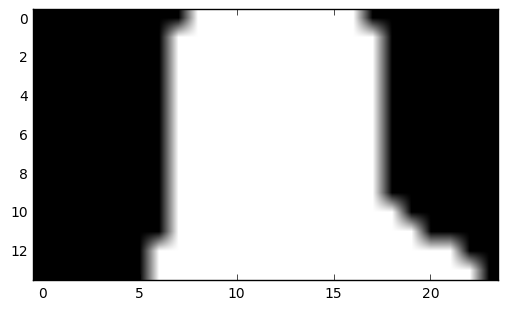

0 0
(14, 24)


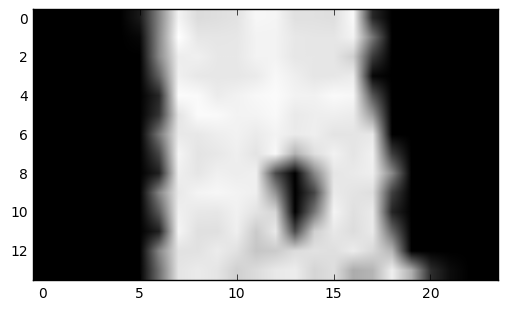

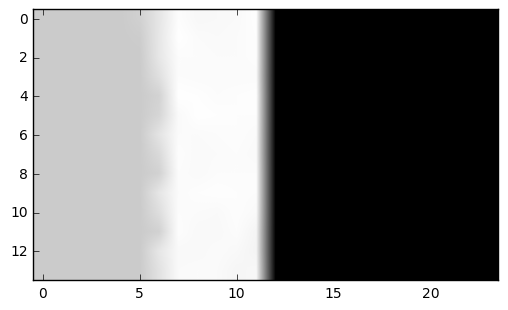

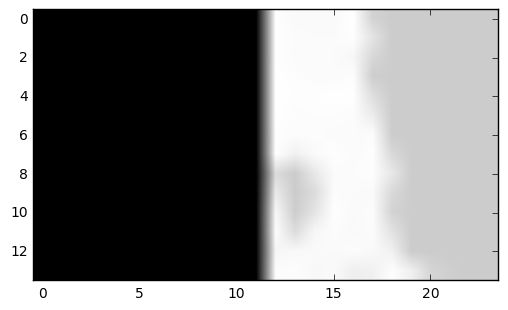

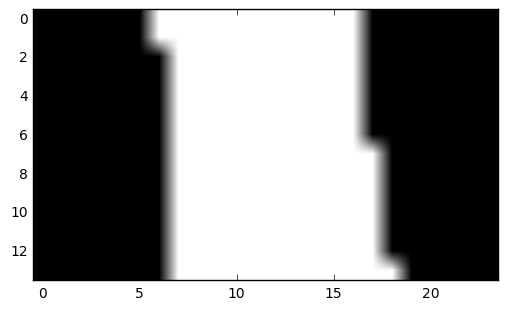

0 1
(14, 24)


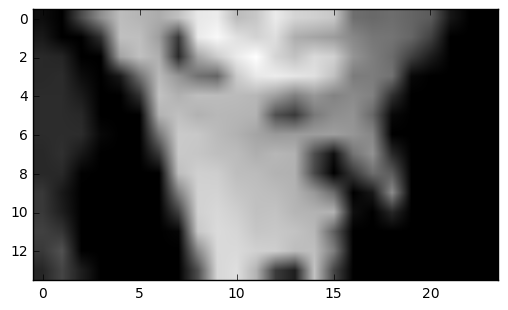

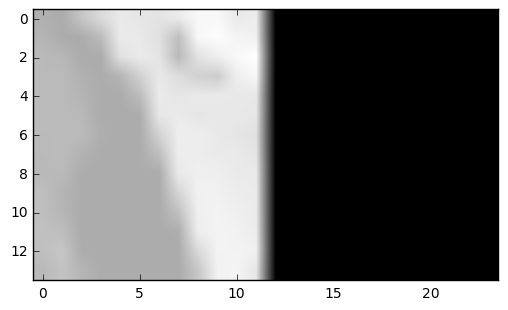

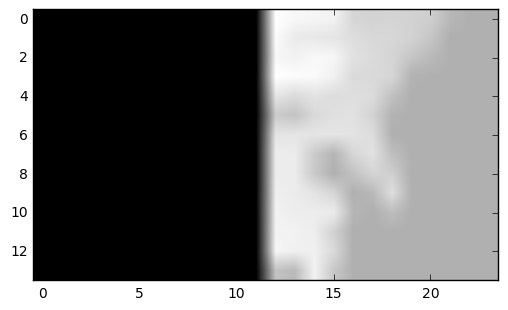

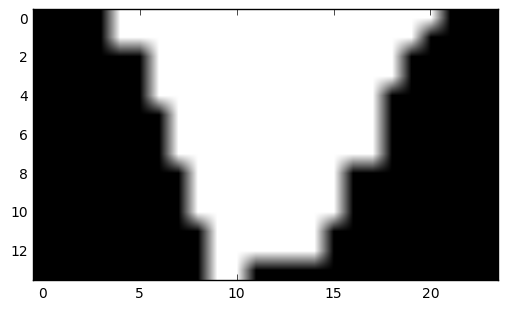

2 1
(14, 24)


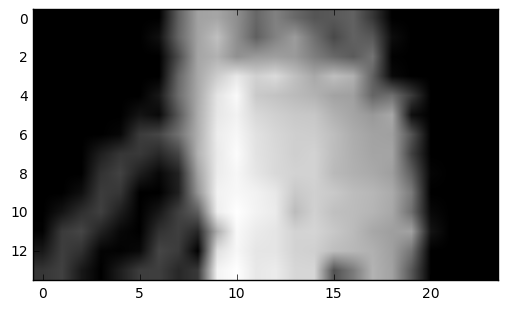

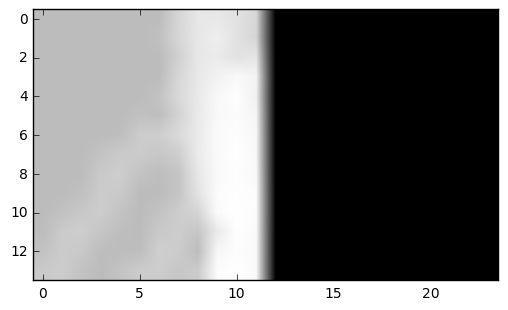

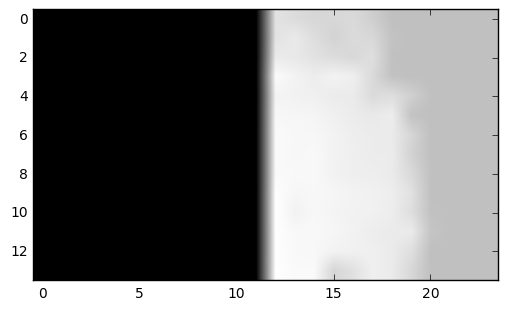

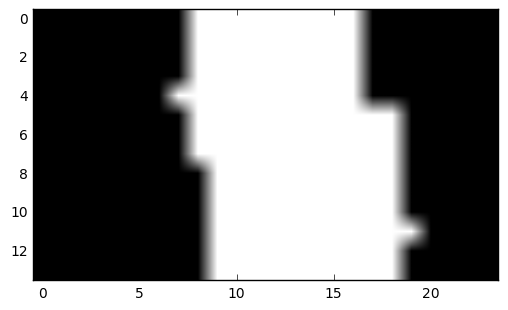

0 0
(14, 24)


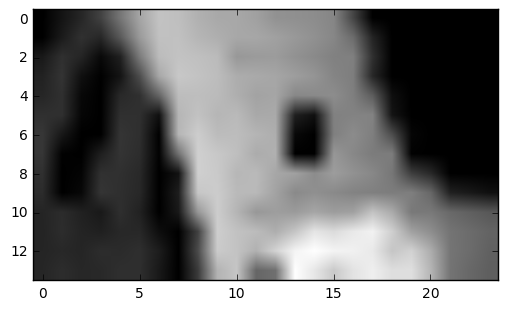

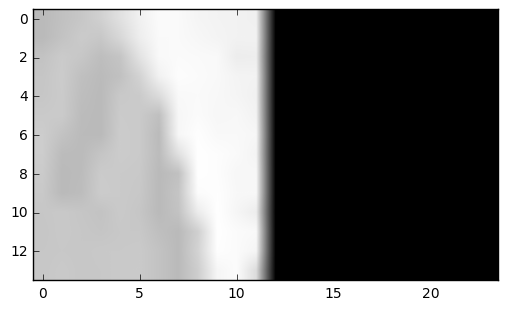

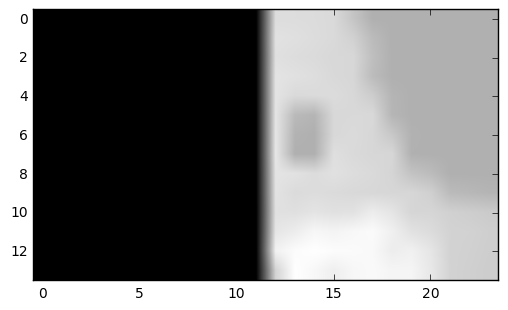

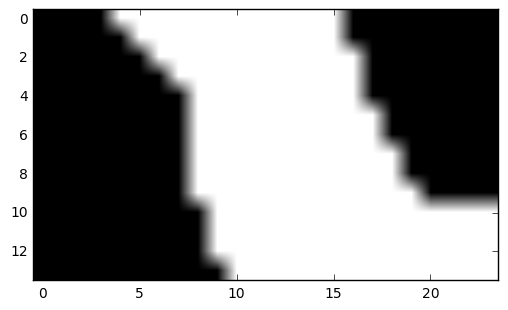

0 0
(14, 24)


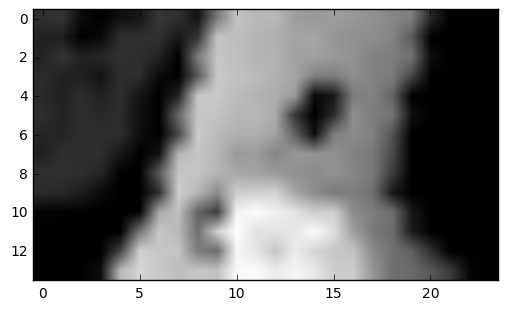

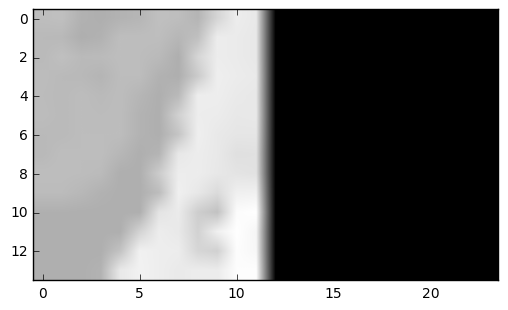

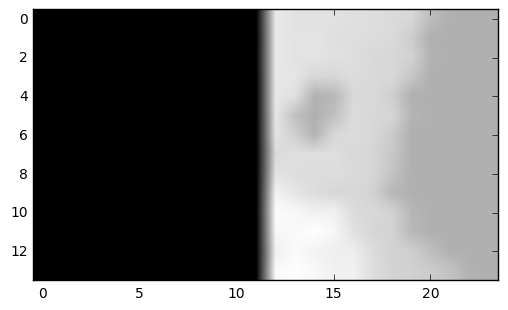

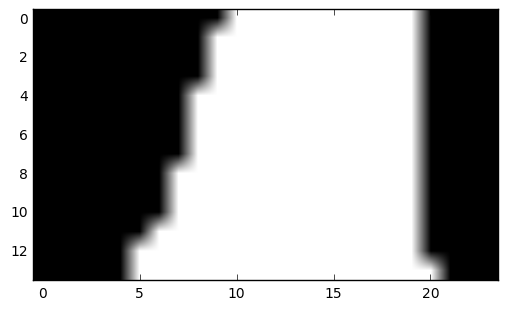

0 0
(14, 24)


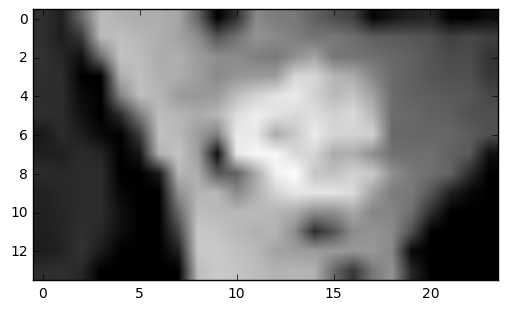

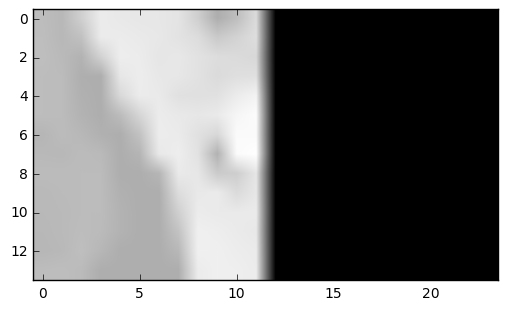

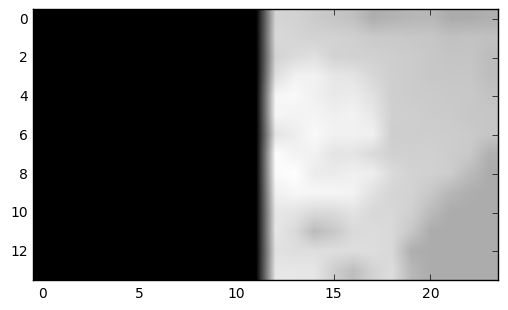

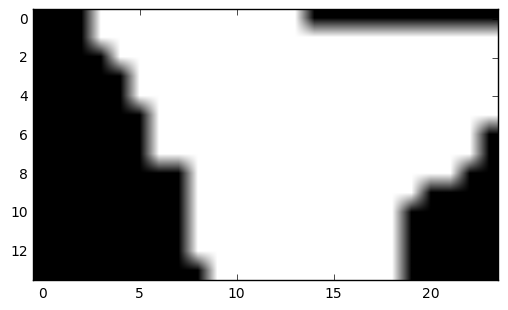

3 0
(14, 24)


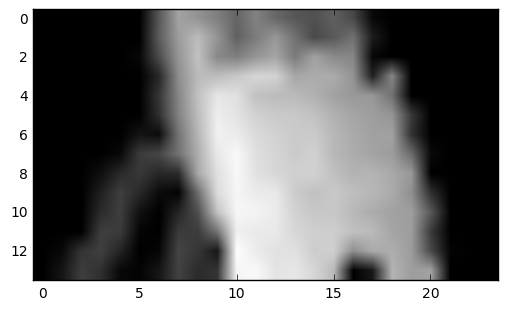

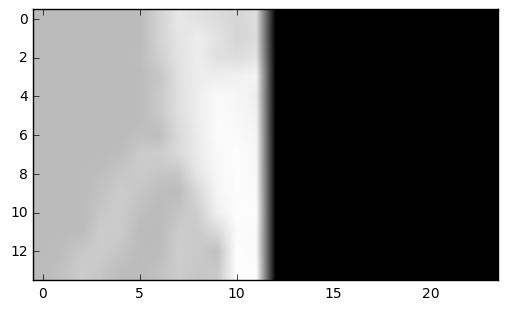

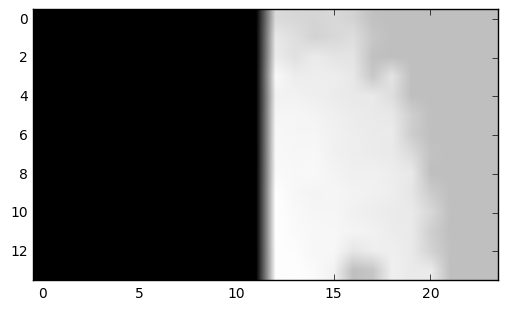

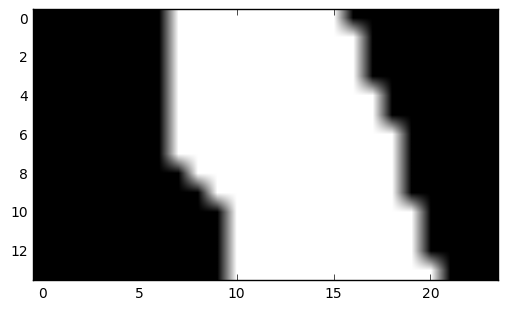

1 0
(14, 24)


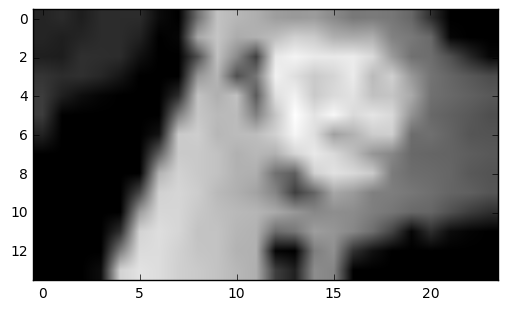

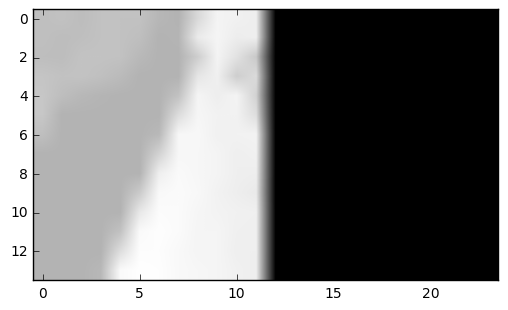

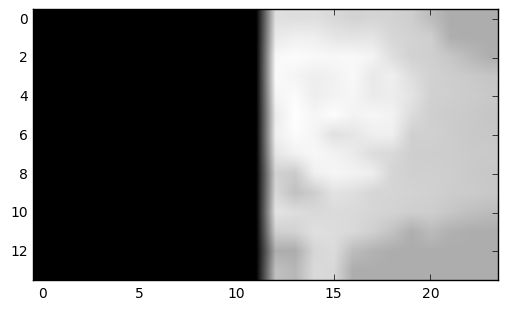

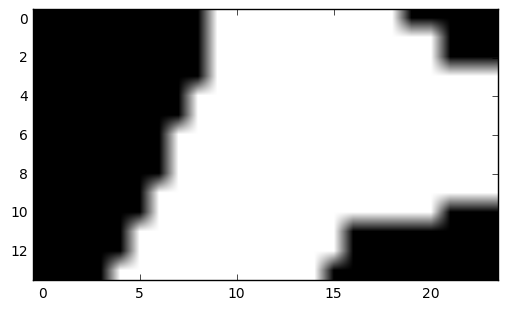

0 0
(14, 24)


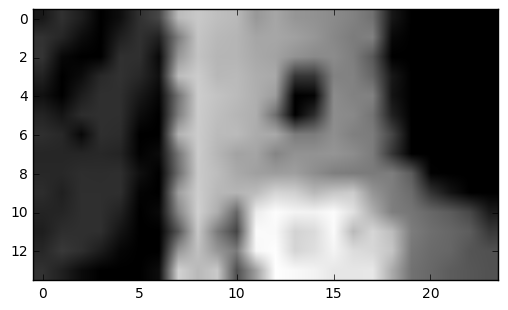

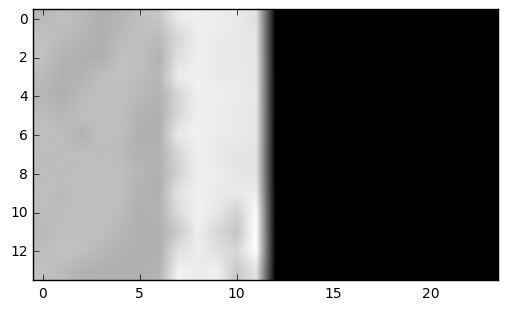

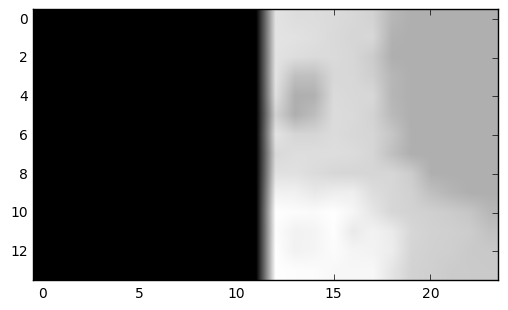

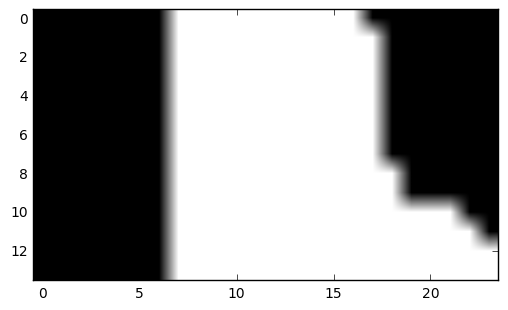

0 0
(14, 24)


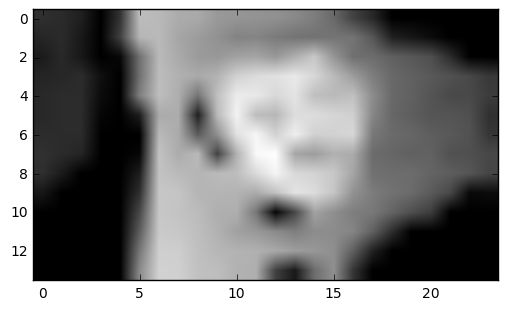

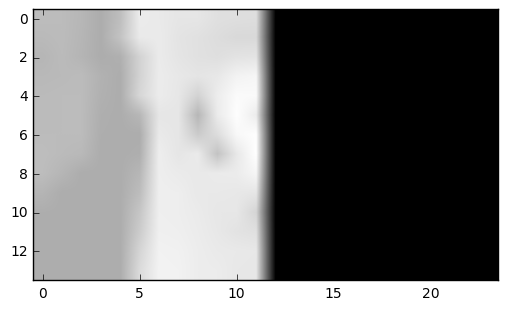

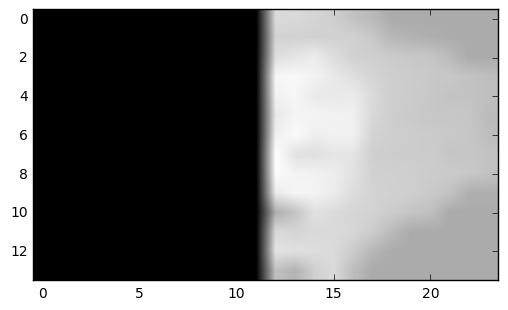

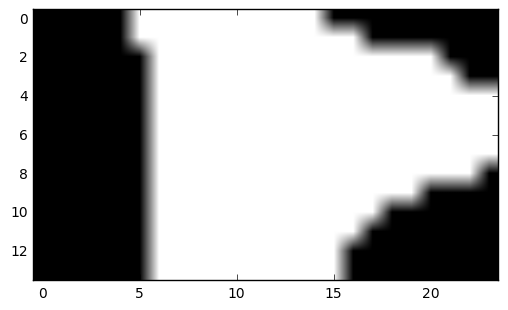

0 0
(14, 24)


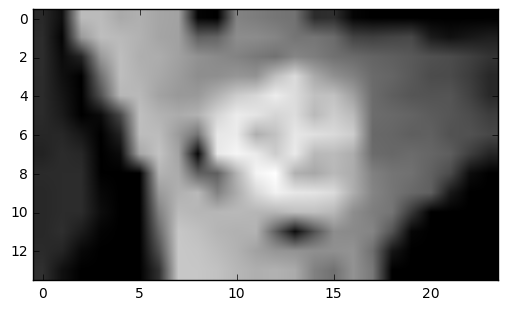

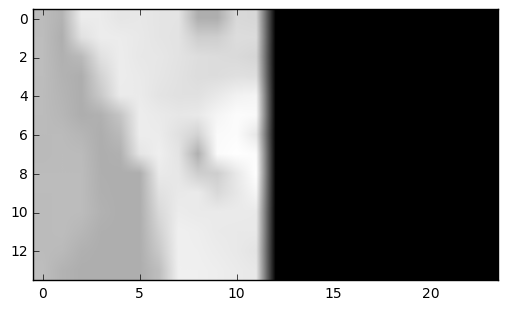

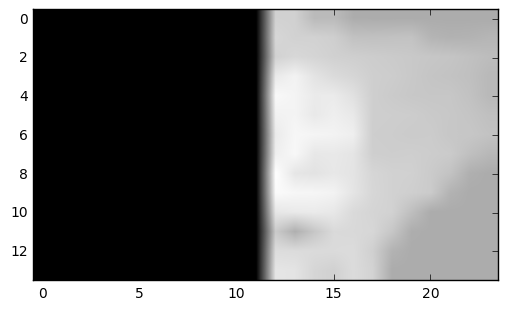

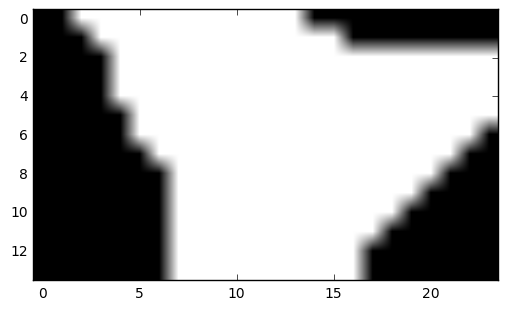

2 0


In [5]:
collision_scores = collision_est(depthImg, segImg, ID, grasps, [60,24])

In [ ]:
import matplotlib.pyplot as plt
for i in range(len(grasps)):
    plt.imshow(seg_fulls[i])
    plt.show()
    plt.imshow(depth_fulls[i], cmap = 'gray_r')
    plt.show()
    plt.imshow(seg_boundings[i])
    plt.show()
    plt.imshow(depth_boundings[i], cmap = 'gray_r')
    plt.show()
    print(collision_scores[i], '\n')